In [2]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from biasmodels import MagnificationBias, GalaxyBias, EvolutionBias
from multipole_signal import Signal, Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pickle as pk

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'xtick.direction': 'out',  
          'ytick.direction': 'out',  
          'xtick.minor.visible': True,  
          'ytick.minor.visible': True,
          'xtick.major.size': 9,
          'xtick.minor.size': 4.5,
          'ytick.major.size': 9,
          'ytick.minor.size': 4.5,
          'lines.linewidth': 1.75}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [3]:
# Redshift bins

z_bins = np.array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95])

# Separations

dist = [
    np.arange(20, 164, 4),
    np.arange(32, 164, 4),
]

params_dict0 = {
    'h' : 0.6766,
    'As' : 2.05e-9,
    'ns' : 0.9665,
    'Ob' : 0.04897, # This is here the density parameter of Baryons
    'Om' : 0.3111, # This is here the density parameter of Cold Dark Matter
}

steps = [1e-3, 1e-1, 1e-4, 1e-2, 1e-2]

#myDerivatives = Derivatives(params_dict0 = params_dict0,  wide_angle = False, dist_correction = False)

# Derivatives

In [4]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [5]:
dsignal_dsbias_fit = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias =  derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic =  derivatives_50x50['dsignal_dcosmic']

dsignal_dnum_fit =  derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias_fit), np.shape(dsignal_dgbias), np.shape(dsignal_dcosmic)

((8, 19, 324), (4, 19, 324), (5, 19, 324))

In [6]:
dsignal_dtheta_fit_all = np.concatenate([dsignal_dsbias_fit, dsignal_dnum_fit, dsignal_dgbias, dsignal_dcosmic])

np.shape(dsignal_dtheta_fit_all)

(21, 19, 324)

## Remove the DIPOLE

In [7]:
n_sep = len(dist[0])

print('Number of separations per multipole = ', n_sep)

Number of separations per multipole =  36


In [8]:
index_dipole = list(range(3*n_sep,4*n_sep))

print(index_dipole)

[108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


In [9]:
dsignal_dtheta_fit_ndip_ = np.concatenate([dsignal_dsbias_fit, dsignal_dnum_fit, dsignal_dgbias, dsignal_dcosmic])

dsignal_dtheta_fit_ndip = np.delete(dsignal_dtheta_fit_ndip_, index_dipole, axis=2)

np.shape(dsignal_dtheta_fit_ndip)

(21, 19, 288)

## Remove the octupole

In [10]:
n_sep = len(dist[0])

print('Number of separations per multipole = ', n_sep)

Number of separations per multipole =  36


In [11]:
dsignal_dsbias_fit_noct = dsignal_dsbias_fit[:,:,:-n_sep]

dsignal_dgbias_noct = dsignal_dgbias[:,:,:-n_sep]

dsignal_dcosmic_noct = dsignal_dcosmic[:,:,:-n_sep]

dsignal_dnum_fit_noct = dsignal_dnum_fit[:,:,:-n_sep]

np.shape(dsignal_dsbias_fit_noct), np.shape(dsignal_dgbias_noct), np.shape(dsignal_dcosmic_noct), np.shape(dsignal_dnum_fit_noct)

((8, 19, 288), (4, 19, 288), (5, 19, 288), (4, 19, 288))

In [12]:
dsignal_dtheta_fit_noct = np.concatenate([dsignal_dsbias_fit_noct, dsignal_dnum_fit_noct, dsignal_dgbias_noct, dsignal_dcosmic_noct])

np.shape(dsignal_dtheta_fit_noct)

(21, 19, 288)

# Analysis with $m = 2.0$

## NO OCTUPOLE

In [13]:
# Create the Cov Matrix for sB, sF, nevol

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

sB_4fit = np.array([-0.90110744,  1.82300203, -1.01878439, -0.30342324])
sF_4fit = np.array([-0.19376095,  1.0747336,  -0.07806247, -0.00558005])
nevol_fid = np.array([7.94599875, -12.03752387,   2.29927261, -15.83887369])

num_fit = nevol_fid

dsB_19bins = sB_4fit * errB[0] 
dsF_19bins = sF_4fit * errF[0]

dnum_19bins = num_fit * errB[1]

Cov_all_19bins = np.diag(np.concatenate([dsB_19bins**2, dsF_19bins**2, dnum_19bins**2]))

Inv_Cov_all_19bins = np.linalg.inv(Cov_all_19bins)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_fit_all), len(dsignal_dtheta_fit_all)])

Inv_Cov_prior_all[:len(Inv_Cov_all_19bins), :len(Inv_Cov_all_19bins)] = Inv_Cov_all_19bins

np.shape(Cov_all_19bins)

(12, 12)

In [27]:
np.diag(Cov_all_19bins)

array([2.02998655e-01, 8.30834100e-01, 2.59480408e-01, 2.30164156e-02,
       9.38582644e-03, 2.88763078e-01, 1.52343731e-03, 7.78423950e-06,
       1.57847240e+01, 3.62254952e+01, 1.32166363e+00, 6.27174799e+01])

In [14]:
Cov_multipoles_19bins = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50,50])

np.shape(Cov_multipoles_19bins), type(Cov_multipoles_19bins)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 

Population splitted in 50% BRIGHT - 50% FAINT 


 ... Success! ... 



((19, 324, 324), list)

In [19]:
Cov_multipoles_noct_19bins = [Cov_multipoles_19bins[k][:-n_sep,:-n_sep] for k,_ in enumerate(z_bins)]

np.shape(Cov_multipoles_noct_19bins)

(19, 288, 288)

In [20]:
np.diag(Inv_Cov_prior_all)

array([4.92614102e+00, 1.20360972e+00, 3.85385550e+00, 4.34472515e+01,
       1.06543628e+02, 3.46304662e+00, 6.56410340e+02, 1.28464701e+05,
       6.33523904e-02, 2.76048676e-02, 7.56622165e-01, 1.59445182e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [29]:
Inv_Cov_multipoles_noct_19bins = [np.linalg.inv(Cov_multipoles_noct_19bins[k]) for k,_ in enumerate(z_bins)]

Fisher_Matrix_noct_perbin_noprior = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_noct, inv_cov = Inv_Cov_multipoles_noct_19bins, z_bins = z_bins, bins=True)
Fisher_Matrix_noct_perbin = Fisher_Matrix_noct_perbin_noprior + Inv_Cov_prior_all

np.shape(Fisher_Matrix_noct_perbin_noprior)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(19, 21, 21)

In [30]:
# Pick the s_{M,3} terms

for k,z in enumerate(z_bins):
    print(r'$z$ = '+str(z), r'$F_{s_{M,3}}$ = ', Fisher_Matrix_noct_perbin_noprior[k,7,7], Fisher_Matrix_noct_perbin[k,7,7])

$z$ = 0.15 $F_{s_{M,3}}$ =  39155.01537934746 167619.71638446295
$z$ = 0.25 $F_{s_{M,3}}$ =  32173.00207026125 160637.70307537675
$z$ = 0.35 $F_{s_{M,3}}$ =  13498.80184854655 141963.50285366204
$z$ = 0.45 $F_{s_{M,3}}$ =  4215.416933809619 132680.1179389251
$z$ = 0.55 $F_{s_{M,3}}$ =  1073.3630137785458 129538.06401889405
$z$ = 0.65 $F_{s_{M,3}}$ =  224.07707399287733 128688.77807910836
$z$ = 0.75 $F_{s_{M,3}}$ =  32.49048448898065 128497.19148960448
$z$ = 0.85 $F_{s_{M,3}}$ =  2.5059887022761353 128467.20699381777
$z$ = 0.95 $F_{s_{M,3}}$ =  0.016915400266453967 128464.71792051576
$z$ = 1.05 $F_{s_{M,3}}$ =  0.009489346058193664 128464.71049446156
$z$ = 1.15 $F_{s_{M,3}}$ =  0.4300236754387414 128465.13102879093
$z$ = 1.25 $F_{s_{M,3}}$ =  1.7786761087534952 128466.47968122424
$z$ = 1.35 $F_{s_{M,3}}$ =  3.7546394920979695 128468.45564460759
$z$ = 1.45 $F_{s_{M,3}}$ =  5.164993126496482 128469.86599824199
$z$ = 1.55 $F_{s_{M,3}}$ =  6.070438871735085 128470.77144398724
$z$ = 1.65 $F_

In [31]:
Inv_Cov_multipoles_noct_19bins = [np.linalg.inv(Cov_multipoles_noct_19bins[k]) for k,_ in enumerate(z_bins)]

Fisher_Matrix_multipoles_noct_19bins = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_noct, inv_cov = Inv_Cov_multipoles_noct_19bins, z_bins = z_bins)
Fisher_Matrix_noct_19bins = Fisher_Matrix_multipoles_noct_19bins + Inv_Cov_prior_all

Sigma_Matrix_noct_19bins = np.linalg.inv(Fisher_Matrix_noct_19bins)

np.shape(Sigma_Matrix_noct_19bins)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [32]:
Fisher_Matrix_noct_19bins[7,7]

218872.50815254613

In [17]:
np.savetxt('data/Fisher_Dipole.txt',X=Fisher_Matrix_noct_19bins, fmt='%.5e')

#### Constraints

In [33]:
#Absolute Errors

Abs_Errors_noct_19bins = np.sqrt(np.diag(Sigma_Matrix_noct_19bins))

# Fiducial values

sbias_fid = np.concatenate([sB_4fit, sF_4fit])
num_fid = num_fit
gbias_fid = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sbias_fid, num_fid, gbias_fid, cosmic_fid])

# Relative errors

Rel_Errors_noct_19bins = np.abs(Abs_Errors_noct_19bins/params_fid)

params_errors_noct_19bins = Rel_Errors_noct_19bins * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sbias = ', params_errors_noct_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])
print()
print('gbias = ', params_errors_noct_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_noct_19bins[(len(sbias_fid) + len(num_fid)+len(gbias_fid)):])


------------ Relative errors * 100 ------------

sbias =  [36.81396256 20.01069479 26.3634573  26.18167445 47.70070085 31.79585479
 49.25653578 49.98536768]

number =  [44.85256149 43.74071271 40.38633243 33.16321126]

gbias =  [0.42753427 0.36836479 0.14148578 0.27892773]

cosmic =  [1.10516521 0.70808825 0.89916961 1.13028575 0.49631382]


#### Predictions

##### Magnification bias

In [25]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

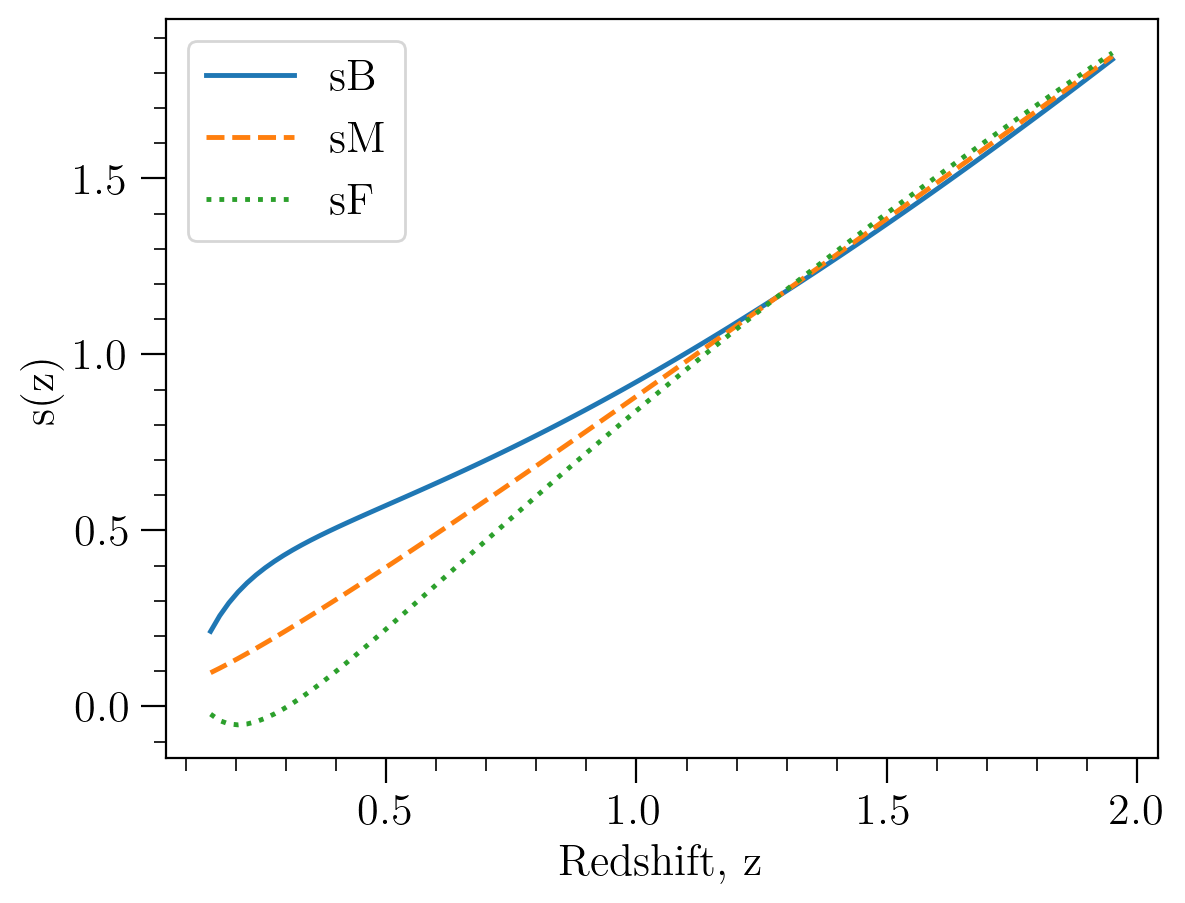

In [26]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

sB_fid = magbias_fit(sB_4fit, z_lin)
sM_fid = magbias_fit(sF_4fit, z_lin)
sF_fid = sM_fid * (m_split/(m_split-1)) - sB_fid/(m_split-1)

plt.plot(z_lin, sB_fid, '-', label=r'sB')
plt.plot(z_lin, sM_fid, '--', label=r'sM')
plt.plot(z_lin, sF_fid, ':', label=r'sF')

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();


###### Compare the two observables

In [133]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_noct = Sigma_Matrix_noct_19bins[:4, :4]
cov_sM_noct = Sigma_Matrix_noct_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_noct = np.random.multivariate_normal(sB_4fit, cov_sB_noct, num_samples)
sM_pars_samples_noct = np.random.multivariate_normal(sF_4fit, cov_sM_noct, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_noct = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_noct])
sM_samples_noct = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_noct])

# Calculate the 68% confidence interval
sB_lower_bound_noct = np.percentile(sB_samples_noct, 16, axis=0)
sB_upper_bound_noct = np.percentile(sB_samples_noct, 84, axis=0)
sM_lower_bound_noct = np.percentile(sM_samples_noct, 16, axis=0)
sM_upper_bound_noct = np.percentile(sM_samples_noct, 84, axis=0)

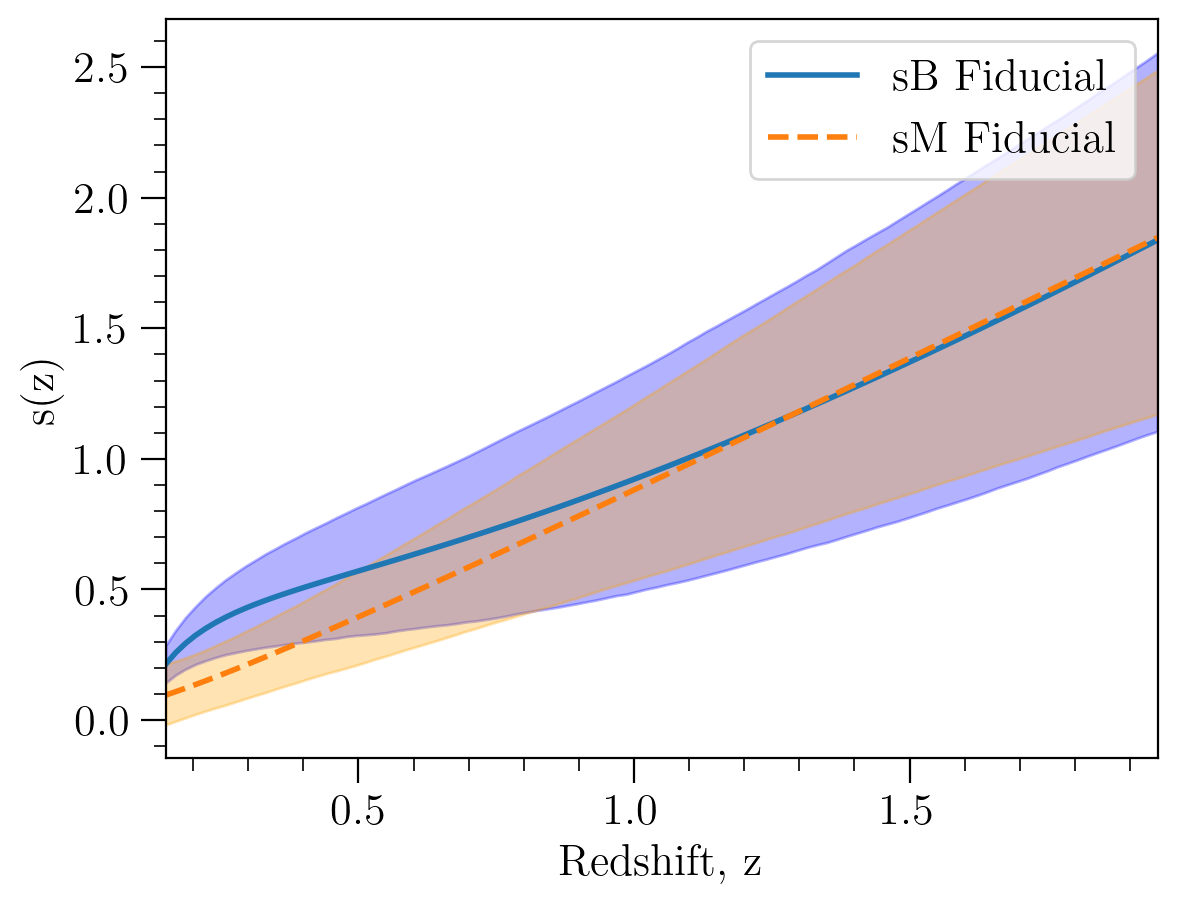

In [134]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0)
plt.plot(z_lin, sM_fid, '--', label=r'sM Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='orange', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

###### Compare with priors

In [135]:
# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_priors = Cov_all_19bins[:4, :4]
cov_sM_priors = Cov_all_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_priors = np.random.multivariate_normal(sB_4fit, cov_sB_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sF_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_priors])
sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval
sB_lower_bound_priors = np.percentile(sB_samples_priors, 16, axis=0)
sB_upper_bound_priors = np.percentile(sB_samples_priors, 84, axis=0)
sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)

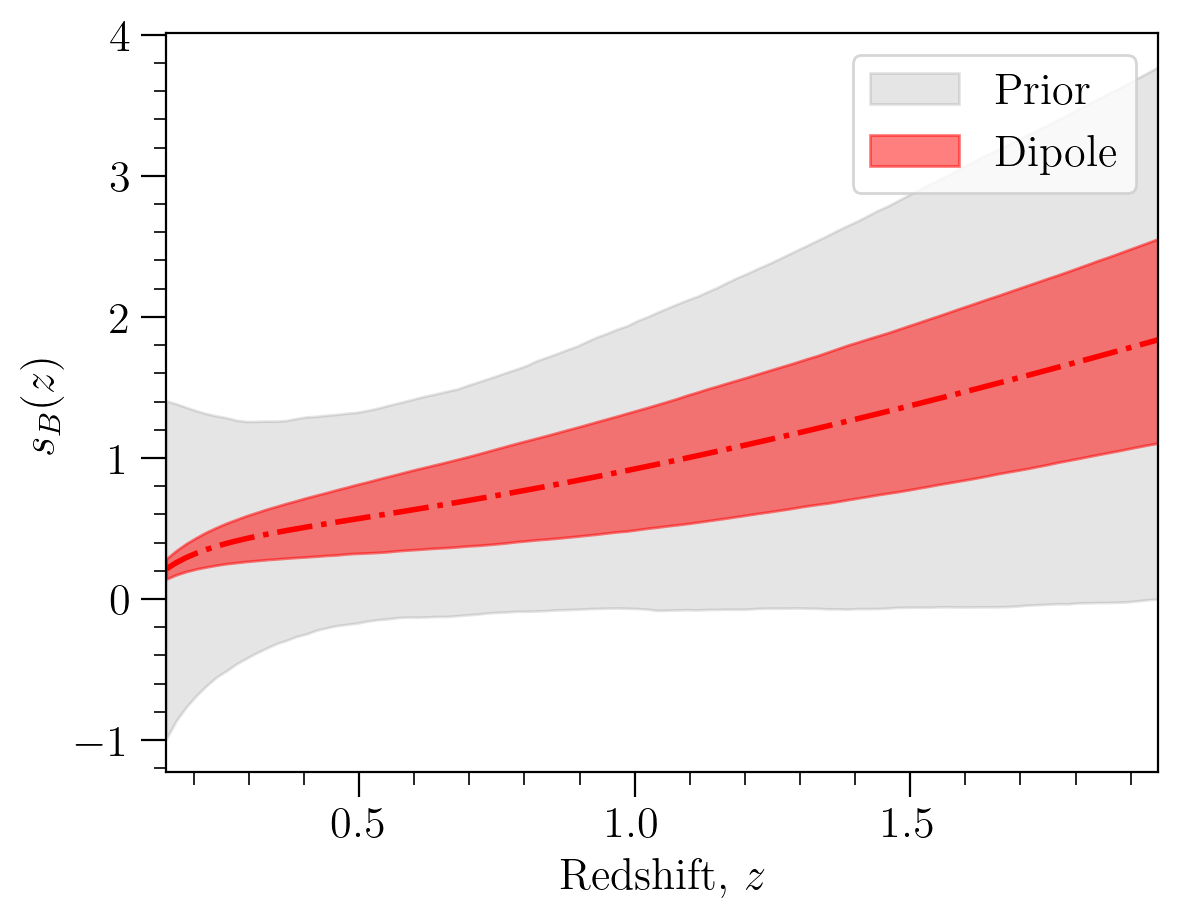

In [136]:
plt.plot(z_lin, sB_fid, '-.', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.1, label= 'Prior')
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='red', alpha=0.5, label = 'Dipole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'')
plt.legend();

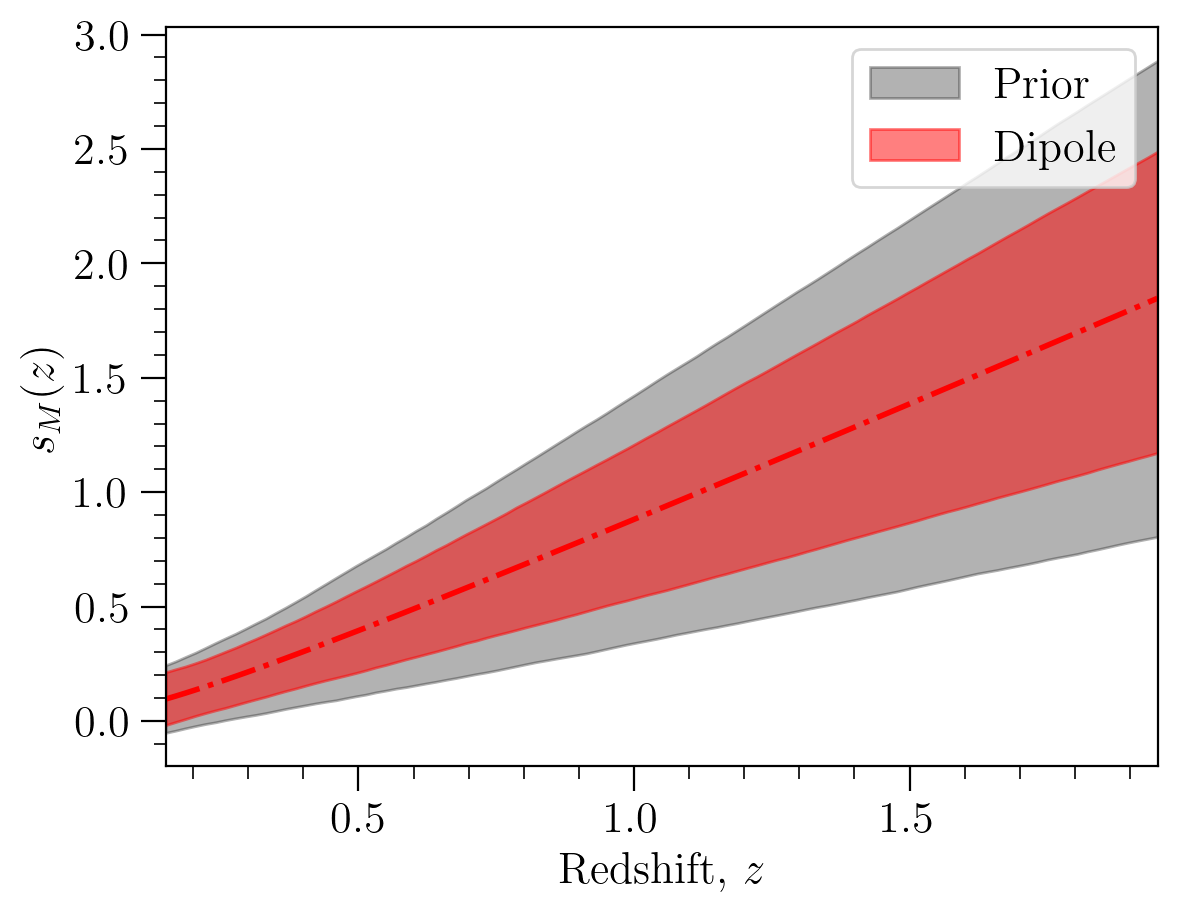

In [137]:
plt.plot(z_lin, sM_fid, '-.', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label='Prior')
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='red', alpha=0.5, label='Dipole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'');
plt.legend();

###### Magnification bias of the Faint

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [138]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_noct = Sigma_Matrix_noct_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sbias_pars_samples_noct = np.random.multivariate_normal(sbias_fid, cov_sbias_noct, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_noct = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_noct])
sM_samples_noct = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_noct])

# Compute the sF for each sample
sF_samples_noct = sM_samples_noct*m_split/(m_split-1) - sB_samples_noct/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_noct = np.percentile(sF_samples_noct, 16, axis=0)
sF_upper_bound_noct = np.percentile(sF_samples_noct, 84, axis=0)

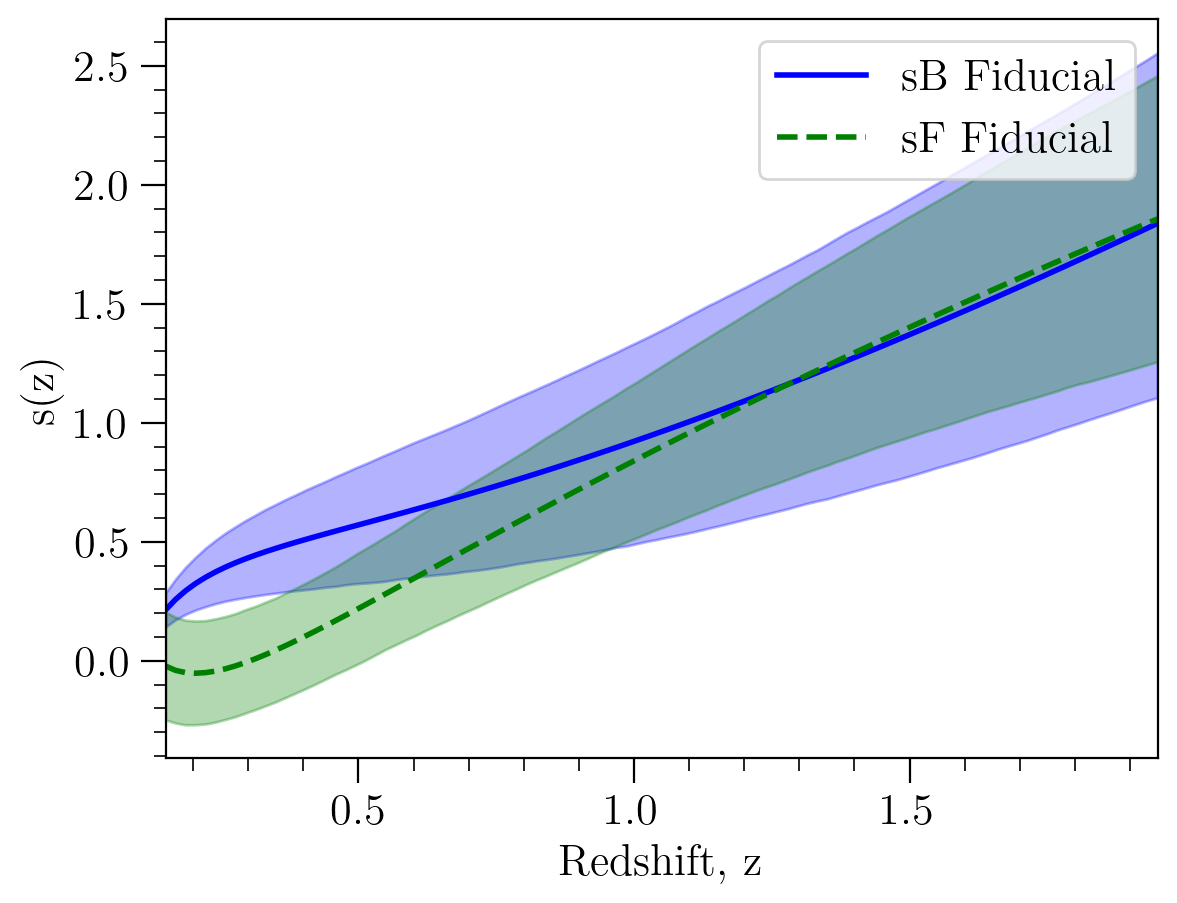

In [139]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='blue')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

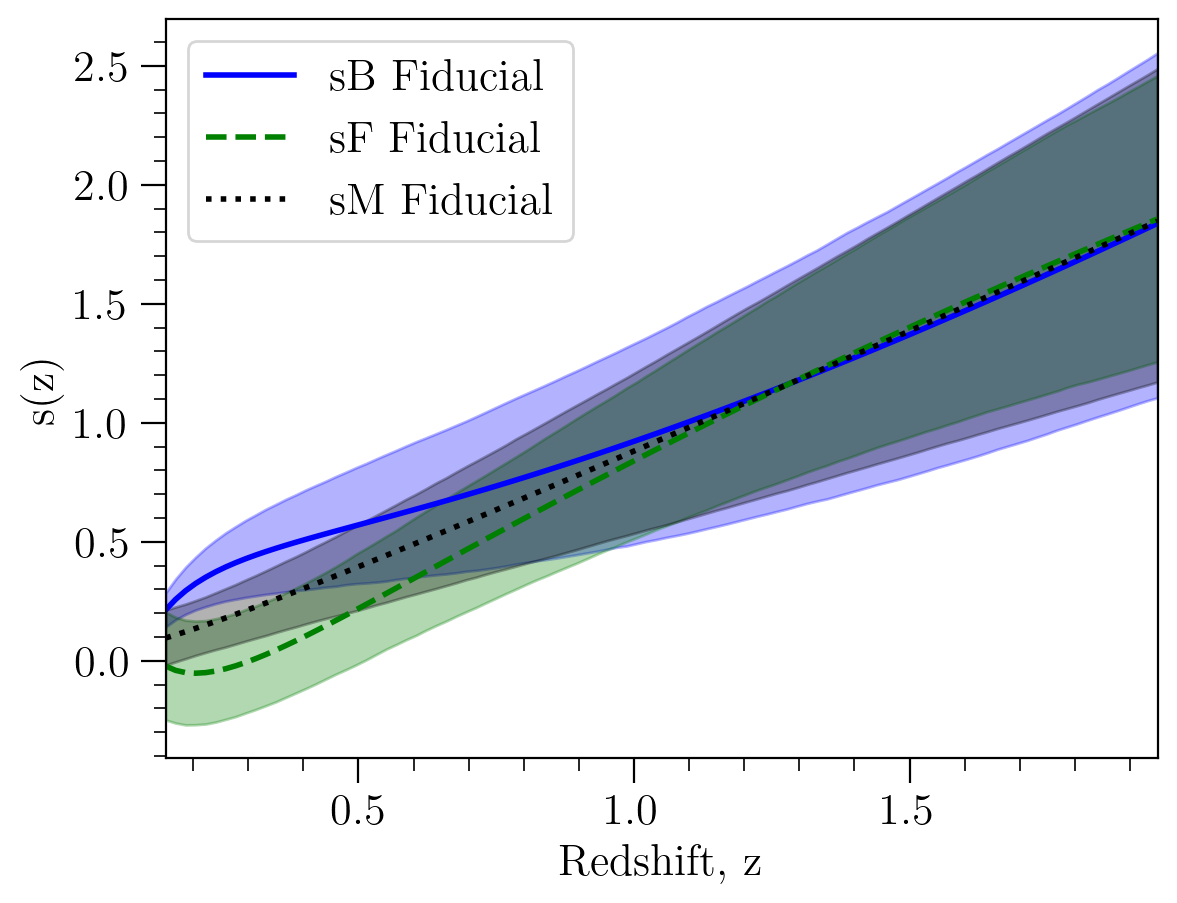

In [140]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='blue')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')
plt.plot(z_lin, sM_fid, ':', label=r'sM Fiducial', lw = 2.0, color='black')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='black', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

Compare with priors

In [141]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_priors = Cov_all_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sbias_pars_samples_priors = np.random.multivariate_normal(sbias_fid, cov_sbias_priors, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_priors])
sM_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_priors])

# Compute the sF for each sample
sF_samples_priors = sM_samples_priors*m_split/(m_split-1) - sB_samples_priors/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_priors = np.percentile(sF_samples_priors, 16, axis=0)
sF_upper_bound_priors = np.percentile(sF_samples_priors, 84, axis=0)

Text(0.5, 1.0, 'Prediction vs Prior')

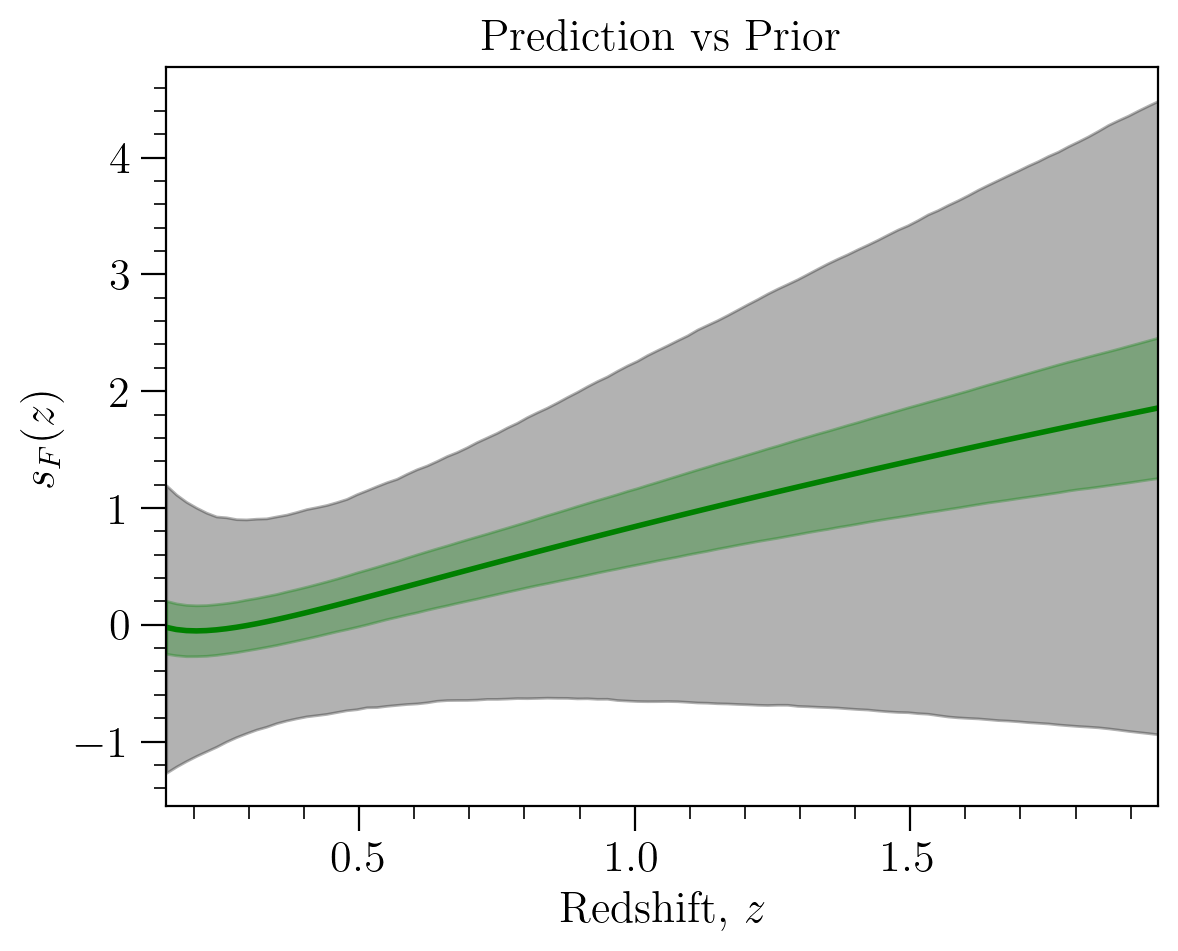

In [142]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='green')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')

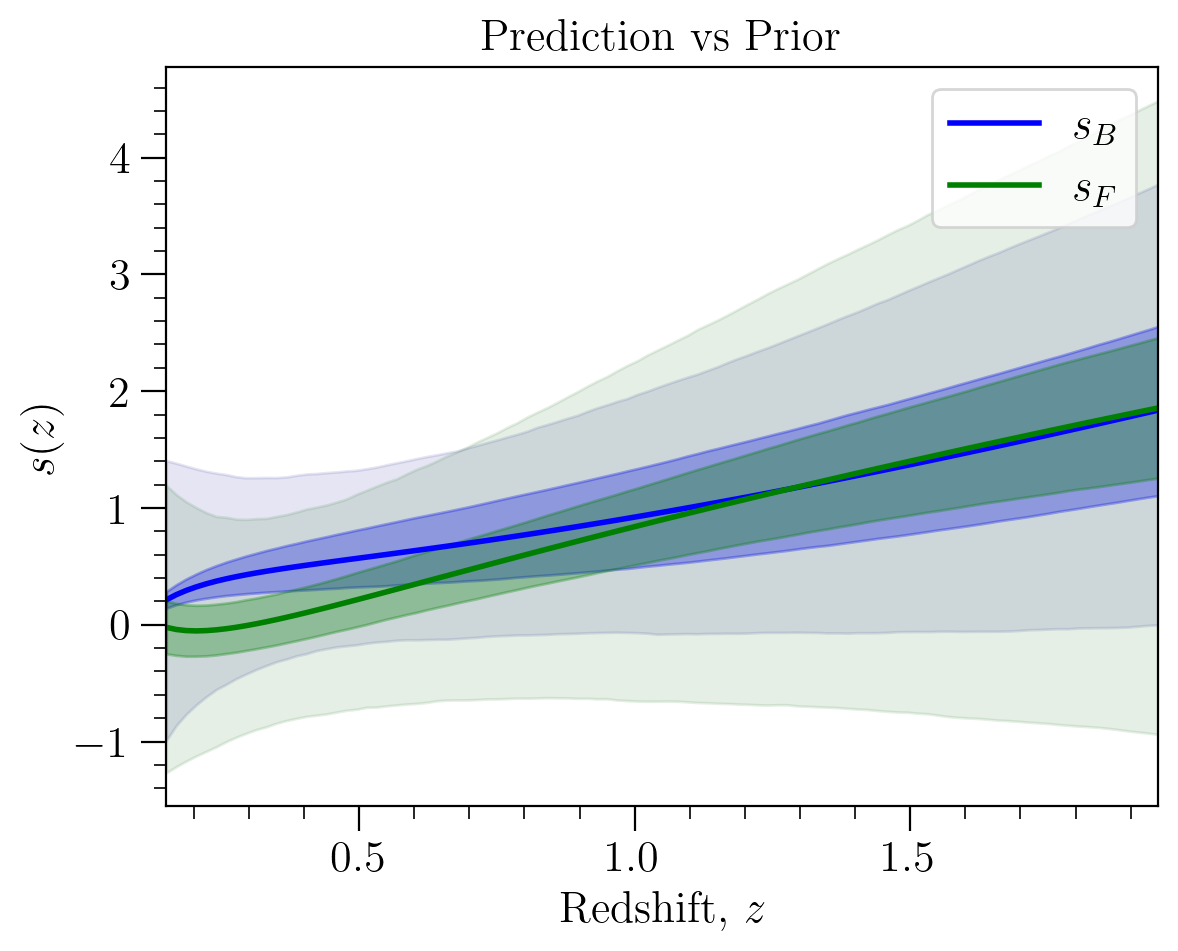

In [143]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='blue', label=r'$s_B$')
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='green', label=r'$s_F$')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='darkblue', alpha=0.1)
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='darkgreen', alpha=0.1)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s(z)$');
plt.title(r'Prediction vs Prior');
plt.legend();

##### Number evolution

In [144]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

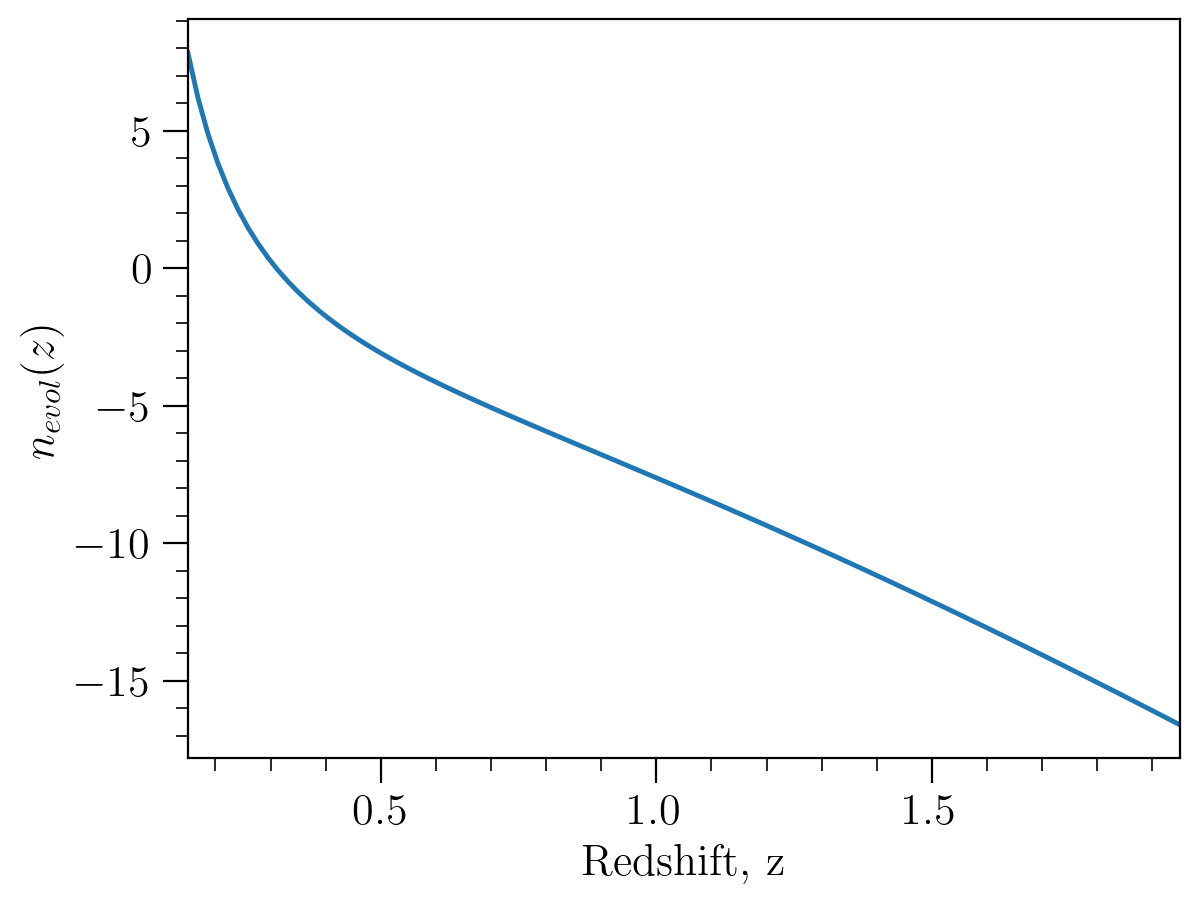

In [145]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(nevol_fid, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');

In [146]:
# Select the marginalized covariance matrix for the number evolution
cov_numevol_noct = Sigma_Matrix_noct_19bins[8:12, 8:12]
cov_numevol_priors = Cov_all_19bins[8:12, 8:12]


# Generate parameter samples from multivariate normal distribution
num_samples = 5000
nevol_pars_samples_noct = np.random.multivariate_normal(nevol_fid, cov_numevol_noct, num_samples)
nevol_samples_priors = np.random.multivariate_normal(nevol_fid, cov_numevol_priors, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_noct = np.array([nevol_fit(pars, z_lin) for pars in nevol_pars_samples_noct])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_lower_bound_noct = np.percentile(nevol_samples_noct, 16, axis=0)
nevol_upper_bound_noct = np.percentile(nevol_samples_noct, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

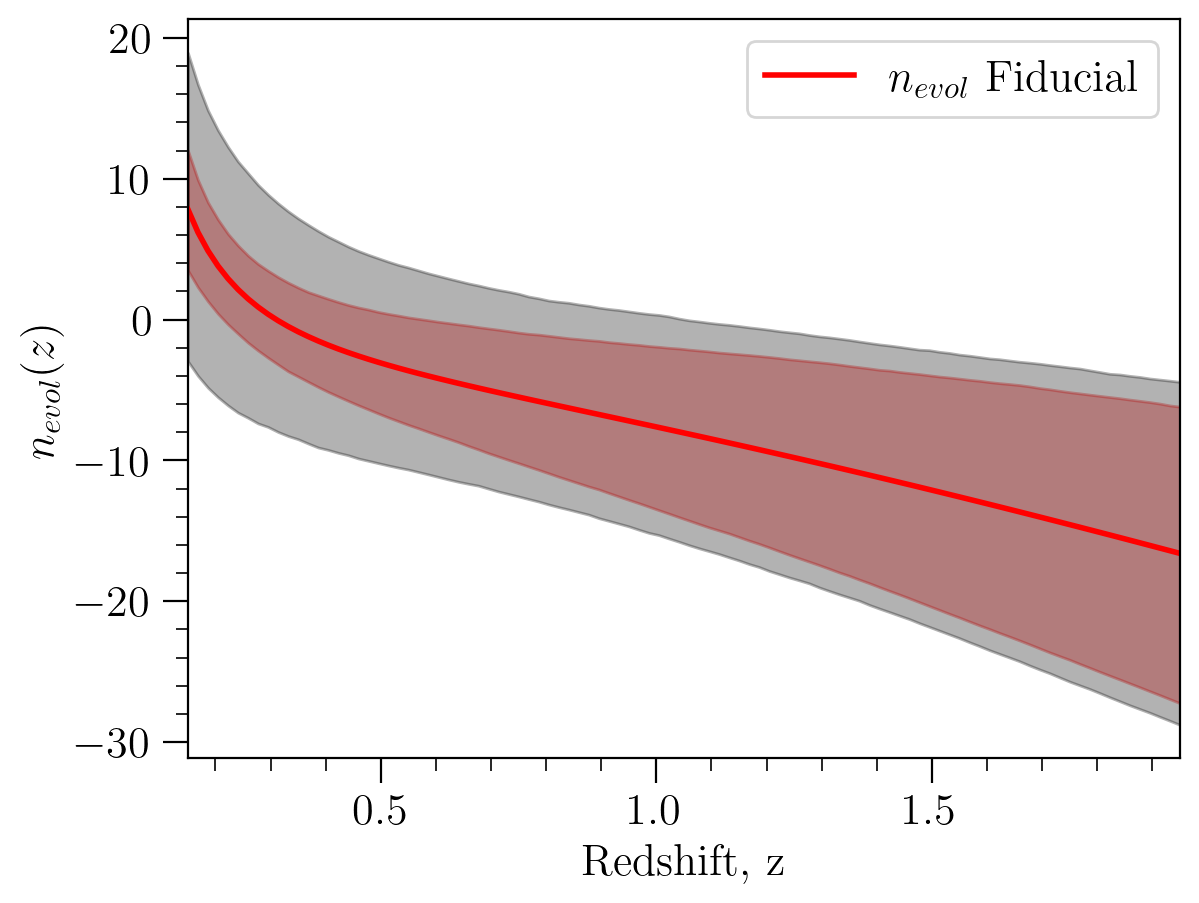

In [147]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_noct, nevol_upper_bound_noct, color='red', alpha=0.3)
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

##### Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [148]:
m_split = 2.

myEvolBias = EvolutionBias(n_split=m_split)

dlogH = myEvolBias.dlogH
rHterm = myEvolBias.rHterm
dFstar = myEvolBias.dLogFstar
dFcut = myEvolBias.dLogFcut

In [149]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

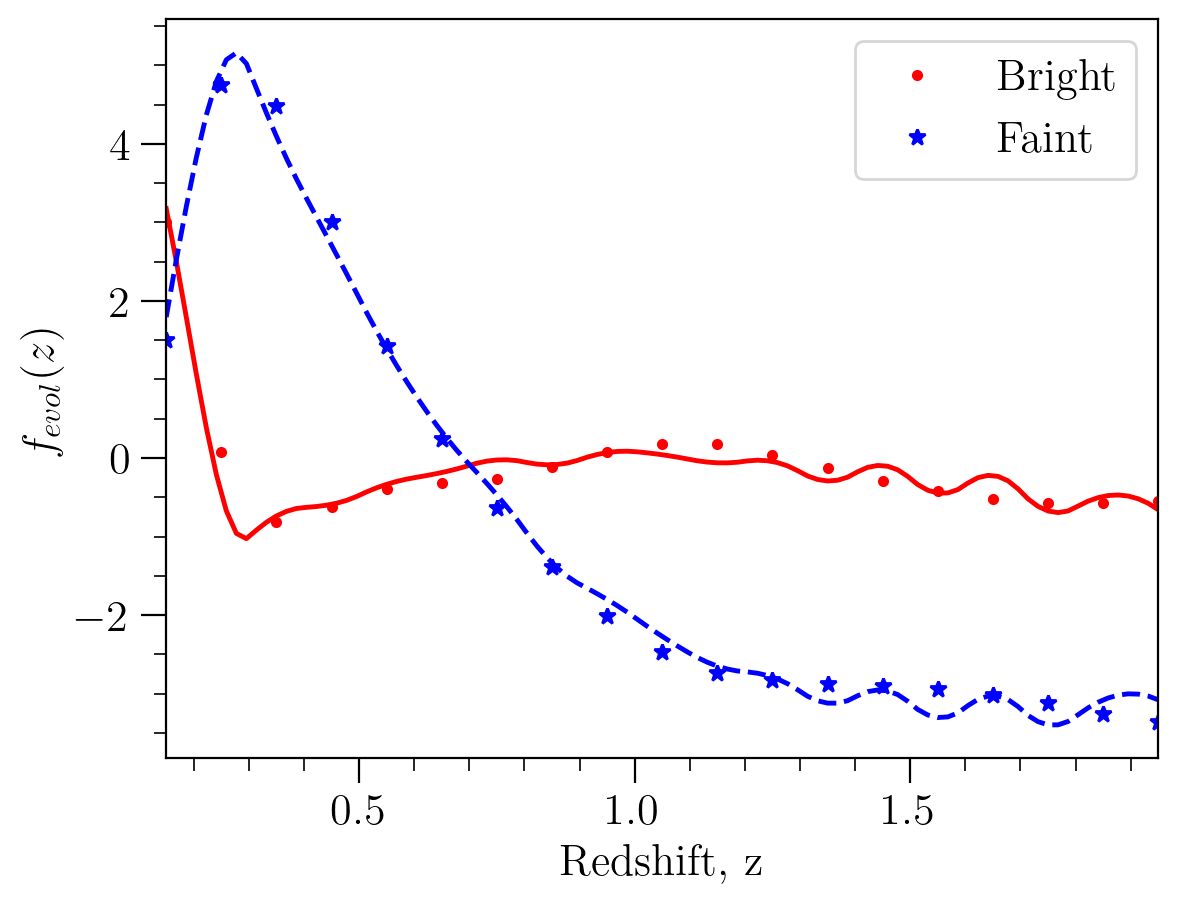

In [150]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_B_fid = fevol_bright(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)
fevol_F_fid = fevol_faint(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)

plt.plot(z_lin, fevol_B_fid, 'r-')
plt.plot(z_lin, fevol_F_fid, 'b--')

feB = myEvolBias.fevol_bright(z_bins)
feF = myEvolBias.fevol_faint(z_bins)

plt.plot(z_bins, feB, 'r.', label='Bright')
plt.plot(z_bins, feF, 'b*', label='Faint')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$f_{evol}(z)$');
plt.legend();

In [151]:
# Select the marginalized covariance matrix for the number evolution

cov_all_noct = Sigma_Matrix_noct_19bins[:12, :12]
cov_all_priors_noct = Cov_all_19bins[:12, :12]

all_fid = np.concatenate([sbias_fid, nevol_fid])

# Generate parameter samples from multivariate normal distribution

num_samples = 5000
all_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_all_noct, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors_noct, num_samples)

# Evaluate fitting function for each parameter sample

fevol_B_samples_noct = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_noct])
fevol_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])
fevol_F_samples_noct = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_noct])
fevol_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_lower_bound_noct = np.percentile(fevol_B_samples_noct, 16, axis=0)
fevol_B_upper_bound_noct = np.percentile(fevol_B_samples_noct, 84, axis=0)
fevol_B_lower_bound_priors = np.percentile(fevol_B_samples_priors, 16, axis=0)
fevol_B_upper_bound_priors = np.percentile(fevol_B_samples_priors, 84, axis=0)

fevol_F_lower_bound_noct = np.percentile(fevol_F_samples_noct, 16, axis=0)
fevol_F_upper_bound_noct = np.percentile(fevol_F_samples_noct, 84, axis=0)
fevol_F_lower_bound_priors = np.percentile(fevol_F_samples_priors, 16, axis=0)
fevol_F_upper_bound_priors = np.percentile(fevol_F_samples_priors, 84, axis=0)

Text(0, 0.5, '$f^{evol}_B(z)$')

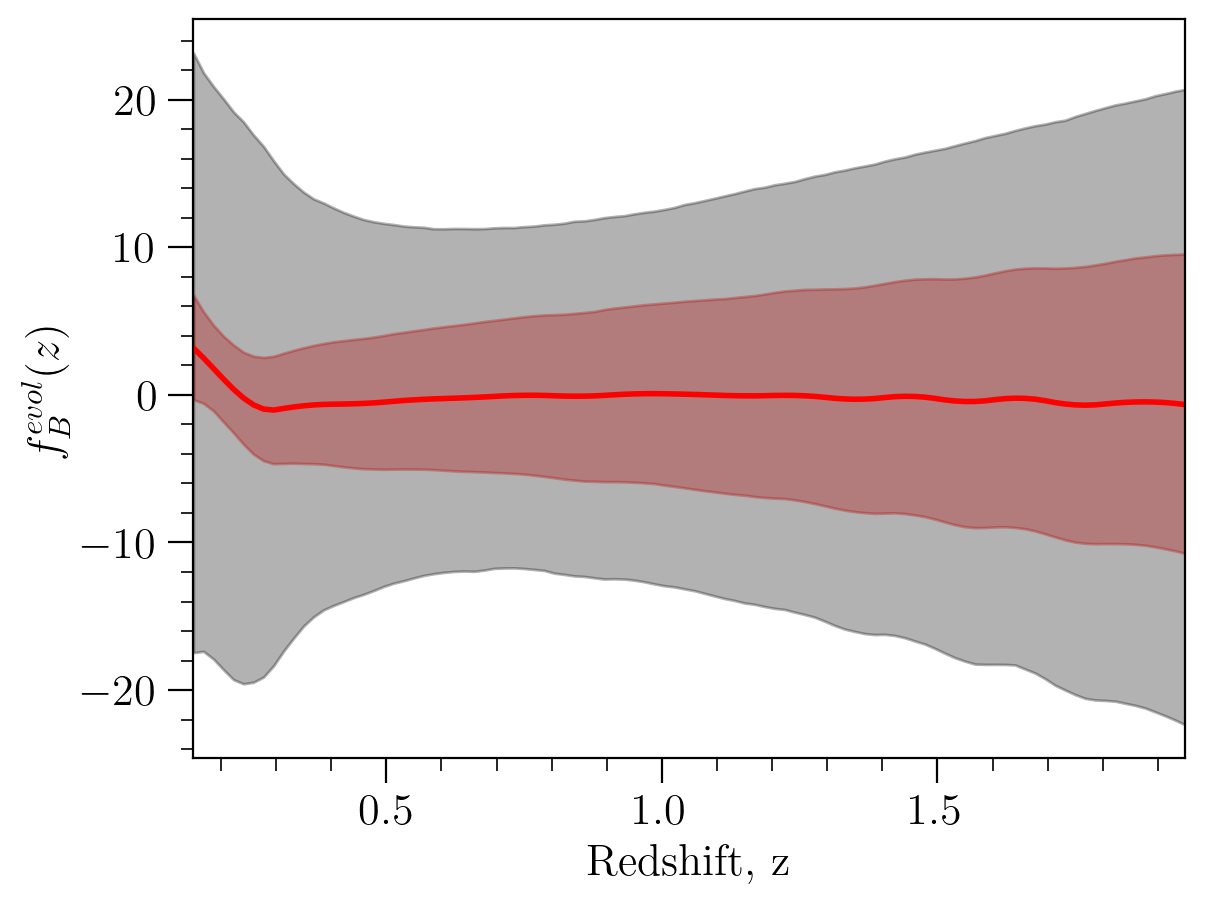

In [152]:
plt.plot(z_lin, fevol_B_fid, '-', color='red', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_noct, fevol_B_upper_bound_noct, color='red', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')

Text(0, 0.5, '$f^{evol}_F(z)$')

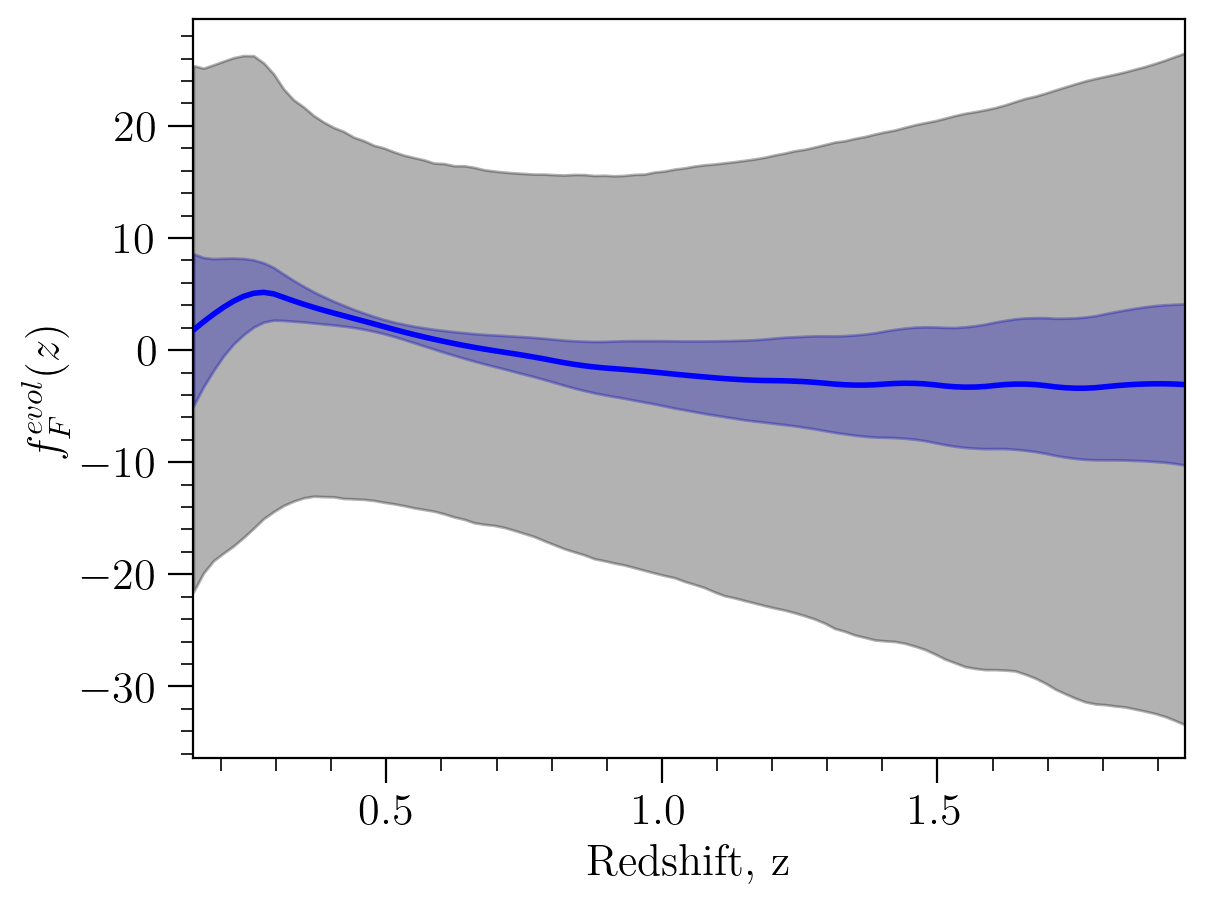

In [153]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_F_lower_bound_noct, fevol_F_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.3)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_F(z)$')

## NO DIPOLE

In [34]:
# Create the Cov Matrix for sB, sF, nevol

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

sB_4fit = np.array([-0.90110744,  1.82300203, -1.01878439, -0.30342324])
sF_4fit = np.array([-0.19376095,  1.0747336,  -0.07806247, -0.00558005])
nevol_fid = np.array([7.94599875, -12.03752387,   2.29927261, -15.83887369])

num_fit = nevol_fid

dsB_19bins = sB_4fit * errB[0] 
dsF_19bins = sF_4fit * errF[0]

dnum_19bins = num_fit * errB[1]

Cov_all_19bins = np.diag(np.concatenate([dsB_19bins**2, dsF_19bins**2, dnum_19bins**2]))

Inv_Cov_all_19bins = np.linalg.inv(Cov_all_19bins)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_fit_all), len(dsignal_dtheta_fit_all)])

Inv_Cov_prior_all[:len(Inv_Cov_all_19bins), :len(Inv_Cov_all_19bins)] = Inv_Cov_all_19bins

np.shape(Cov_all_19bins)

(12, 12)

In [35]:
Cov_multipoles_19bins = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50,50])

np.shape(Cov_multipoles_19bins), type(Cov_multipoles_19bins)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 

Population splitted in 50% BRIGHT - 50% FAINT 


 ... Success! ... 



((19, 324, 324), list)

In [36]:
# REMOVE DIPOLE

Cov_ndip_19bins = np.delete(Cov_multipoles_19bins, index_dipole, axis=1)
Cov_ndip_19bins = np.delete(Cov_ndip_19bins, index_dipole, axis=2)

np.shape(Cov_ndip_19bins)

(19, 288, 288)

In [37]:
Inv_Cov_multipoles_ndip_19bins = [np.linalg.inv(Cov_ndip_19bins[k]) for k,_ in enumerate(z_bins)]

Fisher_Matrix_ndip_perbin_noprior = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_ndip, inv_cov = Inv_Cov_multipoles_ndip_19bins, z_bins = z_bins, bins=True)
Fisher_Matrix_ndip_perbin = Fisher_Matrix_ndip_perbin_noprior + Inv_Cov_prior_all

np.shape(Fisher_Matrix_ndip_perbin_noprior)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(19, 21, 21)

In [39]:
np.diag(Inv_Cov_prior_all)

array([4.92614102e+00, 1.20360972e+00, 3.85385550e+00, 4.34472515e+01,
       1.06543628e+02, 3.46304662e+00, 6.56410340e+02, 1.28464701e+05,
       6.33523904e-02, 2.76048676e-02, 7.56622165e-01, 1.59445182e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [40]:
# Pick the s_{M,3} terms

for k,z in enumerate(z_bins):
    print(r'$z$ = '+str(z), r'$F_{s_{M,3}}$ = ', Fisher_Matrix_ndip_perbin_noprior[k,7,7])

$z$ = 0.15 $F_{s_{M,3}}$ =  699.7596096860516
$z$ = 0.25 $F_{s_{M,3}}$ =  491.2810206690172
$z$ = 0.35 $F_{s_{M,3}}$ =  185.10463226895098
$z$ = 0.45 $F_{s_{M,3}}$ =  57.1635111203166
$z$ = 0.55 $F_{s_{M,3}}$ =  14.434476890658907
$z$ = 0.65 $F_{s_{M,3}}$ =  2.9487215805671805
$z$ = 0.75 $F_{s_{M,3}}$ =  0.4132308843317473
$z$ = 0.85 $F_{s_{M,3}}$ =  0.03048012819537292
$z$ = 0.95 $F_{s_{M,3}}$ =  0.00019478462498180994
$z$ = 1.05 $F_{s_{M,3}}$ =  0.00010246377647048175
$z$ = 1.15 $F_{s_{M,3}}$ =  0.0043150069246517125
$z$ = 1.25 $F_{s_{M,3}}$ =  0.01644132780407652
$z$ = 1.35 $F_{s_{M,3}}$ =  0.03169051516177802
$z$ = 1.45 $F_{s_{M,3}}$ =  0.039452573663458584
$z$ = 1.55 $F_{s_{M,3}}$ =  0.041553957495881005
$z$ = 1.65 $F_{s_{M,3}}$ =  0.03382830745959561
$z$ = 1.75 $F_{s_{M,3}}$ =  0.025751930018443586
$z$ = 1.85 $F_{s_{M,3}}$ =  0.015692575699956586
$z$ = 1.95 $F_{s_{M,3}}$ =  0.008643758326535134


In [42]:
# Open the file in write mode
with open('data/Fisher_sM3_octupole.txt', 'w') as f:
    # Iterate over the z_bins and print the formatted string to the file
    for k, z in enumerate(z_bins):
        f.write(r'$z$ = ' + str(z) + ' ' + r'$F_{s_{M,3}}$ = ' + str(Fisher_Matrix_ndip_perbin_noprior[k, 7, 7]) + '\n')

In [43]:
# Open the file in write mode
with open('data/Fisher_sM3_dipole.txt', 'w') as f:
    # Iterate over the z_bins and print the formatted string to the file
    for k, z in enumerate(z_bins):
        f.write(r'$z$ = ' + str(z) + ' ' + r'$F_{s_{M,3}}$ = ' + str(Fisher_Matrix_noct_perbin_noprior[k, 7, 7]) + '\n')

In [22]:
Inv_Cov_multipoles_ndip_19bins = [np.linalg.inv(Cov_ndip_19bins[k]) for k,_ in enumerate(z_bins)]

Fisher_Matrix_multipoles_ndip_19bins = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_ndip, inv_cov = Inv_Cov_multipoles_ndip_19bins, z_bins = z_bins)
Fisher_Matrix_ndip_19bins = Fisher_Matrix_multipoles_ndip_19bins + Inv_Cov_prior_all

Sigma_Matrix_ndip_19bins = np.linalg.inv(Fisher_Matrix_ndip_19bins)

np.shape(Sigma_Matrix_ndip_19bins)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [23]:
np.savetxt('data/Fisher_Octupole.txt',X=Fisher_Matrix_ndip_19bins, fmt='%.5e')

#### Compare FISHER MATRICES

In [24]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_noct_19bins[:8,:8]]))

19248.1348609451	10485.111490041148	-16601.15712639442	25461.30993259978	-21867.666063493933	-16612.78857592121	4896.8166356264755	4651.554741355759
10485.111490041152	8142.671519885111	-4115.01818750247	5232.429320125203	-16612.788575921215	-13288.433170336022	4538.707703987757	-2418.965711324831
-16601.157126394446	-4115.018187502469	25465.16378810455	-43629.550115571656	4896.816635626464	4538.707703987757	4651.554741355784	-19760.418953047152
25461.309932599786	5232.429320125196	-43629.55011557158	79628.01224009688	4651.5547413557615	-2418.9657113248345	-19760.4189530471	45941.505485405905
-21867.66606349393	-16612.788575921215	4896.816635626463	4651.55474135579	63600.394234512496	34490.78164284061	-46852.46065017421	51407.688201198485
-16612.788575921215	-13288.433170336022	4538.7077039877595	-2418.965711324836	34490.781642840615	23616.452810167157	-16837.41785556072	16219.890950496912
4896.816635626467	4538.707703987757	4651.554741355776	-19760.418953047138	-46852.46065017422	-168

In [25]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_ndip_19bins[:8,:8]]))

549.6699270239378	238.70697504061388	-600.0393182726376	972.9962563324683	-340.1939451888758	-264.9224715206003	33.702294474873675	206.47609636453754
238.70697504061388	160.82824107794474	-137.23795376133597	180.41260005629746	-264.92247152060025	-200.39736374871106	81.0049124521226	-25.972976202987454
-600.039318272638	-137.23795376133603	976.8501118371981	-1726.8647594130398	33.702294474873334	81.00491245212257	206.47609636453802	-596.970935196572
972.9962563324683	180.41260005629746	-1726.8647594130382	3231.9743613511814	206.47609636453757	-25.97297620298746	-596.9709351965714	1298.2134407418841
-340.1939451888755	-264.92247152060025	33.70229447487334	206.47609636453802	961.4414623574036	436.8266100780365	-682.5931563774473	771.8902561837644
-264.9224715206003	-200.39736374871106	81.00491245212262	-25.972976202987496	436.8266100780364	283.63028515806957	-240.60509715879292	231.95414781544042
33.70229447487342	81.00491245212258	206.476096364538	-596.9709351965721	-682.5931563774473	-

#### Compare SIGMA MATRICES

In [26]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_noct_19bins[:12,:12]]))

0.11004701923301766	-0.03115462384700538	0.07392851059248307	0.012802799421606822	0.0029063809106694874	0.03886017380515721	0.0004885530356680103	-1.2230068911377249e-05	0.11386140705928309	0.40057817926234324	-0.09363910616522308	-0.13968805341922083
-0.031154623847042526	0.13307566359700812	-0.03054838993040765	-0.010769212830856965	-0.004610672432541547	0.0939574034539684	0.0003135372307321442	2.9664987453688777e-06	-0.2118563251085859	-0.8312971040778436	-0.06664465232863812	0.33457172693236825
0.07392851059247196	-0.030548389930384758	0.07213886250753346	0.018833221836033812	-0.0010341963831769676	0.032209006620034134	0.00019961058214404062	4.878664387572689e-06	-0.10610511098026114	0.03067557148483442	0.04216219569238297	-0.31657476622379027
0.012802799421602807	-0.01076921283085463	0.01883322183603166	0.006310917744621319	-0.0009602842672239407	0.005142848708953081	-3.463647748240937e-05	4.642626502775305e-06	-0.06519729468904104	-0.05922629252869271	0.03343439057442531	-0.09543

In [27]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_ndip_19bins[:12,:12]]))

0.11346907452074145	-0.08096448392179494	0.06954547818062558	0.007738090886492663	0.001444936511869947	0.027800549032691226	0.00046241525958537575	-8.93114712850743e-06	0.0	0.0	0.0	0.0
-0.08096448392179446	0.2105337547783848	-0.05503055616359689	-0.01420137811821617	-0.013219298967001013	0.1117194398395493	0.00447320649271213	-2.6569774101126687e-05	-0.0	-0.0	-0.0	-0.0
0.06954547818062544	-0.05503055616359843	0.07403561057695293	0.022089541035952596	-0.0027911509371620702	0.011819986507885759	0.0006661851269778356	-1.4447868626385266e-06	0.0	0.0	0.0	0.0
0.007738090886492357	-0.014201378118215664	0.022089541035952315	0.010669132429383374	-0.0015964859316841768	-0.005511949742518406	0.00019775126495924546	6.052285816423908e-07	0.0	0.0	0.0	0.0
0.0014449365118696653	-0.013219298966999688	-0.00279115093716245	-0.0015964859316842381	0.006381419296676996	-0.016563060169992157	0.0007081039714512719	-4.685925727232881e-06	0.0	0.0	0.0	0.0
0.027800549032690105	0.11171943983955067	0.01181998650788

In [28]:
# Remove the large F S_{M,3} value

nindex = [7]

Fisher_Matrix_ndip_19bins_ = np.delete(Fisher_Matrix_ndip_19bins, obj=nindex, axis=0)
Fisher_Matrix_ndip_19bins_ = np.delete(Fisher_Matrix_ndip_19bins_, obj=nindex, axis=1)

Sigma_Matrix_ndip_19bins_ = np.linalg.inv(Fisher_Matrix_ndip_19bins_)

np.shape(Fisher_Matrix_ndip_19bins_)


(20, 20)

In [29]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_ndip_19bins_[:11,:11]]))

0.11345881532252514	-0.0809950045900956	0.0695438185556535	0.007738786111853463	0.0014395537944909146	0.02777212762437382	0.0004638315156670775	0.0	0.0	0.0	0.0
-0.08099500459009468	0.21044295711818753	-0.055035493475677474	-0.014199309853017258	-0.01323531231699248	0.11163488738647126	0.004477419792931566	-0.0	-0.0	-0.0	-0.0
0.0695438185556532	-0.055035493475677565	0.07403534210031475	0.022089653502184874	-0.0027920216964546617	0.011815388791962764	0.000666414233961726	0.0	0.0	0.0	0.0
0.007738786111853116	-0.014199309853017589	0.022089653502184708	0.010669085316705313	-0.0015961211661779152	-0.005510023735882172	0.00019765529087584474	0.0	0.0	0.0	0.0
0.0014395537944906713	-0.013235312316993235	-0.002792021696454756	-0.0015961211661779538	0.006378595133835829	-0.01657797209636868	0.0007088470418221953	0.0	0.0	0.0	0.0
0.027772127624375288	0.1116348873864698	0.01181538879196351	-0.005510023735881468	-0.01657797209636775	0.13294168658975225	0.0034742178689592448	-0.0	-0.0	-0.0	-0.0
0.00046

In [30]:
# Remove the large F S_{M,3} value

nindex = [7]

Fisher_Matrix_noct_19bins_ = np.delete(Fisher_Matrix_noct_19bins, obj=nindex, axis=0)
Fisher_Matrix_noct_19bins_ = np.delete(Fisher_Matrix_noct_19bins_, obj=nindex, axis=1)

Sigma_Matrix_noct_19bins_ = np.linalg.inv(Fisher_Matrix_noct_19bins_)

np.shape(Fisher_Matrix_noct_19bins_)

(20, 20)

In [31]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_noct_19bins_[:11,:11]]))

0.11002779292722333	-0.031149960356381536	0.0739361801071756	0.012810097872450568	0.0029057957763535974	0.03885584897965101	0.0004890564103601413	0.1138101834198624	0.4006434807547619	-0.09370610467027733	-0.1400318519053499
-0.031149960356364616	0.13307453243095943	-0.030550250231100317	-0.010770983127122545	-0.0046105305036473485	0.09395845247421648	0.0003134151332684271	-0.2118439004146758	-0.8313129434648151	-0.06662840131805943	0.33465511794123814
0.07393618010716799	-0.03055025023109961	0.07213580308173599	0.018830310430341755	-0.0010339629687959886	0.032210731824686104	0.00019940978227912917	-0.10608467749388269	0.03064952223967757	0.04218892188854888	-0.31643762248061363
0.012810097872446274	-0.010770983127119932	0.01883031043033998	0.006308147197572632	-0.0009600621458188571	0.005144490445353873	-3.482756231635045e-05	-0.06517784980870901	-0.05925108146819578	0.0334598237128323	-0.09530217754290404
0.0029057957763548854	-0.0046105305036363495	-0.0010339629687971742	-0.00096006

In [32]:
# Print Fisher ELEMENTS 

import pandas as pd

row_names = {
    0: r"$s_{B,0}$",
    1: r"sB_1",
    2: r"sB_2",
    3: r"sB_3",
    4: r"sM_0",
    5: r"sM_2",
    6: r"sM_3",
    7: r"sM_4"
}

fisher_s = {
    "DIPOLE" : np.diag(Fisher_Matrix_noct_19bins[:8,:8]),
    "OCTUPOLE" : np.diag(Fisher_Matrix_ndip_19bins[:8,:8]),
    "R. Factor" : np.diag(Fisher_Matrix_noct_19bins[:8,:8])/np.diag(Fisher_Matrix_ndip_19bins[:8,:8])
}

df_fisher_s = pd.DataFrame(fisher_s, index=row_names.values())
df_fisher_s = df_fisher_s.apply(pd.Series.round, args=[2])

df_fisher_s

DIPOLE   OCTUPOLE  R. Factor
$s_{B,0}$   19248.13     549.67      35.02
sB_1         8142.67     160.83      50.63
sB_2        25465.16     976.85      26.07
sB_3        79628.01    3231.97      24.64
sM_0        63600.39     961.44      66.15
sM_2        23616.45     283.63      83.26
sM_3        52064.10    1428.30      36.45
sM_4       218872.51  129916.05       1.68

In [33]:
index_labels_ = [name for _,name in enumerate(row_names.values())]

index_labels_

['$s_{B,0}$', 'sB_1', 'sB_2', 'sB_3', 'sM_0', 'sM_2', 'sM_3', 'sM_4']

In [34]:
index_labels = [r'$s_{B,0}$', r'$s_{B,1}$', r'$s_{B,2}$', r'$s_{B,3}$', r'$s_{M,0}$', r'$s_{M,1}$', r'$s_{M,2}$', r'$s_{M,3}$']

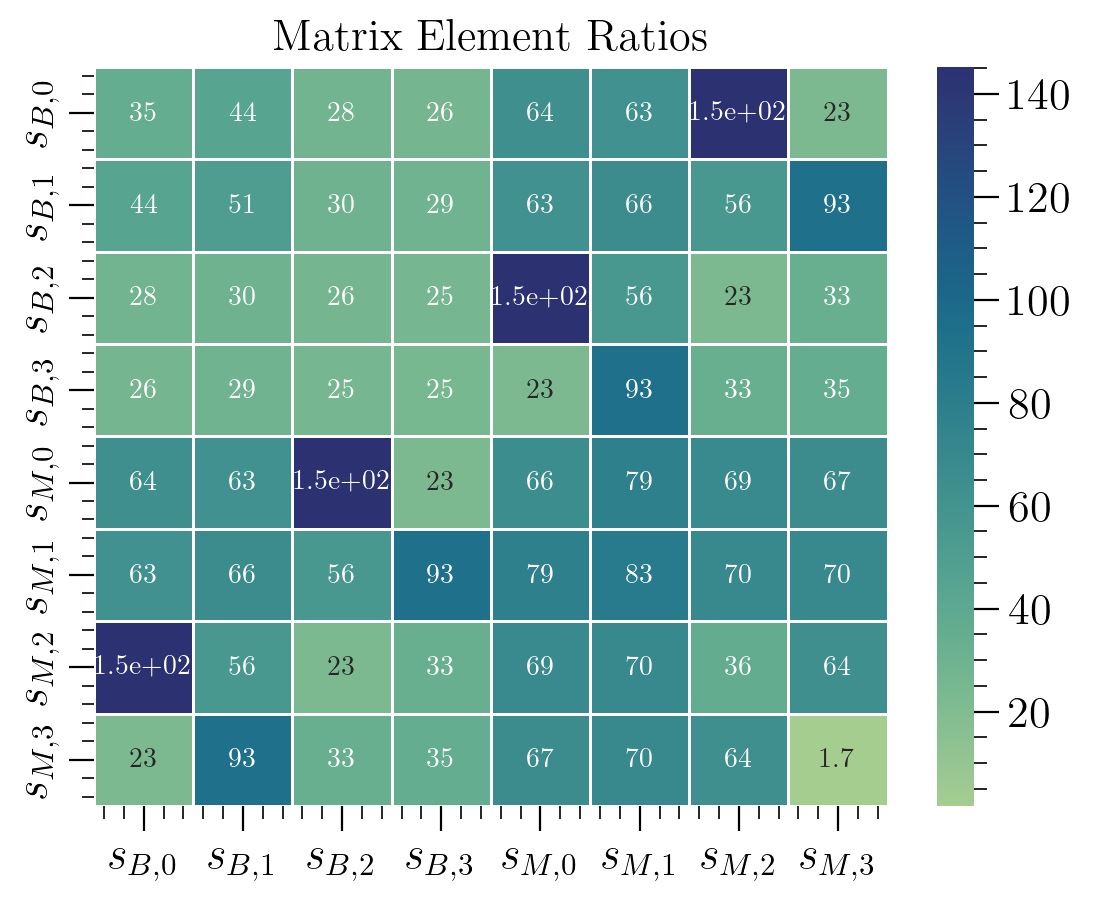

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the element-wise ratio
element_ratio = Fisher_Matrix_noct_19bins[:8,:8] / Fisher_Matrix_ndip_19bins[:8,:8]

# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=True, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Element Ratios")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")
plt.show()

In [36]:
index_labels = [r'$s_{B,0}$', r'$s_{B,1}$', r'$s_{B,2}$', r'$s_{B,3}$', r'$s_{M,0}$', r'$s_{M,1}$', r'$s_{M,2}$', r'$s_{M,3}$', r'$n^{evol}_0$', r'$n^{evol}_1$', r'$n^{evol}_2$', r'$n^{evol}_3$']

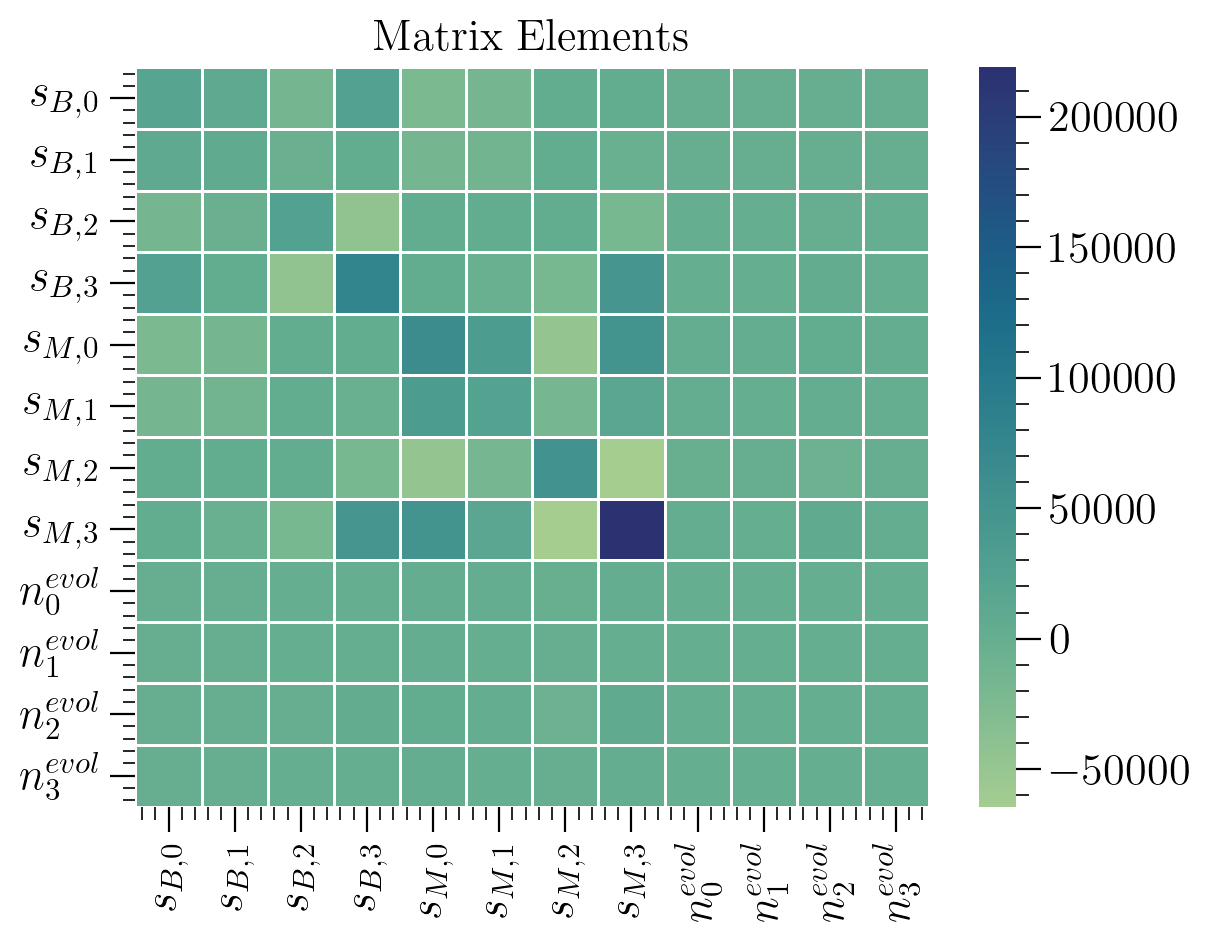

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the element-wise ratio
element_ratio = Fisher_Matrix_noct_19bins[:12,:12]

# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=False, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Elements")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")
plt.show()

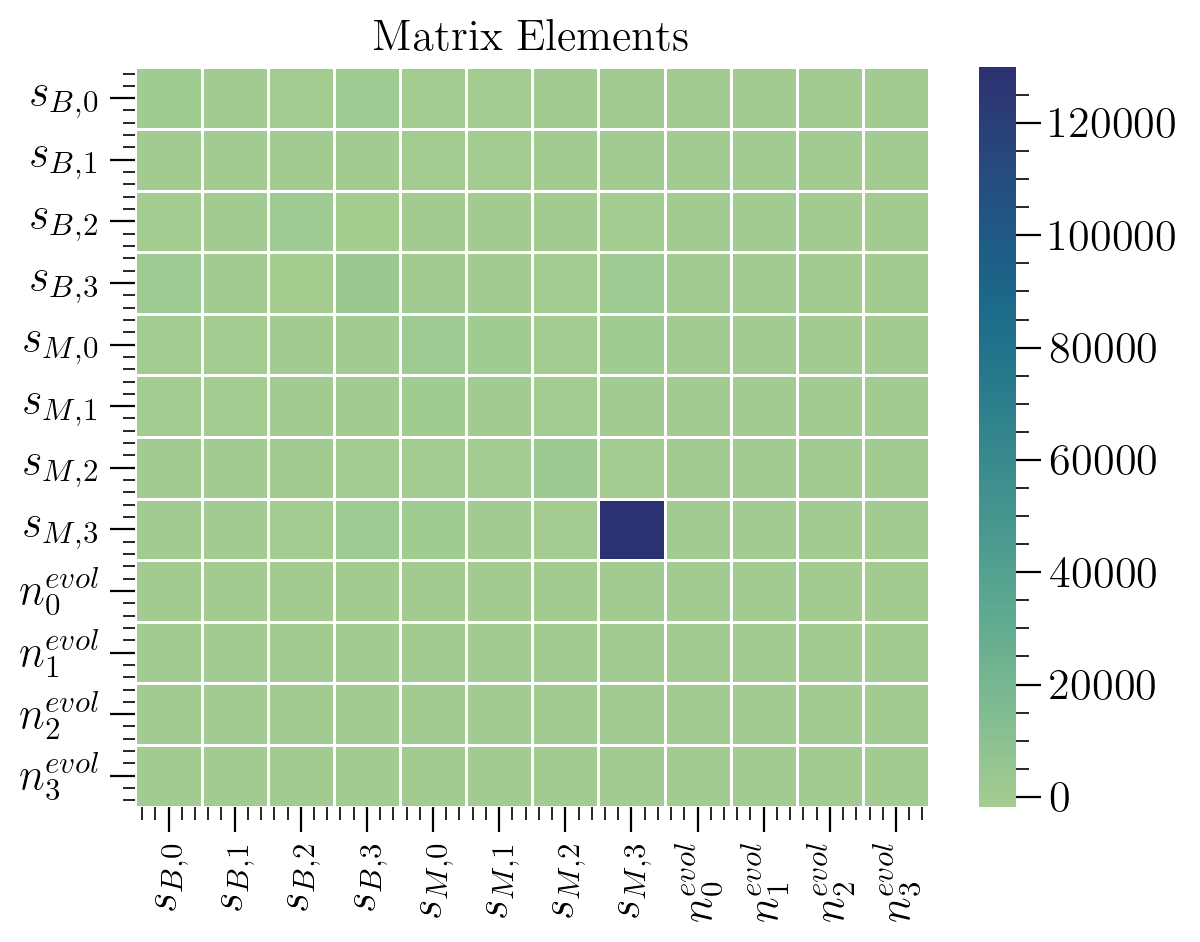

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the element-wise ratio
element_ratio = Fisher_Matrix_ndip_19bins[:12,:12]

# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=False, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Elements")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")
plt.show()

#### Constraints

In [39]:
#Absolute Errors

Abs_Errors_ndip_19bins = np.sqrt(np.diag(Sigma_Matrix_ndip_19bins))

# Fiducial values

sbias_fid = np.concatenate([sB_4fit, sF_4fit])
num_fid = num_fit
gbias_fid = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sbias_fid, num_fid, gbias_fid, cosmic_fid])

# Relative errors

Rel_Errors_ndip_19bins = np.abs(Abs_Errors_ndip_19bins/params_fid)

params_errors_ndip_19bins = Rel_Errors_ndip_19bins * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sbias = ', params_errors_ndip_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])
print()
print('gbias = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)+len(gbias_fid)):])


------------ Relative errors * 100 ------------

sbias =  [37.38196968 25.16944943 26.70779593 34.04205048 41.22801121 33.93581911
 46.99367568 49.97035594]

number =  [50. 50. 50. 50.]

gbias =  [0.42787711 0.36848222 0.14149093 0.27933741]

cosmic =  [1.10551549 0.70862343 0.8994093  1.13039699 0.49670653]


#### Predictions

##### Magnification bias

###### Compare the two observables

In [165]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_ndip = Sigma_Matrix_ndip_19bins[:4, :4]
cov_sM_ndip = Sigma_Matrix_ndip_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_ndip = np.random.multivariate_normal(sB_4fit, cov_sB_ndip, num_samples)
sM_pars_samples_ndip = np.random.multivariate_normal(sF_4fit, cov_sM_ndip, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_ndip = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_ndip])
sM_samples_ndip = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_ndip])

# Calculate the 68% confidence interval
sB_lower_bound_ndip = np.percentile(sB_samples_ndip, 16, axis=0)
sB_upper_bound_ndip = np.percentile(sB_samples_ndip, 84, axis=0)
sM_lower_bound_ndip = np.percentile(sM_samples_ndip, 16, axis=0)
sM_upper_bound_ndip = np.percentile(sM_samples_ndip, 84, axis=0)

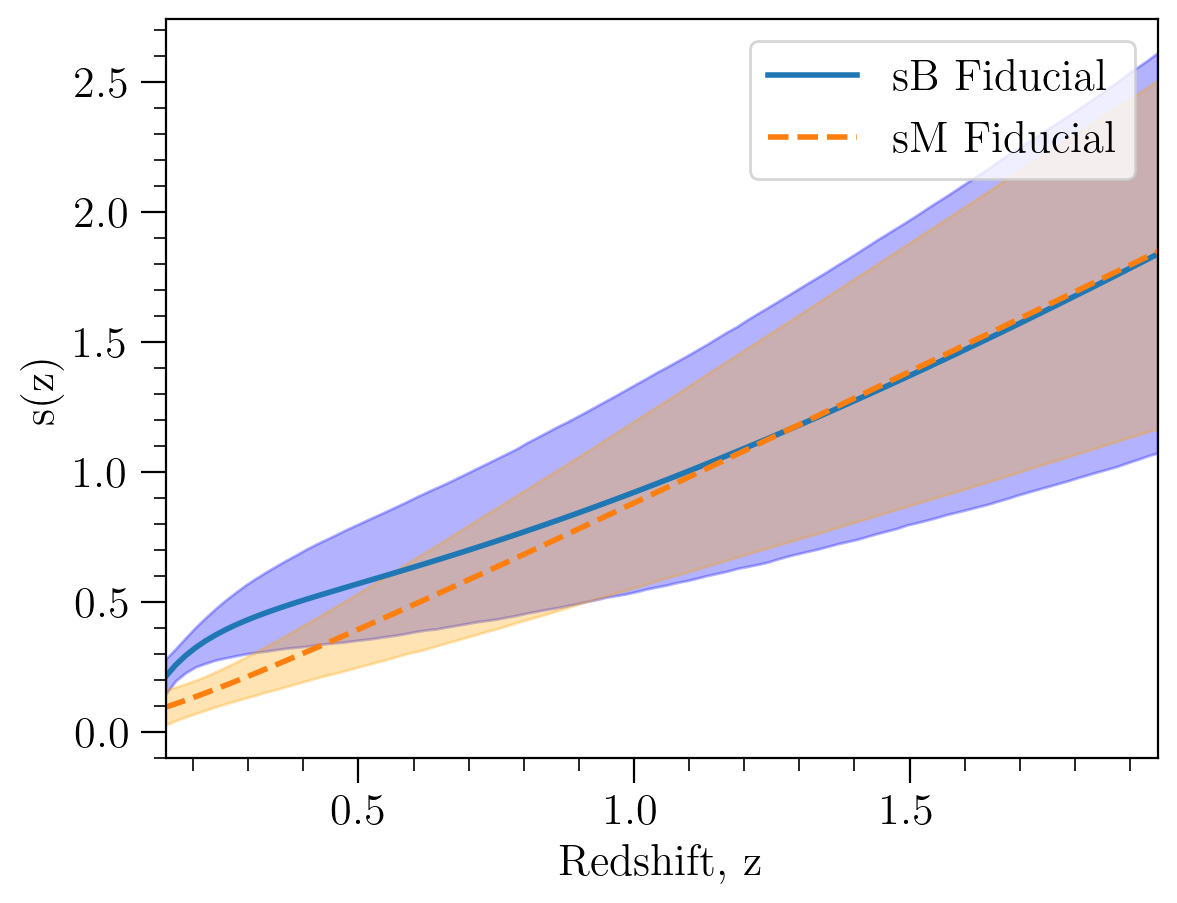

In [166]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0)
plt.plot(z_lin, sM_fid, '--', label=r'sM Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='blue', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='orange', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

###### Compare with priors

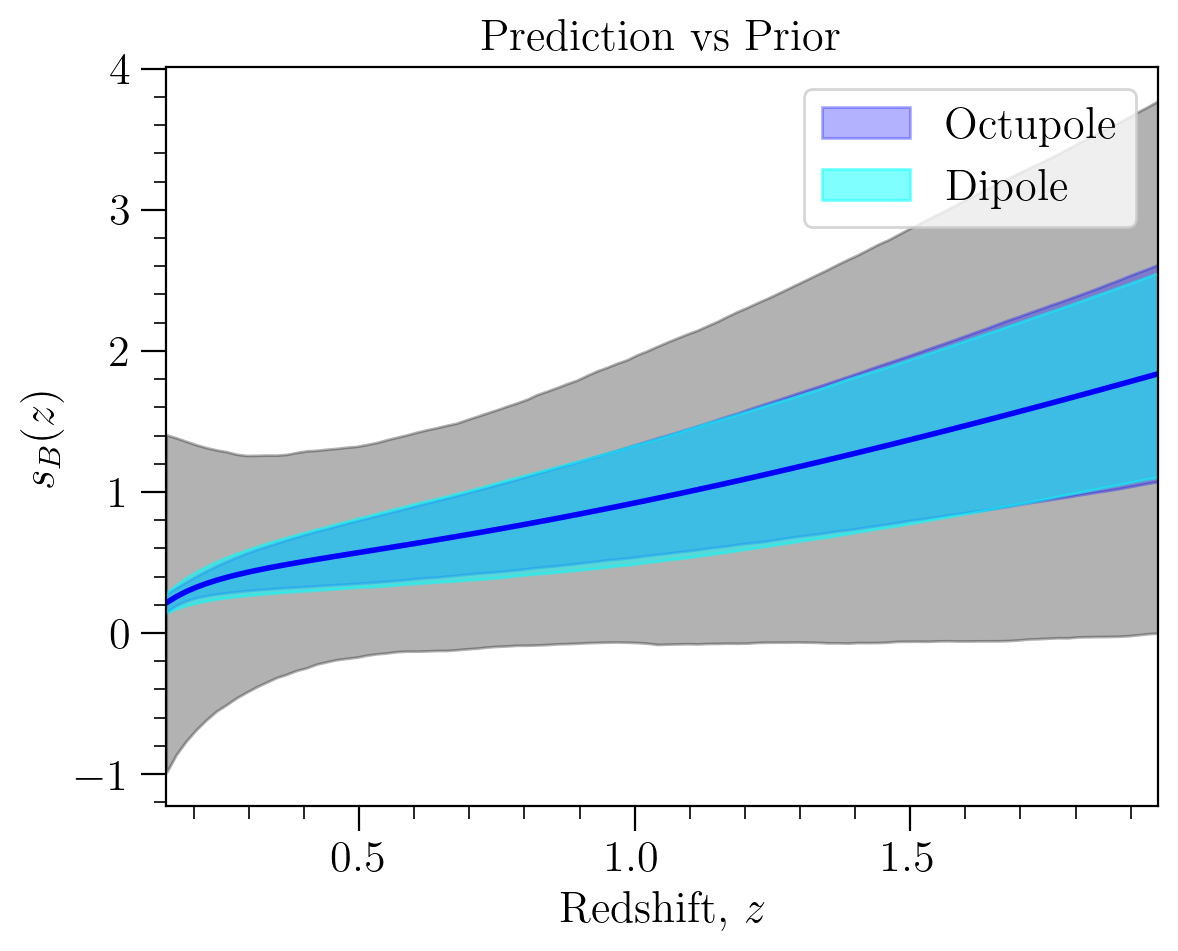

In [167]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='cyan', alpha=0.5, label = 'Dipole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'Prediction vs Prior')
plt.legend();

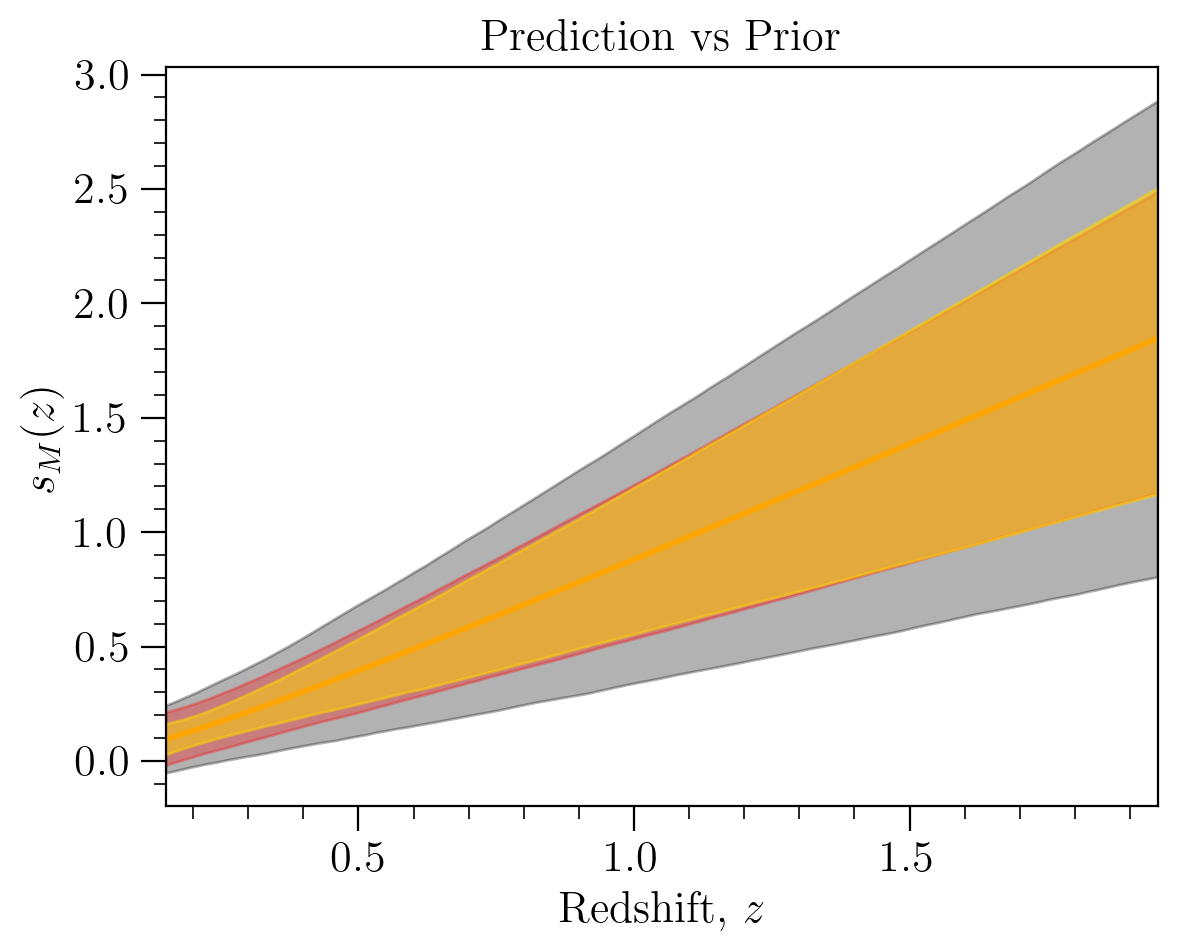

In [168]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='orange')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='red', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='gold', alpha=0.5, label = 'Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'Prediction vs Prior');

###### Magnification bias of the Faint

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [169]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_ndip = Sigma_Matrix_ndip_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sbias_pars_samples_ndip = np.random.multivariate_normal(sbias_fid, cov_sbias_ndip, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_ndip = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_ndip])
sM_samples_ndip = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_ndip])

# Compute the sF for each sample
sF_samples_ndip = sM_samples_ndip*m_split/(m_split-1) - sB_samples_ndip/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_ndip = np.percentile(sF_samples_ndip, 16, axis=0)
sF_upper_bound_ndip = np.percentile(sF_samples_ndip, 84, axis=0)

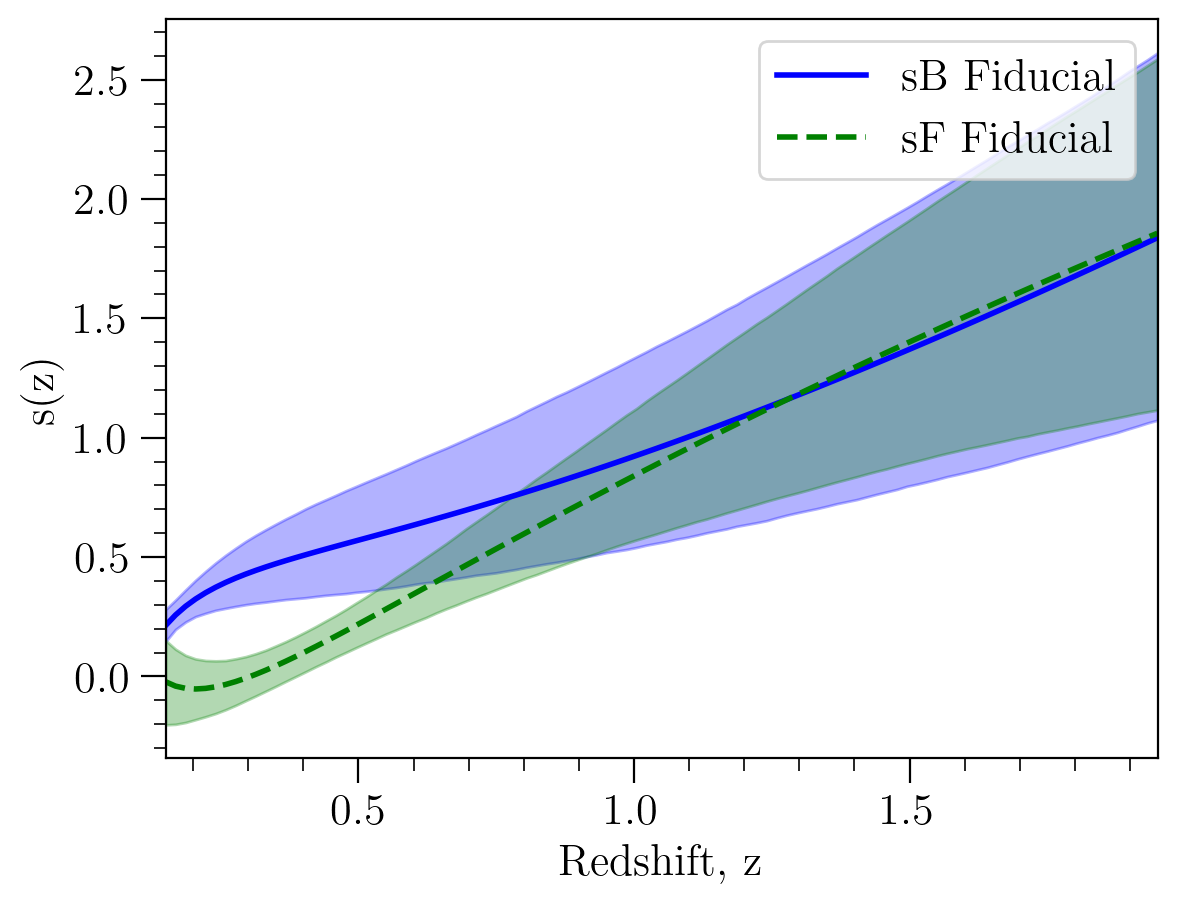

In [170]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='blue')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

Compare with priors

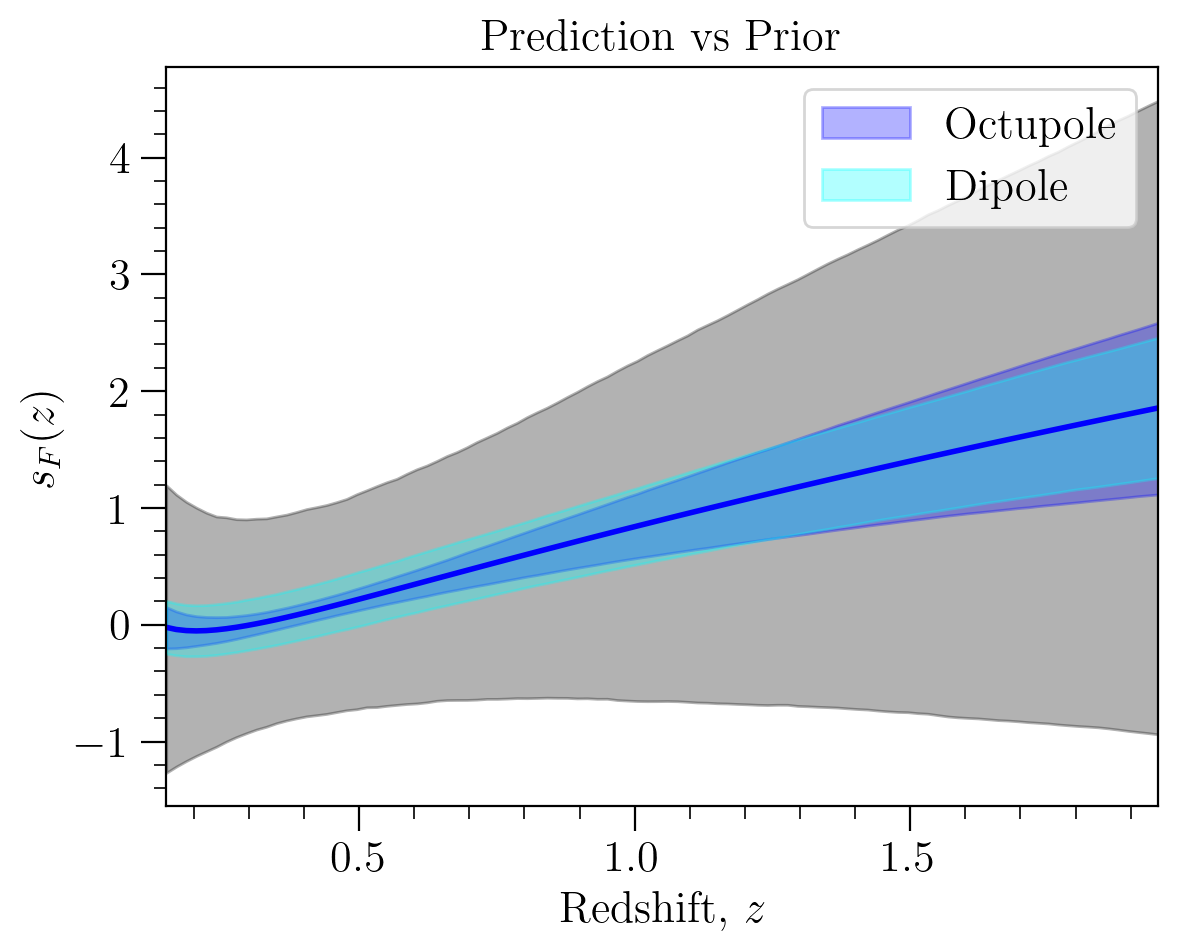

In [184]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='cyan', alpha=0.3, label = 'Dipole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')
plt.legend();

##### Number evolution

In [172]:
# Select the marginalized covariance matrix for the number evolution
cov_numevol_ndip = Sigma_Matrix_ndip_19bins[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
nevol_pars_samples_ndip = np.random.multivariate_normal(nevol_fid, cov_numevol_ndip, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_ndip = np.array([nevol_fit(pars, z_lin) for pars in nevol_pars_samples_ndip])

# Calculate the 68% confidence interval
nevol_lower_bound_ndip = np.percentile(nevol_samples_ndip, 16, axis=0)
nevol_upper_bound_ndip = np.percentile(nevol_samples_ndip, 84, axis=0)

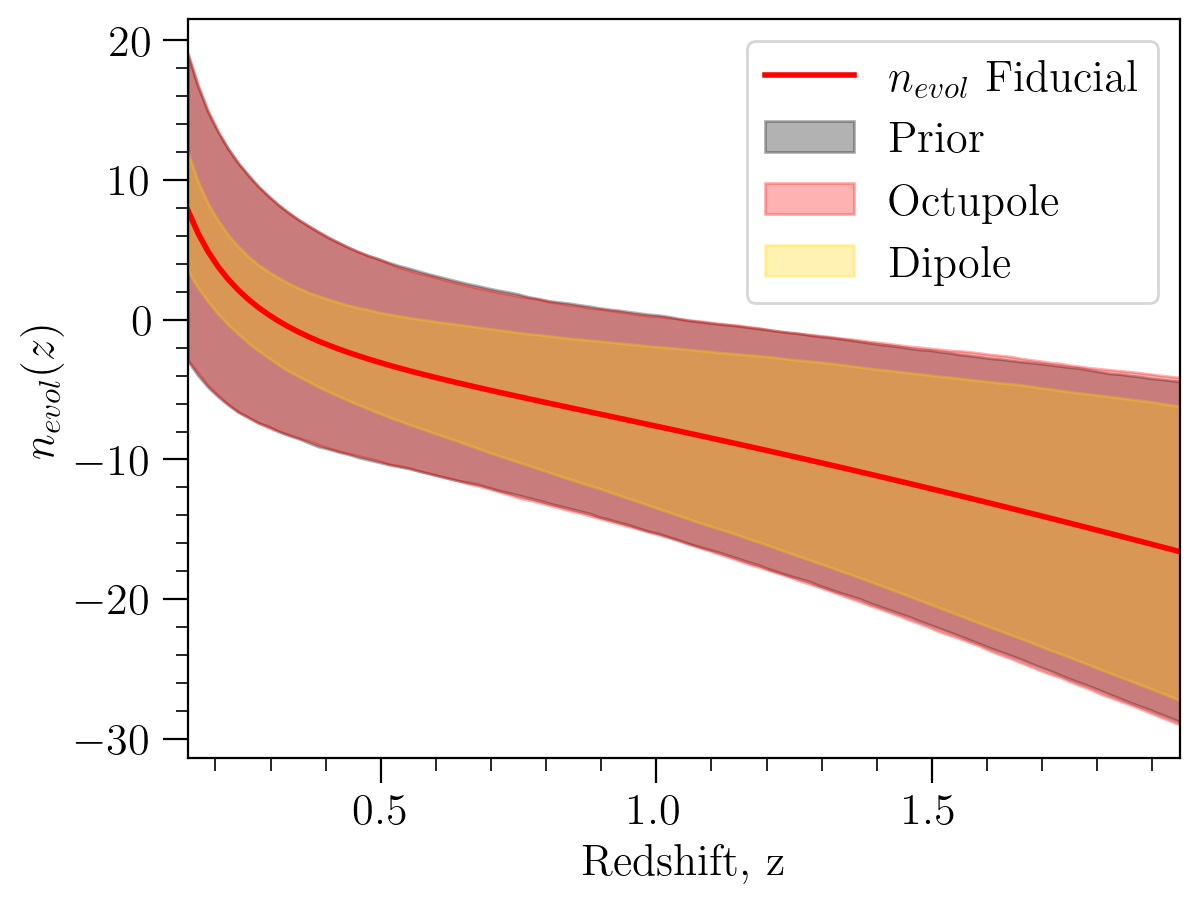

In [182]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
plt.fill_between(z_lin, nevol_lower_bound_ndip, nevol_upper_bound_ndip, color='red', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, nevol_lower_bound_noct, nevol_upper_bound_noct, color='gold', alpha=0.3, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

##### Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [177]:
# Select the marginalized covariance matrix for the number evolution

cov_all_ndip = Sigma_Matrix_ndip_19bins[:12, :12]

all_fid = np.concatenate([sbias_fid, nevol_fid])

# Generate parameter samples from multivariate normal distribution

num_samples = 5000
all_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_all_ndip, num_samples)

# Evaluate fitting function for each parameter sample

fevol_B_samples_ndip = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_ndip])
fevol_F_samples_ndip = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_ndip])

# Calculate the 68% confidence intervals

fevol_B_lower_bound_ndip = np.percentile(fevol_B_samples_ndip, 16, axis=0)
fevol_B_upper_bound_ndip = np.percentile(fevol_B_samples_ndip, 84, axis=0)

fevol_F_lower_bound_ndip = np.percentile(fevol_F_samples_ndip, 16, axis=0)
fevol_F_upper_bound_ndip = np.percentile(fevol_F_samples_ndip, 84, axis=0)

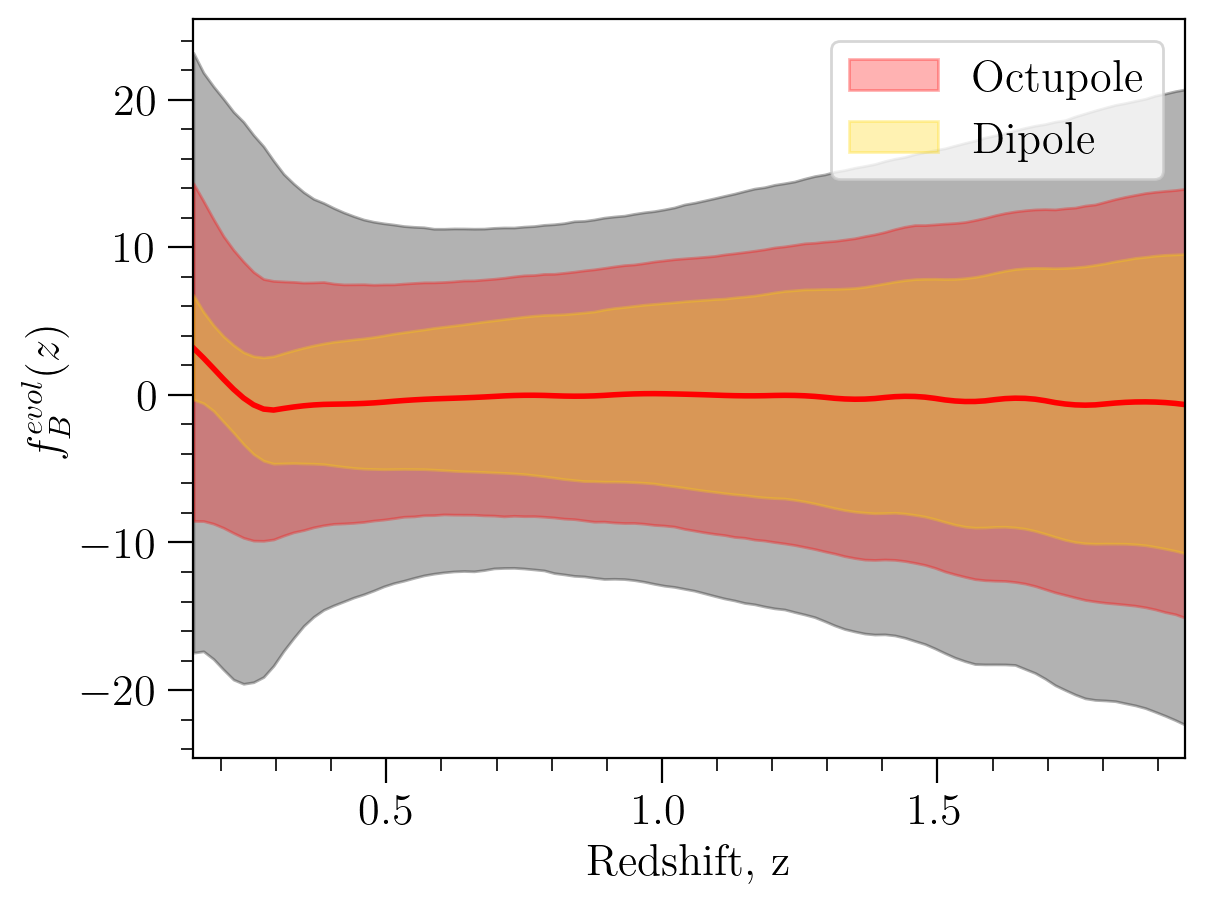

In [180]:
plt.plot(z_lin, fevol_B_fid, '-', color='red', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_ndip, fevol_B_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, fevol_B_lower_bound_noct, fevol_B_upper_bound_noct, color='cyan', alpha=0.5, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')
plt.legend();

Text(0, 0.5, '$f^{evol}_F(z)$')

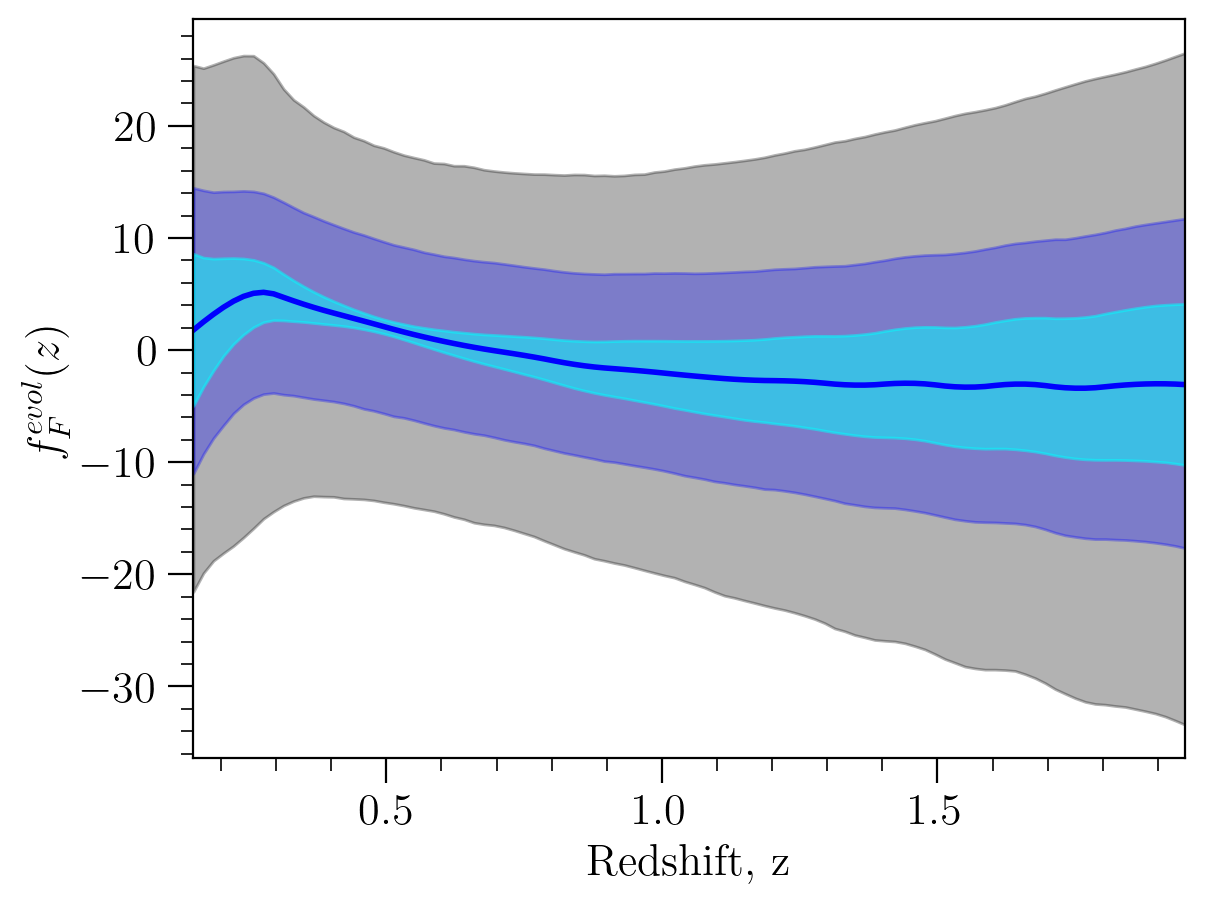

In [181]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 2.0)

# Shade the 68% confidence interval
plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_ndip, fevol_F_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, fevol_F_lower_bound_noct, fevol_F_upper_bound_noct, color='cyan', alpha=0.5, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_F(z)$')

## Compare DIPOLE vs OCTUPOLE when SAMPLING ALL TOGETHER

In [203]:
# Select the marginalized covariance matrix for the magnification biases

cov_ndip = Sigma_Matrix_ndip_19bins[:12,:12]
cov_noct = Sigma_Matrix_noct_19bins[:12,:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 5000

sB_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_ndip, num_samples)
sM_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_ndip, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_ndip = np.array([magbias_fit(pars[:4], z_lin) for pars in sB_pars_samples_ndip])
sM_samples_ndip = np.array([magbias_fit(pars[4:8], z_lin) for pars in sM_pars_samples_ndip])

# Calculate the 68% confidence interval
sB_lower_bound_ndip = np.percentile(sB_samples_ndip, 16, axis=0)
sB_upper_bound_ndip = np.percentile(sB_samples_ndip, 84, axis=0)
sM_lower_bound_ndip = np.percentile(sM_samples_ndip, 16, axis=0)
sM_upper_bound_ndip = np.percentile(sM_samples_ndip, 84, axis=0)

# Generate parameter samples from multivariate normal distribution

sB_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_noct, num_samples)
sM_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_noct, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_noct = np.array([magbias_fit(pars[:4], z_lin) for pars in sB_pars_samples_noct])
sM_samples_noct = np.array([magbias_fit(pars[4:8], z_lin) for pars in sM_pars_samples_noct])

# Calculate the 68% confidence interval
sB_lower_bound_noct = np.percentile(sB_samples_noct, 16, axis=0)
sB_upper_bound_noct = np.percentile(sB_samples_noct, 84, axis=0)
sM_lower_bound_noct = np.percentile(sM_samples_noct, 16, axis=0)
sM_upper_bound_noct = np.percentile(sM_samples_noct, 84, axis=0)

In [204]:
# Compute the sF for each sample
sF_samples_ndip = sM_samples_ndip*m_split/(m_split-1) - sB_samples_ndip/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_ndip = np.percentile(sF_samples_ndip, 16, axis=0)
sF_upper_bound_ndip = np.percentile(sF_samples_ndip, 84, axis=0)

# Compute the sF for each sample
sF_samples_noct = sM_samples_noct*m_split/(m_split-1) - sB_samples_noct/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_noct = np.percentile(sF_samples_noct, 16, axis=0)
sF_upper_bound_noct = np.percentile(sF_samples_noct, 84, axis=0)

In [205]:
nevol_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_ndip, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_ndip = np.array([nevol_fit(pars[8:12], z_lin) for pars in nevol_pars_samples_ndip])

# Calculate the 68% confidence interval
nevol_lower_bound_ndip = np.percentile(nevol_samples_ndip, 16, axis=0)
nevol_upper_bound_ndip = np.percentile(nevol_samples_ndip, 84, axis=0)

nevol_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_noct, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_noct = np.array([nevol_fit(pars[8:12], z_lin) for pars in nevol_pars_samples_noct])

# Calculate the 68% confidence interval
nevol_lower_bound_noct = np.percentile(nevol_samples_noct, 16, axis=0)
nevol_upper_bound_noct = np.percentile(nevol_samples_noct, 84, axis=0)

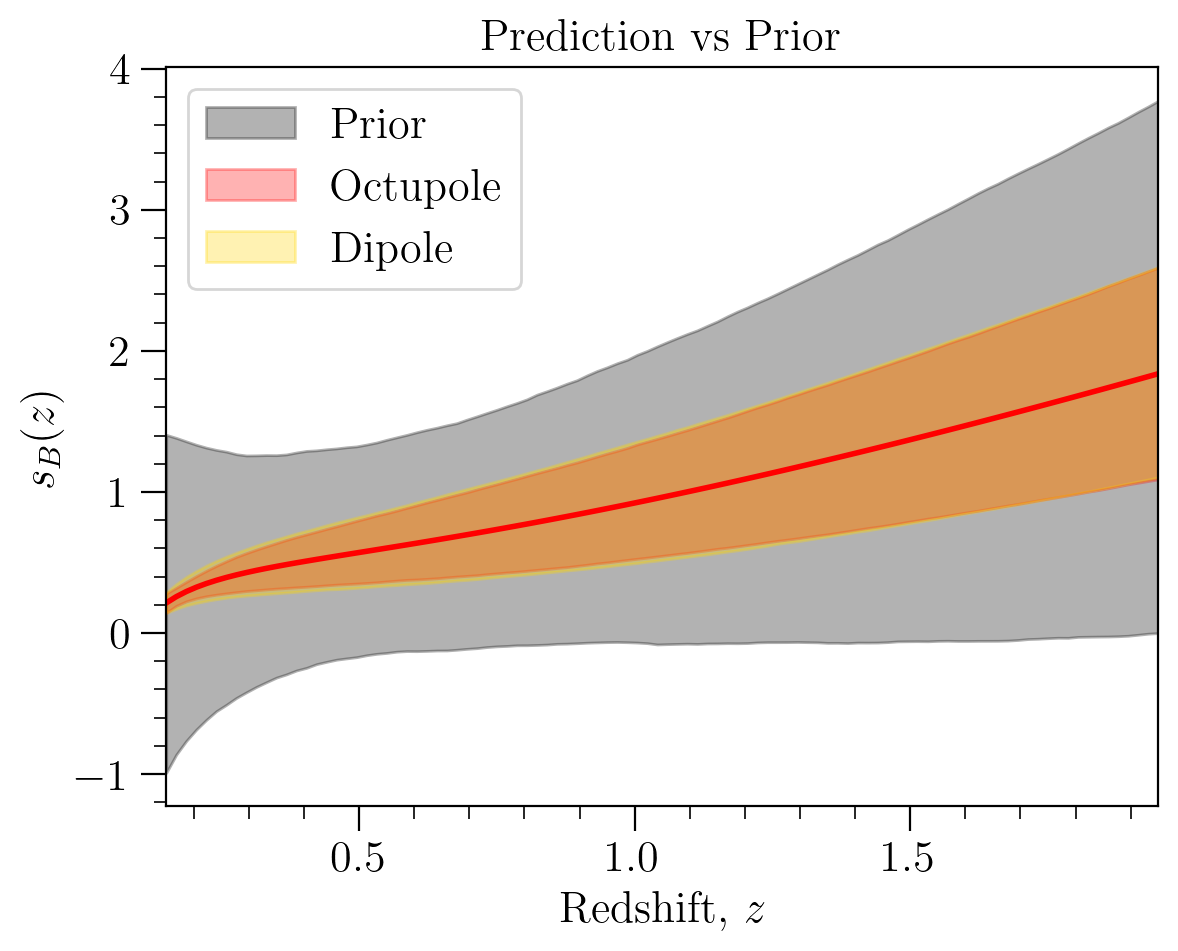

In [206]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='red', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='gold', alpha=0.3, label = 'Dipole')


plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc = 'upper left')

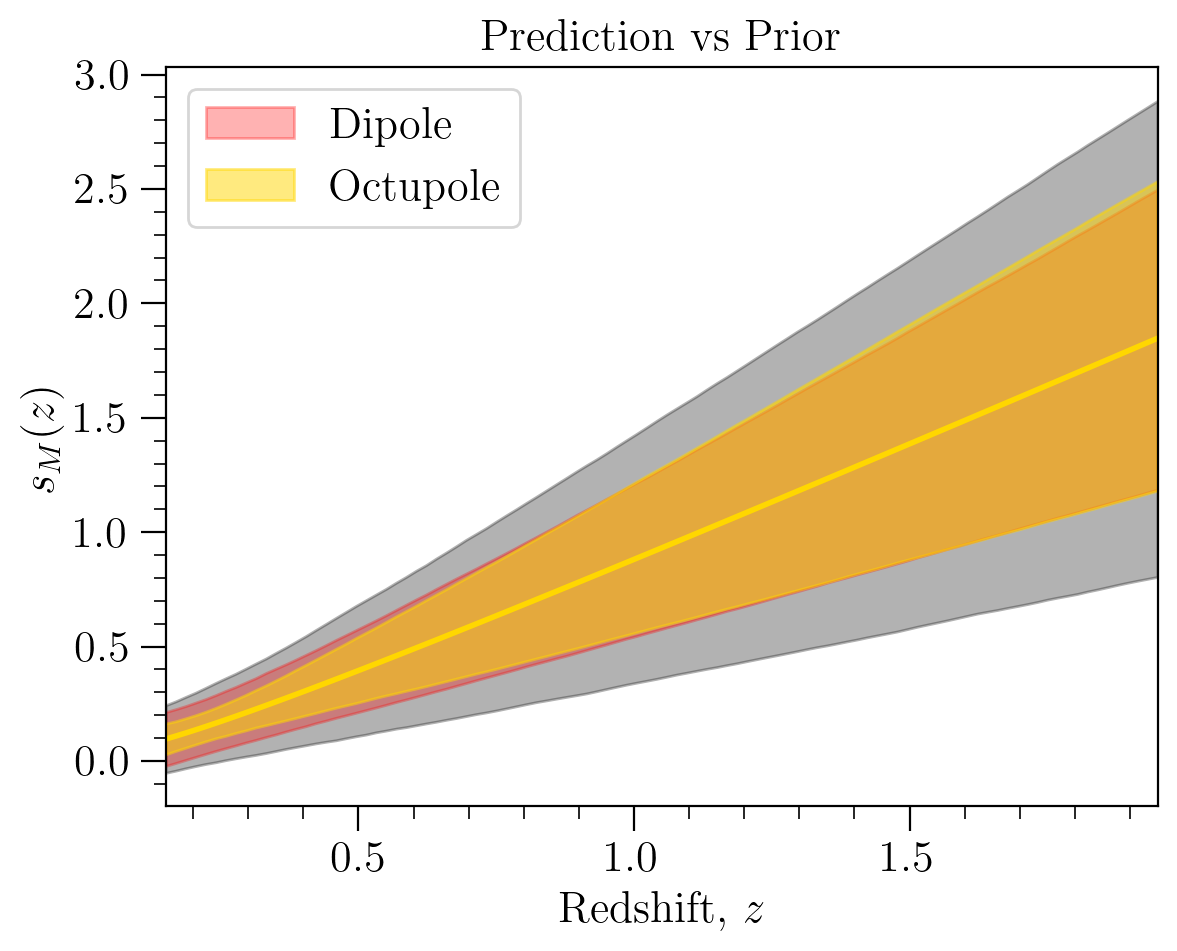

In [207]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='gold')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='red', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='gold', alpha=0.5, label = 'Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'Prediction vs Prior');
plt.legend(loc = 'upper left');

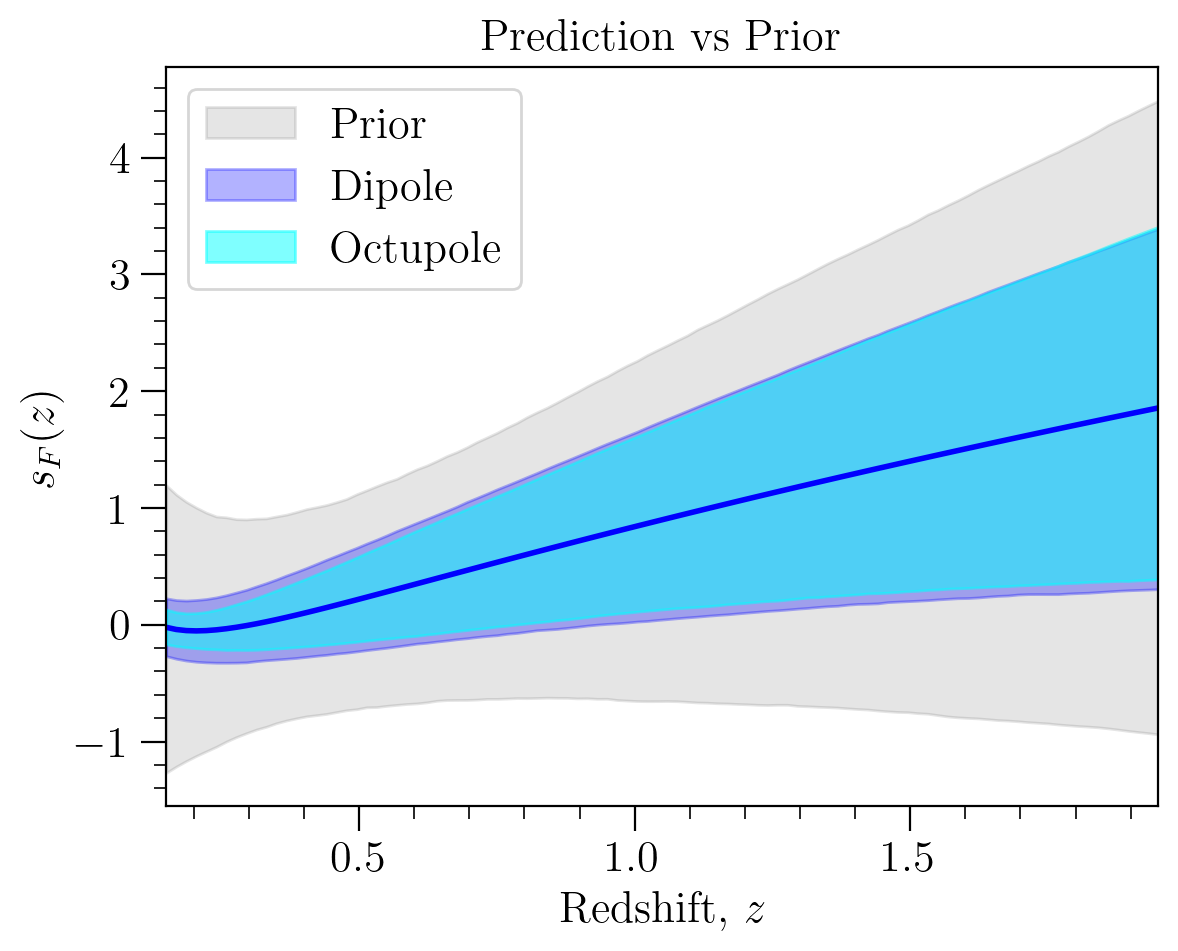

In [208]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.1, label = 'Prior')
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='blue', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='cyan', alpha=0.5, label = 'Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc='upper left');

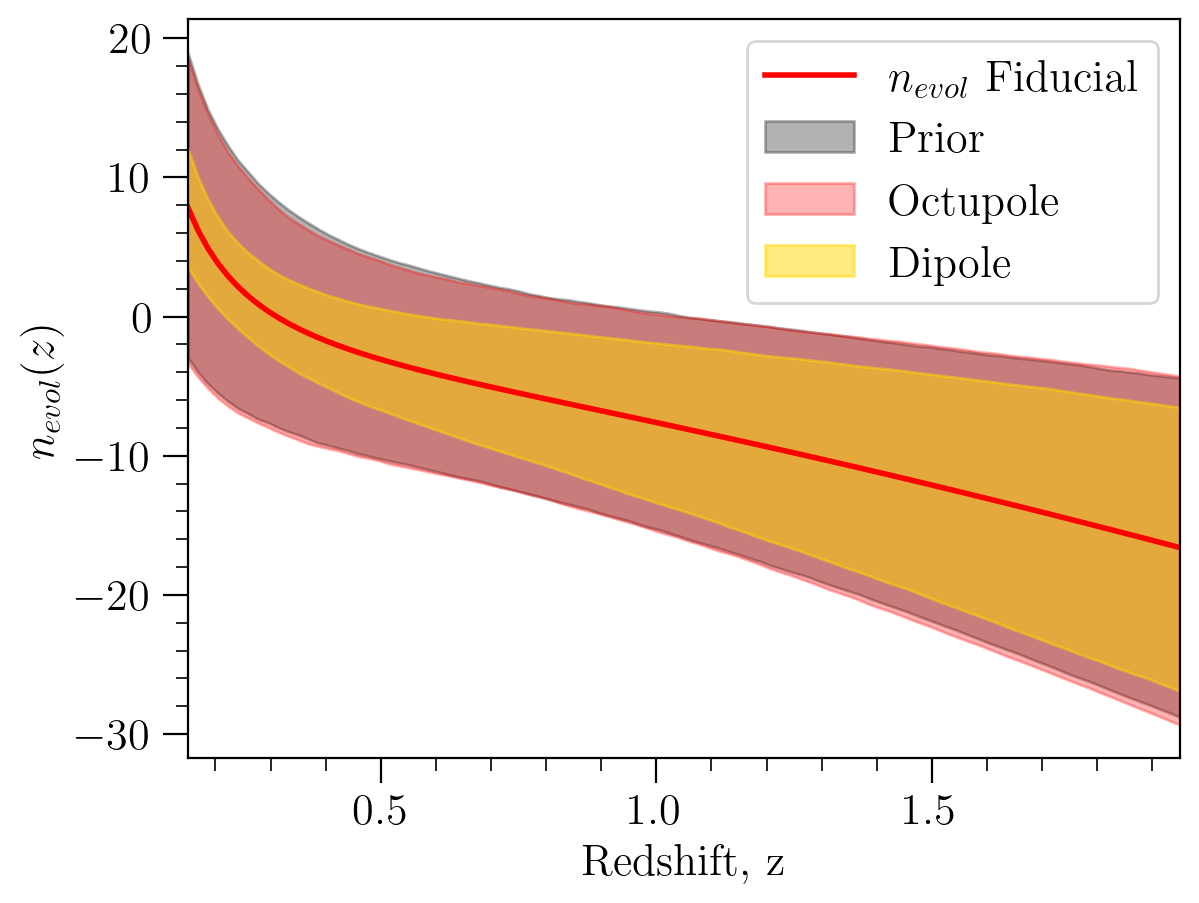

In [210]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
plt.fill_between(z_lin, nevol_lower_bound_ndip, nevol_upper_bound_ndip, color='red', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, nevol_lower_bound_noct, nevol_upper_bound_noct, color='gold', alpha=0.5, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

## Compare DIPOLE vs OCTUPOLE when REMOVING NEVOL from DIPOLE

In [40]:
index_to_remove = list(range(8,12))

index_to_remove

[8, 9, 10, 11]

In [41]:
Fisher_Dipole_ = np.delete(Fisher_Matrix_noct_19bins, index_to_remove, axis = 0)
Fisher_Dipole_ = np.delete(Fisher_Dipole_, index_to_remove, axis = 1)

np.shape(Fisher_Dipole_)

(17, 17)

In [42]:
Sigma_Matrix_Dipole = np.linalg.inv(Fisher_Dipole_)

In [43]:
Fisher_Octupole_ = np.delete(Fisher_Matrix_ndip_19bins, index_to_remove, axis = 0)
Fisher_Octupole_ = np.delete(Fisher_Octupole_, index_to_remove, axis = 1)

np.shape(Fisher_Octupole_)

(17, 17)

In [44]:
Sigma_Matrix_Octupole = np.linalg.inv(Fisher_Octupole_)

In [45]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Dipole[:8,:8]]))

0.07831477105439925	-0.02777120562952132	0.06832634397710435	0.016367678510540943	-0.0040755577449341175	0.03624914322239564	0.0031767854083817066	-3.308991723514041e-05
-0.027771205629522844	0.09321153661373935	-0.02990183664639048	-0.01116755933067021	-0.009578544778831757	0.05238995605939497	0.0012348336196840188	-3.930977100095981e-06
0.06832634397710331	-0.029901836646388142	0.06319865361079535	0.016339813387285237	-0.005235639574396428	0.029535307121493333	0.001571878757733717	-3.707638397990955e-06
0.016367678510540315	-0.011167559330669553	0.01633981338728494	0.004683191869028186	-0.0013454830794955473	0.004542322581554079	1.6557154447443568e-05	5.05632330230426e-06
-0.0040755577449330255	-0.009578544778832177	-0.005235639574395484	-0.0013454830794953619	0.005061769545623163	-0.0139019643024071	0.0012245085072166999	-8.132402763924784e-06
0.036249143222393046	0.0523899560593969	0.0295353071214912	0.004542322581553772	-0.013901964302407538	0.0712882929260807	0.001631384953933362

In [46]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_noct_19bins[:8,:8]]))

0.11004701923301766	-0.03115462384700538	0.07392851059248307	0.012802799421606822	0.0029063809106694874	0.03886017380515721	0.0004885530356680103	-1.2230068911377249e-05
-0.031154623847042526	0.13307566359700812	-0.03054838993040765	-0.010769212830856965	-0.004610672432541547	0.0939574034539684	0.0003135372307321442	2.9664987453688777e-06
0.07392851059247196	-0.030548389930384758	0.07213886250753346	0.018833221836033812	-0.0010341963831769676	0.032209006620034134	0.00019961058214404062	4.878664387572689e-06
0.012802799421602807	-0.01076921283085463	0.01883322183603166	0.006310917744621319	-0.0009602842672239407	0.005142848708953081	-3.463647748240937e-05	4.642626502775305e-06
0.00290638091067388	-0.004610672432533509	-0.0010341963831769975	-0.000960284267224734	0.008542441831743658	-0.006391688896384228	0.00012054359294696819	-3.7221050676411123e-07
0.03886017380511194	0.09395740345398608	0.032209006620014344	0.005142848708953605	-0.006391688896392138	0.11677306060373707	-0.00013568459

In [48]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Octupole[:8,:8]]))

0.11346907452074122	-0.08096448392179494	0.06954547818062558	0.007738090886492661	0.0014449365118699795	0.02780054903268994	0.0004624152595853771	-8.93114712850743e-06
-0.08096448392179416	0.2105337547783848	-0.05503055616359689	-0.014201378118216196	-0.013219298967000899	0.11171943983955147	0.0044732064927120885	-2.6569774101126687e-05
0.0695454781806253	-0.05503055616359843	0.07403561057695293	0.022089541035952596	-0.0027911509371620568	0.011819986507884914	0.0006661851269778391	-1.4447868626385266e-06
0.0077380908864923366	-0.014201378118215664	0.022089541035952315	0.010669132429383376	-0.0015964859316841828	-0.005511949742518573	0.00019775126495924844	6.052285816423908e-07
0.0014449365118696625	-0.013219298966999688	-0.00279115093716245	-0.0015964859316842345	0.0063814192966769765	-0.016563060169992237	0.0007081039714512765	-4.685925727232881e-06
0.027800549032690133	0.11171943983955067	0.011819986507886345	-0.005511949742518764	-0.01656306016999296	0.13302042339097056	0.0034702943

In [47]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_ndip_19bins[:8,:8]]))

0.11346907452074145	-0.08096448392179494	0.06954547818062558	0.007738090886492663	0.001444936511869947	0.027800549032691226	0.00046241525958537575	-8.93114712850743e-06
-0.08096448392179446	0.2105337547783848	-0.05503055616359689	-0.01420137811821617	-0.013219298967001013	0.1117194398395493	0.00447320649271213	-2.6569774101126687e-05
0.06954547818062544	-0.05503055616359843	0.07403561057695293	0.022089541035952596	-0.0027911509371620702	0.011819986507885759	0.0006661851269778356	-1.4447868626385266e-06
0.007738090886492357	-0.014201378118215664	0.022089541035952315	0.010669132429383374	-0.0015964859316841768	-0.005511949742518406	0.00019775126495924546	6.052285816423908e-07
0.0014449365118696653	-0.013219298966999688	-0.00279115093716245	-0.0015964859316842381	0.006381419296676996	-0.016563060169992157	0.0007081039714512719	-4.685925727232881e-06
0.027800549032690105	0.11171943983955067	0.011819986507886345	-0.0055119497425187335	-0.01656306016999311	0.13302042339096984	0.0034702943662

In [49]:
# Print Fisher ELEMENTS 

import pandas as pd

row_names = {
    0: r"$s_{B,0}$",
    1: r"$s_{B,1}$",
    2: r"$s_{B,2}$",
    3: r"$s_{B,3}$",
    4: r"$s_{M,0}$",
    5: r"$s_{M,1}$",
    6: r"$s_{M,2}$",
    7: r"$s_{M,3}$"
}

sigma_s = {
    "DIPOLE (fix nevol) " : np.sqrt(np.diag(Sigma_Matrix_Dipole[:8,:8]))/np.abs(sbias_fid),
    "DIPOLE" : np.sqrt(np.diag(Sigma_Matrix_noct_19bins[:8,:8]))/np.abs(sbias_fid),
    "OCTUPOLE (fix nevol)" : np.sqrt(np.diag(Sigma_Matrix_Octupole[:8,:8]))/np.abs(sbias_fid),
    "OCTUPOLE" : np.sqrt(np.diag(Sigma_Matrix_ndip_19bins[:8,:8]))/np.abs(sbias_fid),
}

df_sigma_s = pd.DataFrame(sigma_s, index=row_names.values())
df_sigma_s = df_sigma_s.apply(pd.Series.round, args=[5])

df_sigma_s

DIPOLE (fix nevol)    DIPOLE  OCTUPOLE (fix nevol)  OCTUPOLE
$s_{B,0}$              0.31056  0.36814               0.37382   0.37382
$s_{B,1}$              0.16747  0.20011               0.25169   0.25169
$s_{B,2}$              0.24676  0.26363               0.26708   0.26708
$s_{B,3}$              0.22554  0.26182               0.34042   0.34042
$s_{M,0}$              0.36718  0.47701               0.41228   0.41228
$s_{M,1}$              0.24843  0.31796               0.33936   0.33936
$s_{M,2}$              0.42713  0.49257               0.46994   0.46994
$s_{M,3}$              0.49925  0.49985               0.49970   0.49970

In [273]:
latex_string = df_sigma_s.to_latex(index=True, float_format='%.5f')  # Remove index if desired
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & DIPOLE (fix nevol)  & DIPOLE & OCTUPOLE \\
\midrule
$s_{B,0}$ & 0.31056 & 0.36814 & 0.37382 \\
s_{B,1} & 0.16747 & 0.20011 & 0.25169 \\
s_{B,2} & 0.24676 & 0.26363 & 0.26708 \\
s_{B,3} & 0.22554 & 0.26182 & 0.34042 \\
s_{M,0} & 0.36718 & 0.47701 & 0.41228 \\
s_{M,1} & 0.24843 & 0.31796 & 0.33936 \\
s_{M,2} & 0.42713 & 0.49257 & 0.46994 \\
s_{M,3} & 0.49925 & 0.49985 & 0.49970 \\
\bottomrule
\end{tabular}



In [228]:
index_labels_ = [name for _,name in enumerate(row_names.values())]

index_labels_

['$s_{B,0}$', 'sB_1', 'sB_2', 'sB_3', 'sM_0', 'sM_2', 'sM_3', 'sM_4']

In [243]:
# Select the marginalized covariance matrix for the magnification biases

cov_dipole = Sigma_Matrix_Dipole[:8,:8]

# Generate parameter samples from multivariate normal distribution

num_samples = 5000

sB_pars_samples_dip = np.random.multivariate_normal(sbias_fid, cov_dipole, num_samples)
sM_pars_samples_dip = np.random.multivariate_normal(sbias_fid, cov_dipole, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_dip = np.array([magbias_fit(pars[:4], z_lin) for pars in sB_pars_samples_dip])
sM_samples_dip = np.array([magbias_fit(pars[4:8], z_lin) for pars in sM_pars_samples_dip])

# Calculate the 68% confidence interval
sB_lower_bound_dip = np.percentile(sB_samples_dip, 16, axis=0)
sB_upper_bound_dip = np.percentile(sB_samples_dip, 84, axis=0)
sM_lower_bound_dip = np.percentile(sM_samples_dip, 16, axis=0)
sM_upper_bound_dip = np.percentile(sM_samples_dip, 84, axis=0)

In [244]:
# Compute the sF for each sample
sF_samples_dip = sM_samples_dip*m_split/(m_split-1) - sB_samples_dip/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_dip = np.percentile(sF_samples_dip, 16, axis=0)
sF_upper_bound_dip = np.percentile(sF_samples_dip, 84, axis=0)

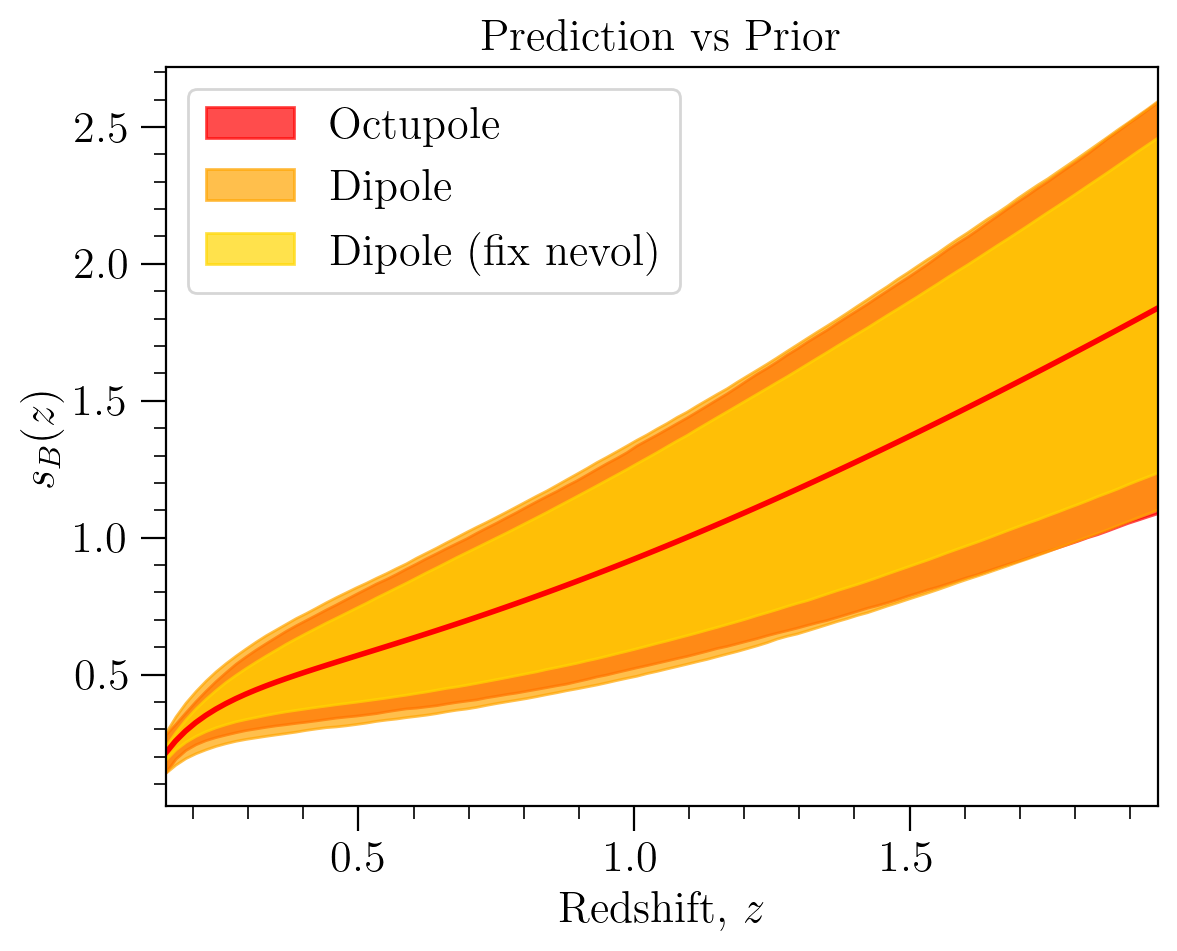

In [250]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='red', alpha=0.7, label = 'Octupole')
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='orange', alpha=0.7, label = 'Dipole')
plt.fill_between(z_lin, sB_lower_bound_dip, sB_upper_bound_dip, color='gold', alpha=0.7, label = 'Dipole (fix nevol)')


plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc = 'upper left')

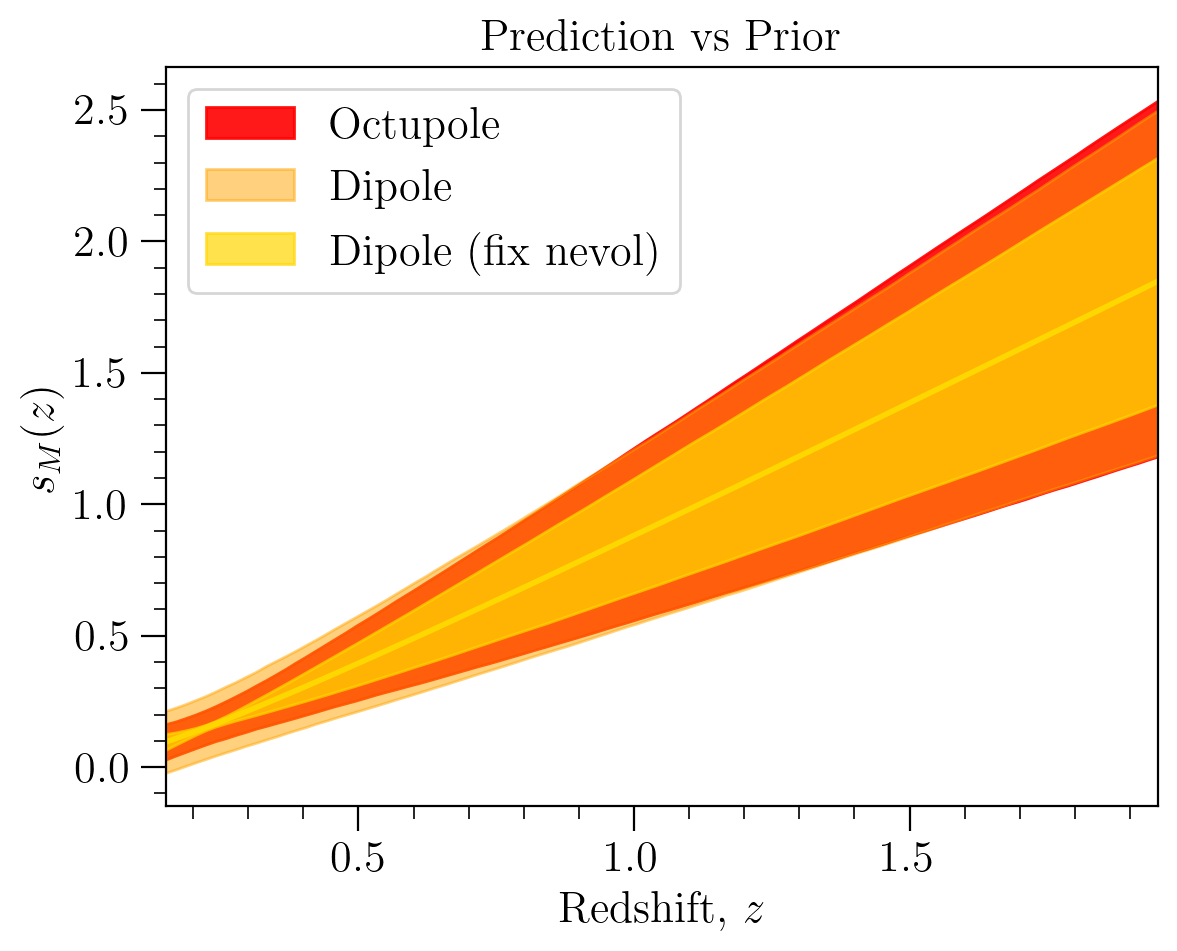

In [258]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='gold')

# Shade the 68% confidence interval
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='red', alpha=0.9, label = 'Octupole')
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='orange', alpha=0.5, label = 'Dipole')
plt.fill_between(z_lin, sM_lower_bound_dip, sM_upper_bound_dip, color='gold', alpha=0.7, label = 'Dipole (fix nevol)')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'Prediction vs Prior');
plt.legend(loc = 'upper left');

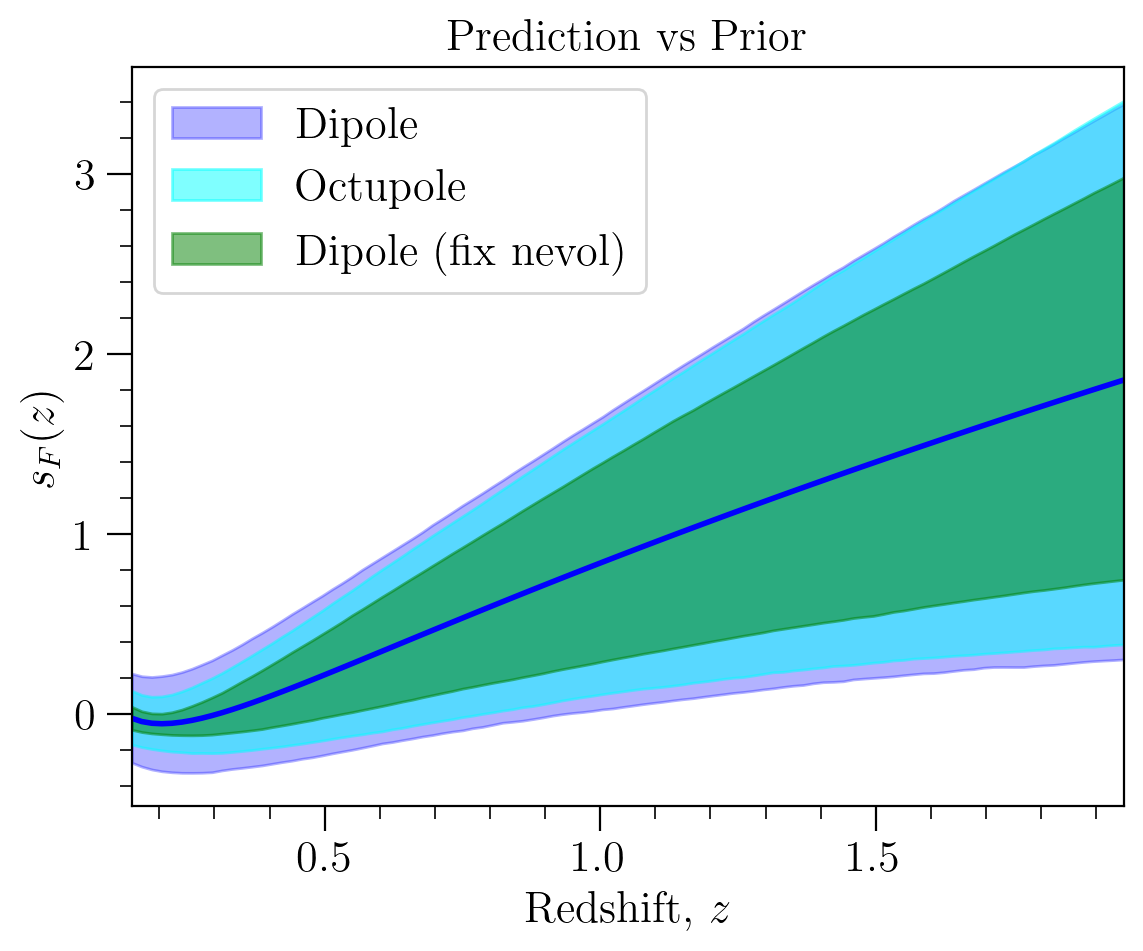

In [251]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='blue', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='cyan', alpha=0.5, label = 'Octupole')
plt.fill_between(z_lin, sF_lower_bound_dip, sF_upper_bound_dip, color='green', alpha=0.5, label = 'Dipole (fix nevol)')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc='upper left');

## Include the DIPOLE

### Include cross-variances (FULL ANALYSIS)

We include the OCTUPOLE AND DIPOLE in the previous analysis. We include now the cross correlation between the octupole and the other multipoles (it only has non-zero cross-correlations with the dipole).

In [36]:
# Create the Cov Matrix for sB, sF, fevolB, fevolF

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

sB_4fit = np.array([-0.90110744,  1.82300203, -1.01878439, -0.30342324])
sF_4fit = np.array([-0.19376095,  1.0747336,  -0.07806247, -0.00558005])
nevol_fid = np.array([7.94599875, -12.03752387,   2.29927261, -15.83887369])

num_fit = nevol_fid

dsB_19bins = sB_4fit * errB[0] 
dsF_19bins = sF_4fit * errF[0]
dnum_19bins = num_fit * errB[1]

Cov_all_19bins = np.diag(np.concatenate([dsB_19bins**2, dsF_19bins**2, dnum_19bins**2]))

Inv_Cov_oct_all_19bins = np.linalg.inv(Cov_all_19bins)

Inv_Cov_oct_prior_all = np.zeros([len(dsignal_dtheta_fit_all), len(dsignal_dtheta_fit_all)])
Inv_Cov_oct_prior_all[:len(Inv_Cov_oct_all_19bins), :len(Inv_Cov_oct_all_19bins)] = Inv_Cov_oct_all_19bins

Cov_oct_multipoles_19bins = np.array(Cov_multipoles_19bins)

np.shape(Cov_oct_multipoles_19bins)

(19, 324, 324)

In [37]:
# Import full Covariance Matrix

Cov_oct_multipoles_19bins = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, small_off_diagonal = True, split=[50,50], rtol=1e-4)

np.shape(Cov_oct_multipoles_19bins)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 

Population splitted in 50% BRIGHT - 50% FAINT 


 ... Success! ... 



(19, 324, 324)

In [38]:
np.shape(dsignal_dtheta_fit_all)

(21, 19, 324)

In [39]:
# Fisher Matrix

Inv_Cov_oct_multipoles_19bins = np.array([np.linalg.inv(Cov_oct_multipoles_19bins[k]) for k,_ in enumerate(z_bins)])

Fisher_Matrix_oct_multipoles_19bins = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all, inv_cov = Inv_Cov_oct_multipoles_19bins, z_bins = z_bins)
Fisher_Matrix_oct_all_19bins = Fisher_Matrix_oct_multipoles_19bins + Inv_Cov_oct_prior_all

Sigma_Matrix_oct_all_19bins = np.linalg.inv(Fisher_Matrix_oct_all_19bins)

np.shape(Sigma_Matrix_oct_all_19bins)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [40]:
np.savetxt('data/Fisher_All.txt',X=Fisher_Matrix_oct_all_19bins, fmt='%.5e')

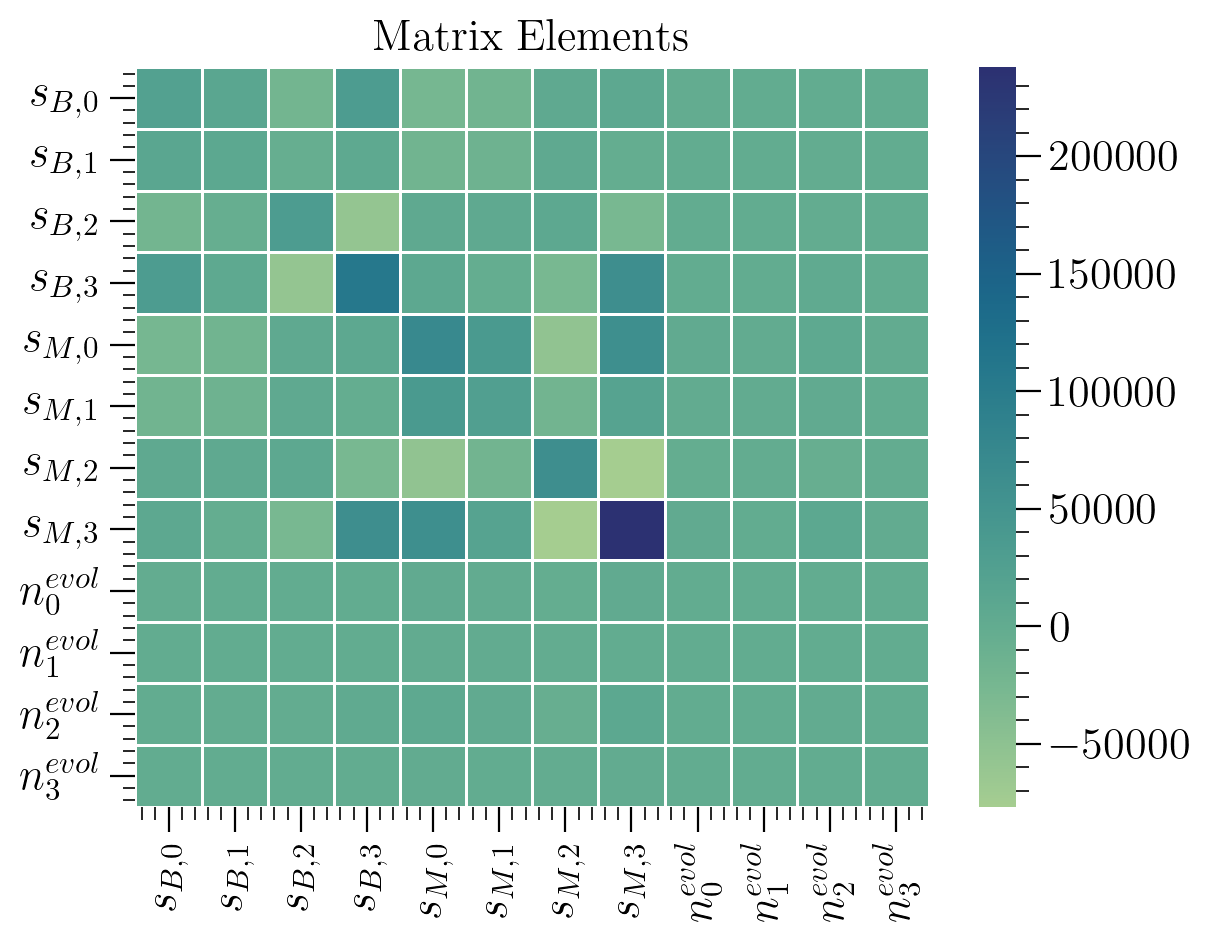

In [41]:
# Calculate the element-wise ratio
element_ratio = Fisher_Matrix_oct_all_19bins[:12,:12]

# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=False, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Elements")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")
plt.show()

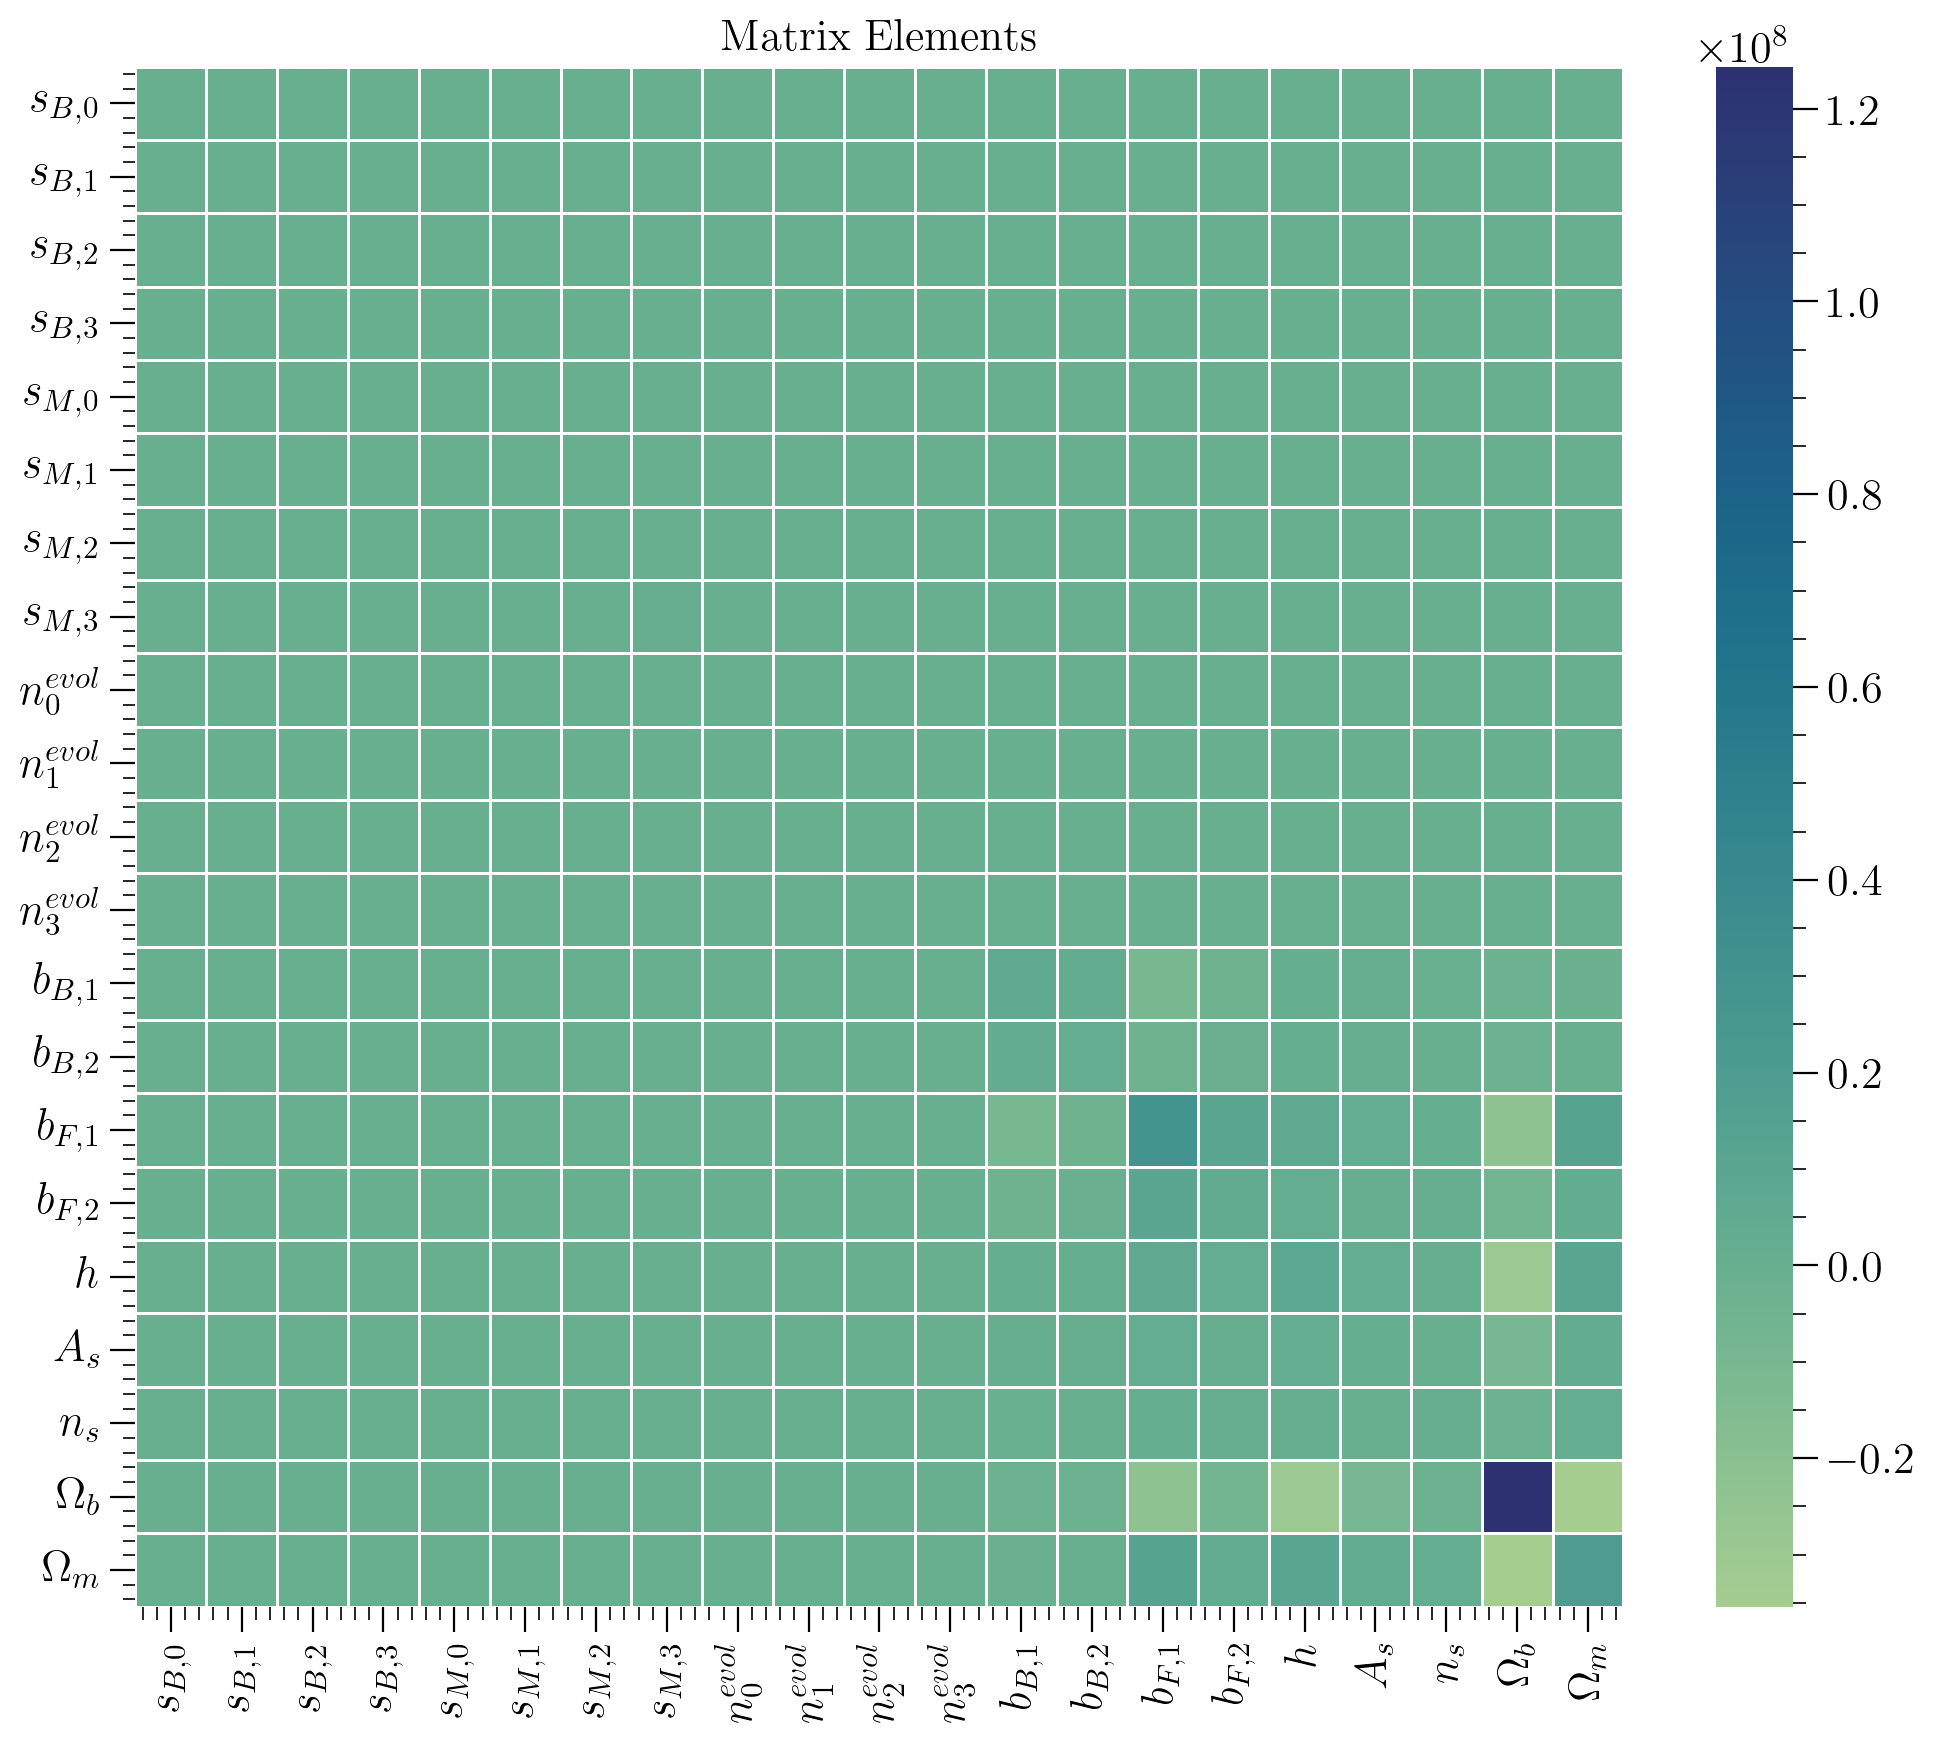

In [55]:
# Calculate the element-wise ratio

plt.figure(figsize=(12,10))

element_ratio = Fisher_Matrix_oct_all_19bins

index_labels = [r'$s_{B,0}$', r'$s_{B,1}$', r'$s_{B,2}$', r'$s_{B,3}$', 
                r'$s_{M,0}$', r'$s_{M,1}$', r'$s_{M,2}$', r'$s_{M,3}$', 
                r'$n^{evol}_0$', r'$n^{evol}_1$', r'$n^{evol}_2$', r'$n^{evol}_3$',
                r'$b_{B,1}$', r'$b_{B,2}$', r'$b_{F,1}$', r'$b_{F,2}$',
                r'$h$', r'$A_s$', r'$n_s$', r'$\Omega_b$', r'$\Omega_m$']
# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=False, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Elements")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")

plt.savefig('plots/heatmap_fisher_all.pdf', bbox_inches='tight', format='pdf')

plt.show()


#### Constraints

In [85]:
#Absolute Errors

Abs_Errors_oct_all_19bins = np.sqrt(np.diag(Sigma_Matrix_oct_all_19bins))

# Fiducial values

sbias_fid = np.concatenate([sB_4fit, sF_4fit])
num_fid = num_fit
gbias_fid = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sbias_fid, num_fid, gbias_fid, cosmic_fid])

# Relative errors

Rel_Errors_oct_all_19bins = np.abs(Abs_Errors_oct_all_19bins/params_fid)

params_errors_oct_all_19bins = Rel_Errors_oct_all_19bins * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sbias = ', params_errors_oct_all_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])
print()
print('gbias = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)+len(gbias_fid)):])


------------ Relative errors * 100 ------------

sbias =  [30.01764657 18.47280869 25.02675176 23.80647451 39.28697275 27.82862228
 45.07011706 49.94474645]

number =  [41.31183921 31.04109798 25.55481329 30.70779288]

gbias =  [0.42748007 0.36834475 0.14148394 0.27887022]

cosmic =  [1.10512408 0.7080217  0.8991259  1.13027314 0.49626418]


#### Comparing with and without DIPOLE

Compute the improvement in %

In [86]:
print('------------ Relative errors with octupole * 100 ------------' )
print()
print('sbias = ', params_errors_oct_all_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])

------------ Relative errors with octupole * 100 ------------

sbias =  [30.01764657 18.47280869 25.02675176 23.80647451 39.28697275 27.82862228
 45.07011706 49.94474645]

number =  [41.31183921 31.04109798 25.55481329 30.70779288]


In [88]:
print('------------ Relative errors without dipole * 100 ------------' )
print()
print('sbias = ', params_errors_ndip_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])

------------ Relative errors without dipole * 100 ------------

sbias =  [37.38196968 25.16944943 26.70779593 34.04205048 41.22801121 33.93581911
 46.99367568 49.97035594]

number =  [50. 50. 50. 50.]


In [89]:
print('------------ Relative errors without octupole * 100 ------------' )
print()
print('sbias = ', params_errors_noct_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])

------------ Relative errors without octupole * 100 ------------

sbias =  [36.81396256 20.01069479 26.3634573  26.18167445 47.70070085 31.79585479
 49.25653578 49.98536768]

number =  [44.85256149 43.74071271 40.38633243 33.16321126]


In [90]:
print('------------ Improvement * 100 vs NO DIPOLE ------------' )
print()
print('sbias = ', (1-params_errors_oct_all_19bins[0:len(sbias_fid)]/params_errors_ndip_19bins[0:len(sbias_fid)]) * 100)
print()
print('number = ', (1-params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]/params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]) * 100)

------------ Improvement * 100 vs NO DIPOLE ------------

sbias =  [19.70020085 26.60622658  6.29420778 30.06744841  4.70805747 17.99631477
  4.09322869  0.05124937]

number =  [17.37632157 37.91780403 48.89037342 38.58441424]


In [91]:
print('------------ Improvement * 100 vs NO OCTUPOLE ------------' )
print()
print('sbias = ', (1-params_errors_oct_all_19bins[0:len(sbias_fid)]/params_errors_noct_19bins[0:len(sbias_fid)]) * 100)
print()
print('number = ', (1-params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]/params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]) * 100)

------------ Improvement * 100 vs NO OCTUPOLE ------------

sbias =  [18.46124547  7.68532085  5.07029683  9.07199399 17.6385838  12.47720035
  8.49921467  0.08126625]

number =  [ 7.89413616 29.03385413 36.72410502  7.40404288]


In [94]:
import pandas as pd

row_names = {
    0: "sB_0",
    1: "sB_1",
    2: "sB_2",
    3: "sB_3",
    4: "sM_0",
    5: "sM_2",
    6: "sM_3",
    7: "sM_4"
}

constraints_s = {
    "OCTUPOLE" : params_errors_ndip_19bins[0:len(sbias_fid)],
    "DIPOLE" : params_errors_noct_19bins[0:len(sbias_fid)],
    "DIP + OCT " : params_errors_oct_all_19bins[0:len(sbias_fid)],
    #"Improvement" : (1-params_errors_oct_all_19bins[0:len(sbias_fid)]/params_errors_ndip_19bins[0:len(sbias_fid)]) * 100
}

df_s = pd.DataFrame(constraints_s, index=row_names.values())
df_s = df_s.apply(pd.Series.round, args=[2])

In [95]:
df_s

OCTUPOLE  DIPOLE  DIP + OCT 
sB_0     37.38   36.81       30.02
sB_1     25.17   20.01       18.47
sB_2     26.71   26.36       25.03
sB_3     34.04   26.18       23.81
sM_0     41.23   47.70       39.29
sM_2     33.94   31.80       27.83
sM_3     46.99   49.26       45.07
sM_4     49.97   49.99       49.94

In [96]:
latex_string = df_s.to_latex(index=True, float_format='%.2f')  # Remove index if desired
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & OCTUPOLE & DIPOLE & DIP + OCT  \\
\midrule
sB_0 & 37.38 & 36.81 & 30.02 \\
sB_1 & 25.17 & 20.01 & 18.47 \\
sB_2 & 26.71 & 26.36 & 25.03 \\
sB_3 & 34.04 & 26.18 & 23.81 \\
sM_0 & 41.23 & 47.70 & 39.29 \\
sM_2 & 33.94 & 31.80 & 27.83 \\
sM_3 & 46.99 & 49.26 & 45.07 \\
sM_4 & 49.97 & 49.99 & 49.94 \\
\bottomrule
\end{tabular}



In [99]:
row_names = {
    0: "n_0",
    1: "n_1",
    2: "n_2",
    3: "n_3"
}

constraints_num = {
    "Octupole" : params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))],
    "Dipole" : params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))],
    "DIP + OCT" : params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))],
    #"Improvement" : (1-params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]/params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]) * 100
}

df_num = pd.DataFrame(constraints_num, index=row_names.values())
df_num = df_num.apply(pd.Series.round, args=[2])

In [100]:
df_num

Octupole  Dipole  DIP + OCT
n_0      50.0   44.85      41.31
n_1      50.0   43.74      31.04
n_2      50.0   40.39      25.55
n_3      50.0   33.16      30.71

In [101]:
latex_string = df_num.to_latex(index=True, float_format='%.2f')  # Remove index if desired
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & Octupole & Dipole & DIP + OCT \\
\midrule
n_0 & 50.00 & 44.85 & 41.31 \\
n_1 & 50.00 & 43.74 & 31.04 \\
n_2 & 50.00 & 40.39 & 25.55 \\
n_3 & 50.00 & 33.16 & 30.71 \\
\bottomrule
\end{tabular}



In [102]:
# Galaxy bias and Cosmic params

print('------------ Relative errors with octupole * 100 ------------' )
print()
print('gbias = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):])

print('\n------------ Relative errors without octupole * 100 ------------' )
print()
print('gbias = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):])

print('\n------------ Improvement * 100 ------------' )
print()
print('gbias = ', (1-params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))]/params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))]) * 100)
print()
print('cosmic = ', (1-params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):]/params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):]) * 100)

------------ Relative errors with octupole * 100 ------------

gbias =  [0.42748007 0.36834475 0.14148394 0.27887022]

cosmic =  [1.10512408 0.7080217  0.8991259  1.13027314 0.49626418]

------------ Relative errors without octupole * 100 ------------

gbias =  [0.42787711 0.36848222 0.14149093 0.27933741]

cosmic =  [1.10551549 0.70862343 0.8994093  1.13039699 0.49670653]

------------ Improvement * 100 ------------

gbias =  [0.09279357 0.03730551 0.00493866 0.16725039]

cosmic =  [0.03540477 0.08491478 0.03150975 0.01095657 0.08905733]


#### Predictions

##### Magnification bias

In [103]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

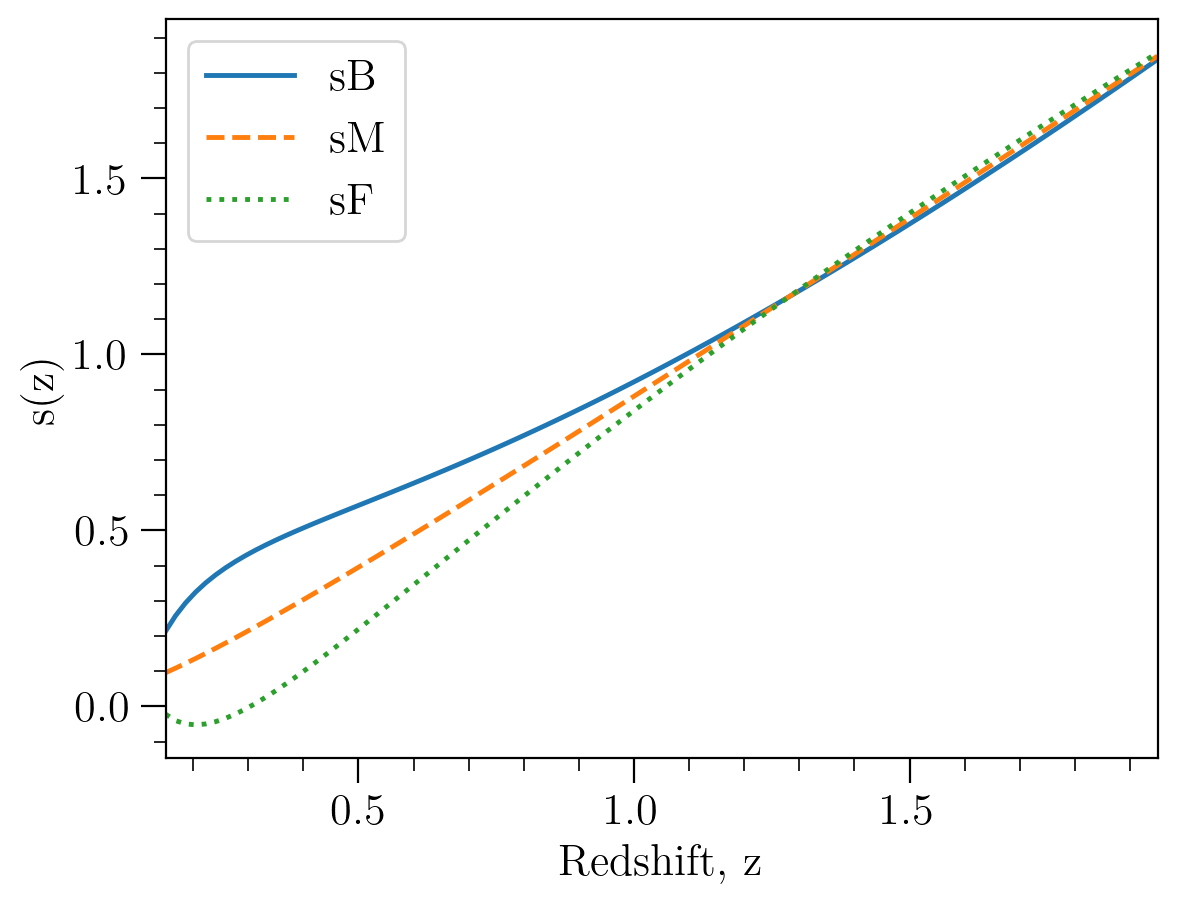

In [104]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

sB_fid = magbias_fit(sB_4fit, z_lin)
sM_fid = magbias_fit(sF_4fit, z_lin)
sF_fid = sM_fid * (m_split/(m_split-1)) - sB_fid/(m_split-1)

plt.plot(z_lin, sB_fid, '-', label=r'sB')
plt.plot(z_lin, sM_fid, '--', label=r'sM')
plt.plot(z_lin, sF_fid, ':', label=r'sF')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();


###### Compare the two observables

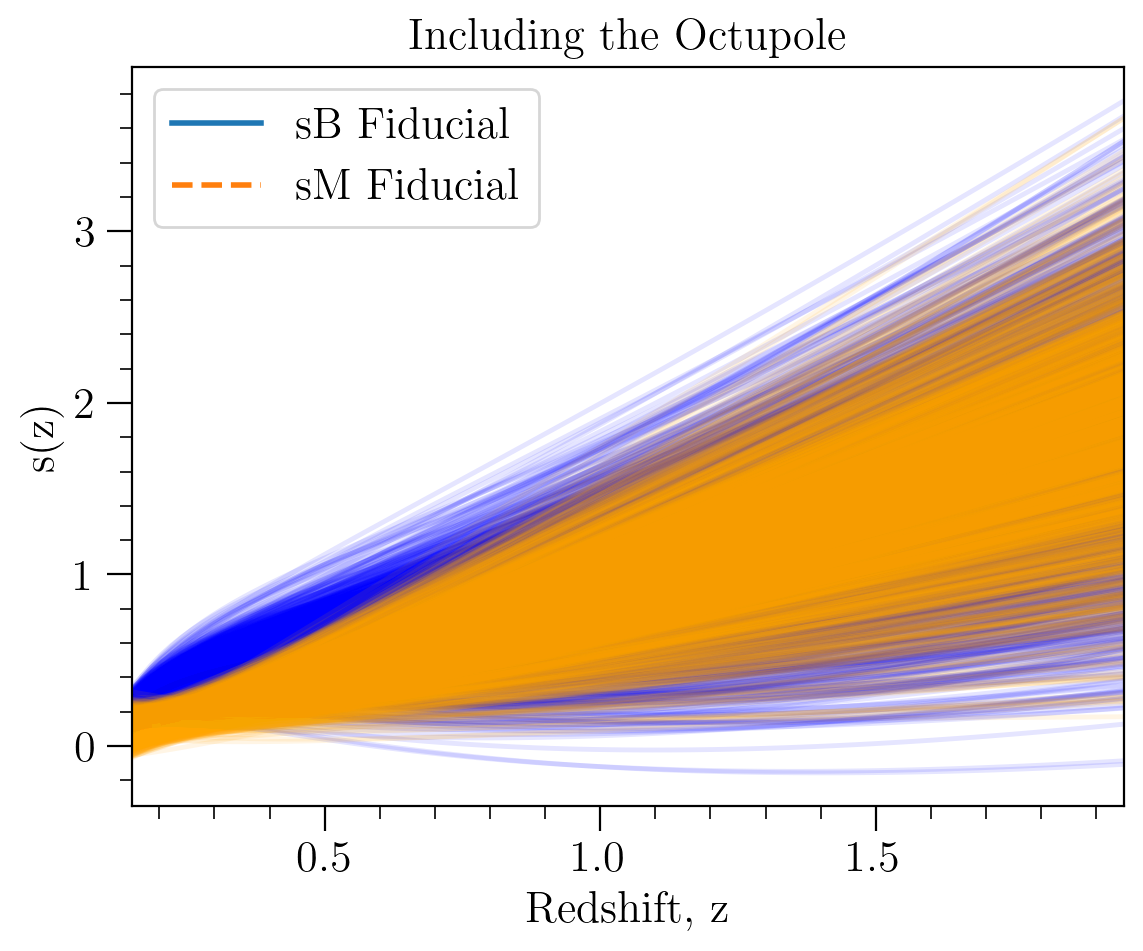

In [105]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_all = Sigma_Matrix_oct_all_19bins[:4, :4]
cov_sM_all = Sigma_Matrix_oct_all_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 2000
sB_pars_samples_all = np.random.multivariate_normal(sB_4fit, cov_sB_all, num_samples)
sM_pars_samples_all = np.random.multivariate_normal(sF_4fit, cov_sM_all, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_all = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_all])
sM_samples_all = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_all])

# Calculate the 68% confidence interval
sB_lower_bound_all = np.percentile(sB_samples_all, 16, axis=0)
sB_upper_bound_all = np.percentile(sB_samples_all, 84, axis=0)
sM_lower_bound_all = np.percentile(sM_samples_all, 16, axis=0)
sM_upper_bound_all= np.percentile(sM_samples_all, 84, axis=0)

# Step 5: Plotting

plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0)
plt.plot(z_lin, sM_fid, '--', label=r'sM Fiducial', lw = 2.0)

# Plot the fitting function for each sample
for sample in sB_samples_all:
    plt.plot(z_lin, sample, color='blue', alpha=0.1)

for sample in sM_samples_all:
    plt.plot(z_lin, sample, color='orange', alpha=0.1)
    
plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title(r'Including the Octupole')
plt.legend();

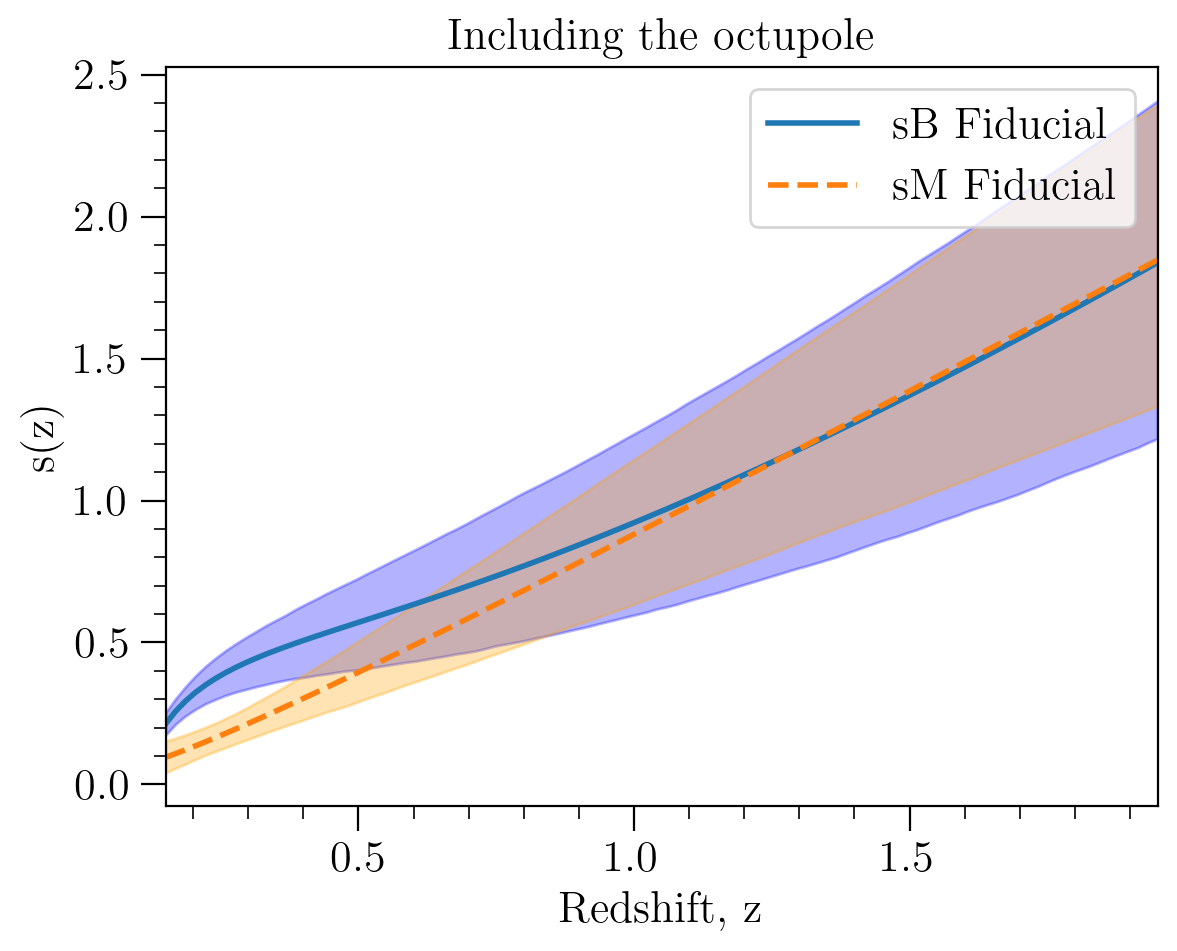

In [106]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0)
plt.plot(z_lin, sM_fid, '--', label=r'sM Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='blue', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='orange', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

###### Compare with priors

In [107]:
# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_priors = Cov_all_19bins[:4, :4]
cov_sM_priors = Cov_all_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 2000
sB_pars_samples_priors = np.random.multivariate_normal(sB_4fit, cov_sB_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sF_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_priors])
sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval
sB_lower_bound_priors_all = np.percentile(sB_samples_priors, 16, axis=0)
sB_upper_bound_priors_all = np.percentile(sB_samples_priors, 84, axis=0)
sM_lower_bound_priors_all = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors_all = np.percentile(sM_samples_priors, 84, axis=0)

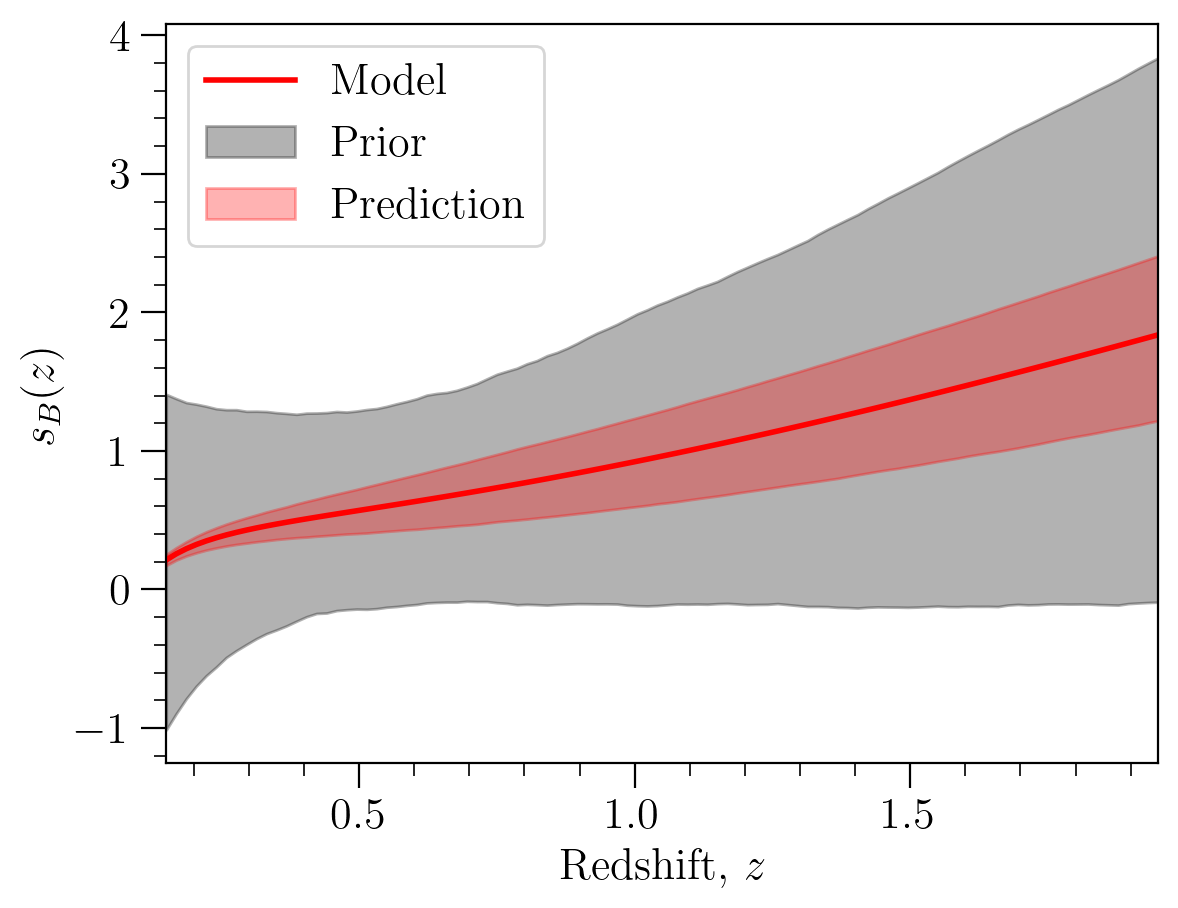

In [109]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='red', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors_all, sB_upper_bound_priors_all, color='black', alpha=0.3, label='Prior')
plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='red', alpha=0.3, label='Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.legend(loc='upper left');
#plt.title(r'Prediction vs Prior (with octupole)')

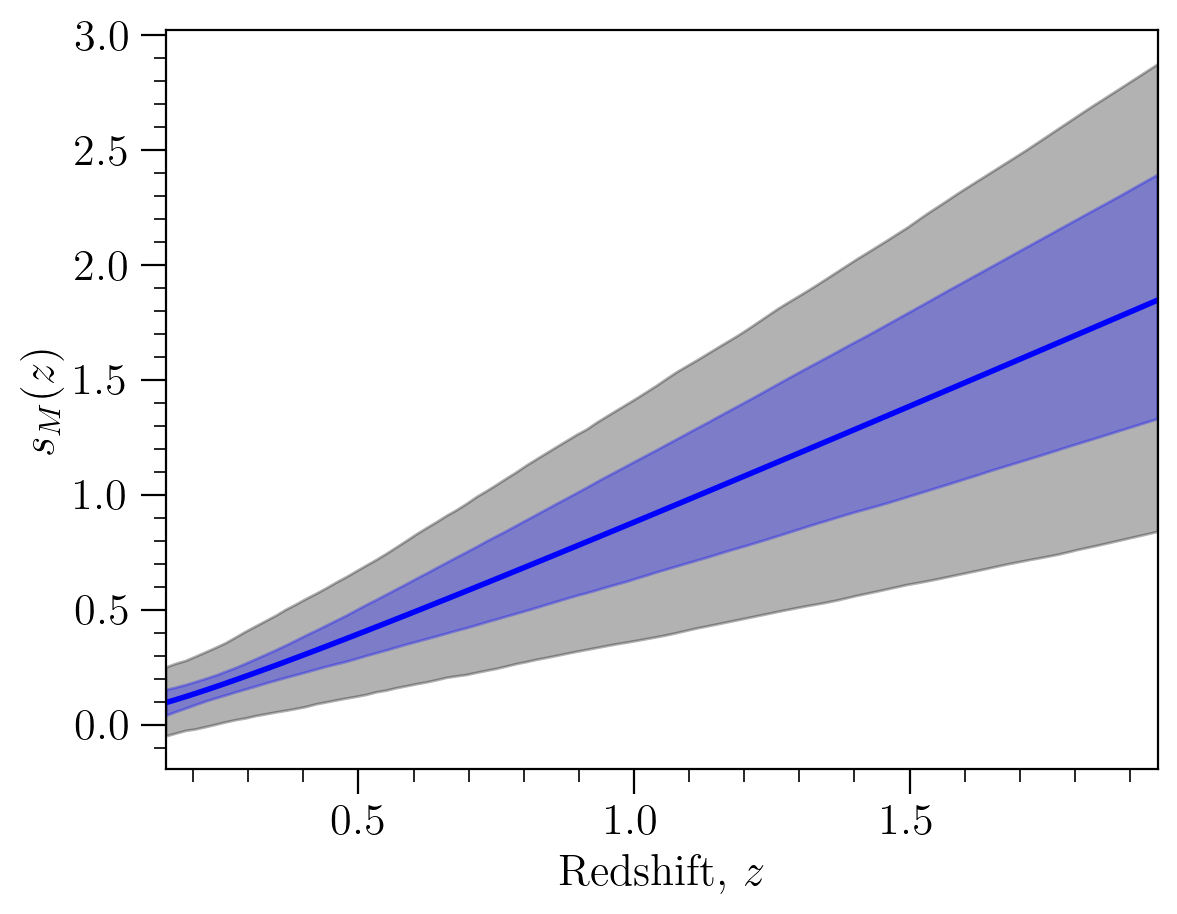

In [110]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label='Prior')
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='blue', alpha=0.3, label='Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
#plt.title(r'Prediction vs Prior (with octupole)')

###### Compare with no-DIPOLE

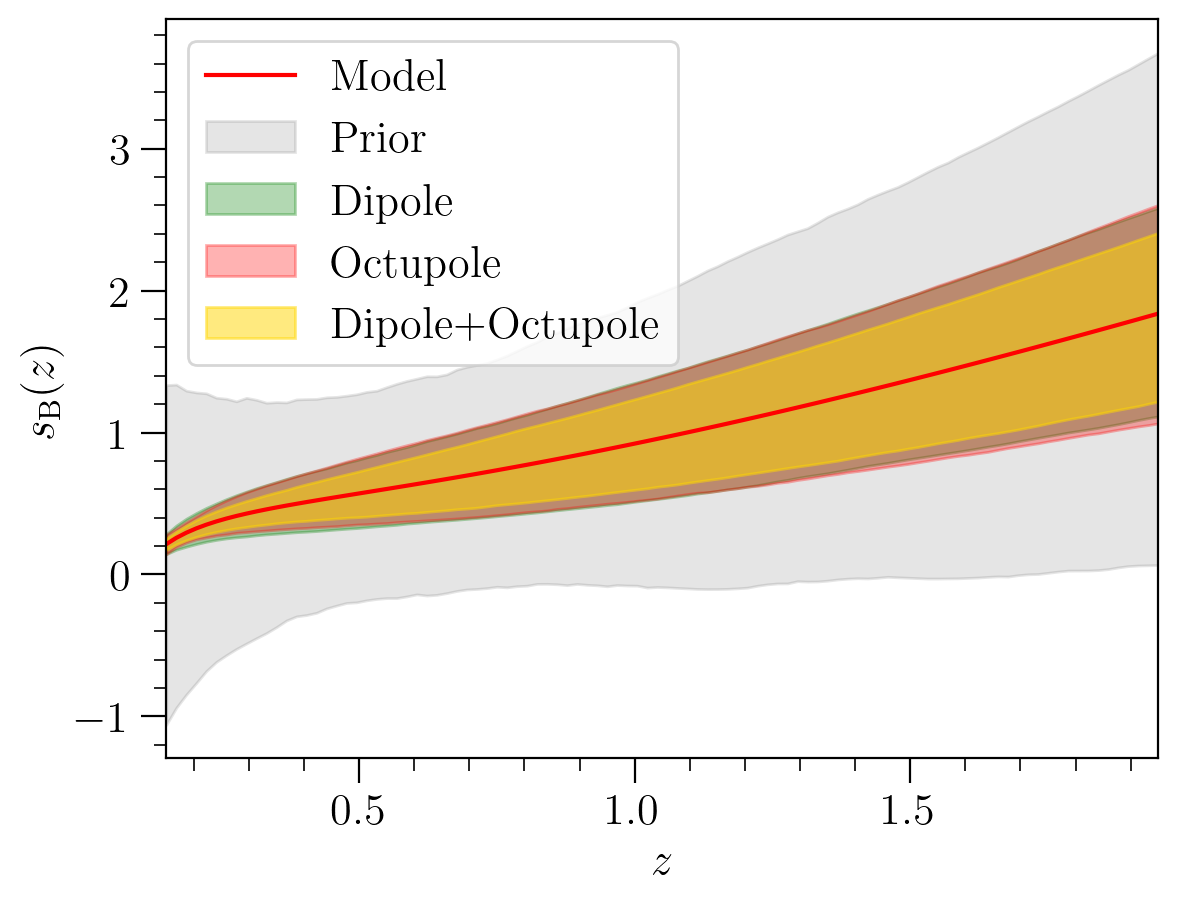

In [113]:
plt.plot(z_lin, sB_fid, '-', lw = 1.5, color='red', label=r'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.1, label=r'Prior')
plt.fill_between(z_lin, sB_lower_bound, sB_upper_bound, color='green', alpha=0.3, label=r'Dipole')
plt.fill_between(z_lin, sB_lower_bound_, sB_upper_bound_, color='red', alpha=0.3, label=r'Octupole')
plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='gold', alpha=0.5, label=r'Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$');
plt.ylabel(r'$s_\mathrm{B}(z)$');
#plt.title(r'With and without octupole');
plt.legend(loc='upper left');

#plt.savefig("plots/sB_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

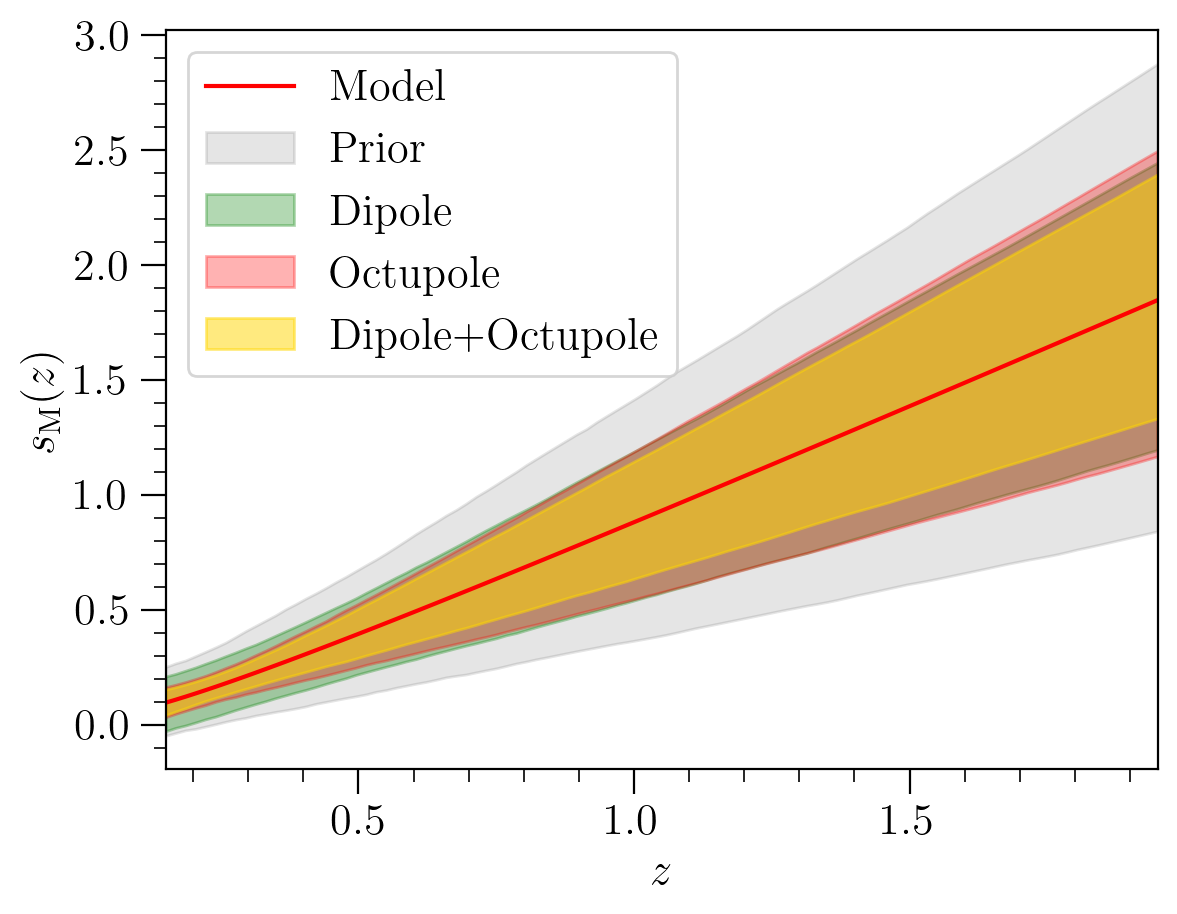

In [114]:
plt.plot(z_lin, sM_fid, '-', lw = 1.5, color='red', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, sM_lower_bound, sM_upper_bound, color='green', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, sM_lower_bound_, sM_upper_bound_, color='red', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='gold', alpha=0.5, label='Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$');
plt.ylabel(r'$s_\mathrm{M}(z)$');
#plt.title(r'With and without octupole');
plt.legend(loc='upper left')

#plt.savefig("plots/sM_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

###### Magnification bias of the Faint

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

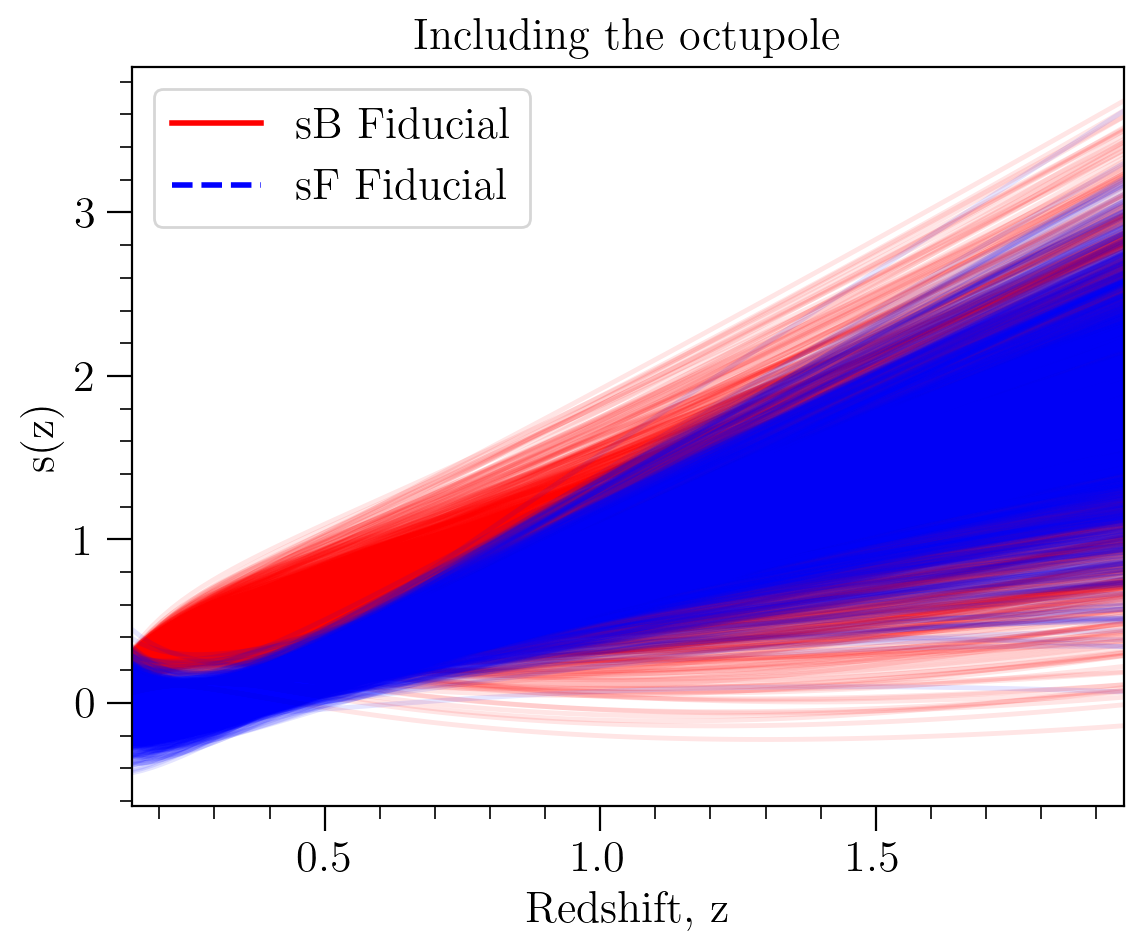

In [115]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_all = Sigma_Matrix_oct_all_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 2000
sbias_pars_samples_all = np.random.multivariate_normal(sbias_fid, cov_sbias_all, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_all = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_all])
sM_samples_all = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_all])

# Compute the sF for each sample
sF_samples_all = sM_samples_all*m_split/(m_split-1) - sB_samples_all/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_all = np.percentile(sF_samples_all, 16, axis=0)
sF_upper_bound_all = np.percentile(sF_samples_all, 84, axis=0)

# Step 5: Plotting

plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='red')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='blue')

# Plot the fitting function for each sample
for sample in sB_samples_all:
    plt.plot(z_lin, sample, color='red', alpha=0.1)

for sample in sF_samples_all:
    plt.plot(z_lin, sample, color='blue', alpha=0.1)
    
plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

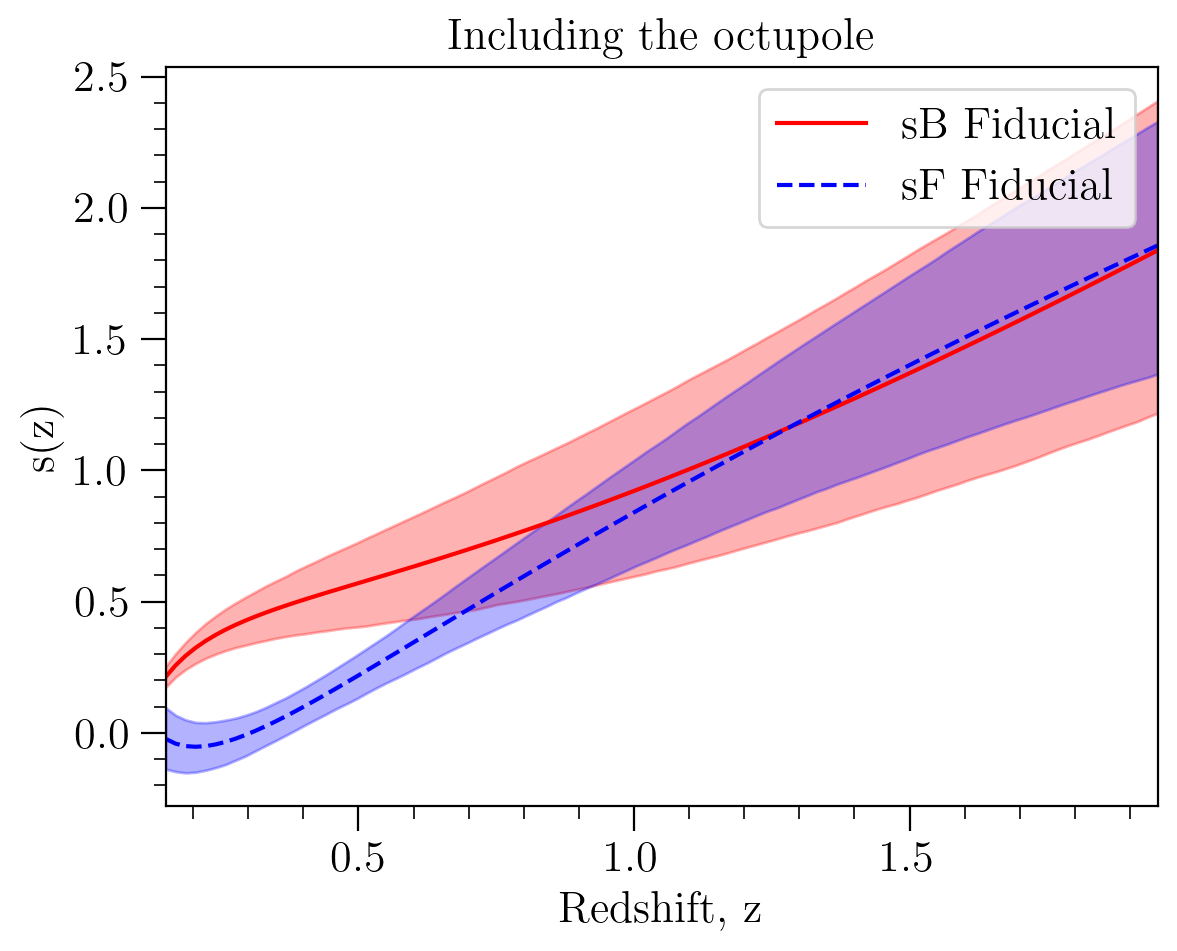

In [116]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 1.5, color='red')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 1.5, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='red', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='blue', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

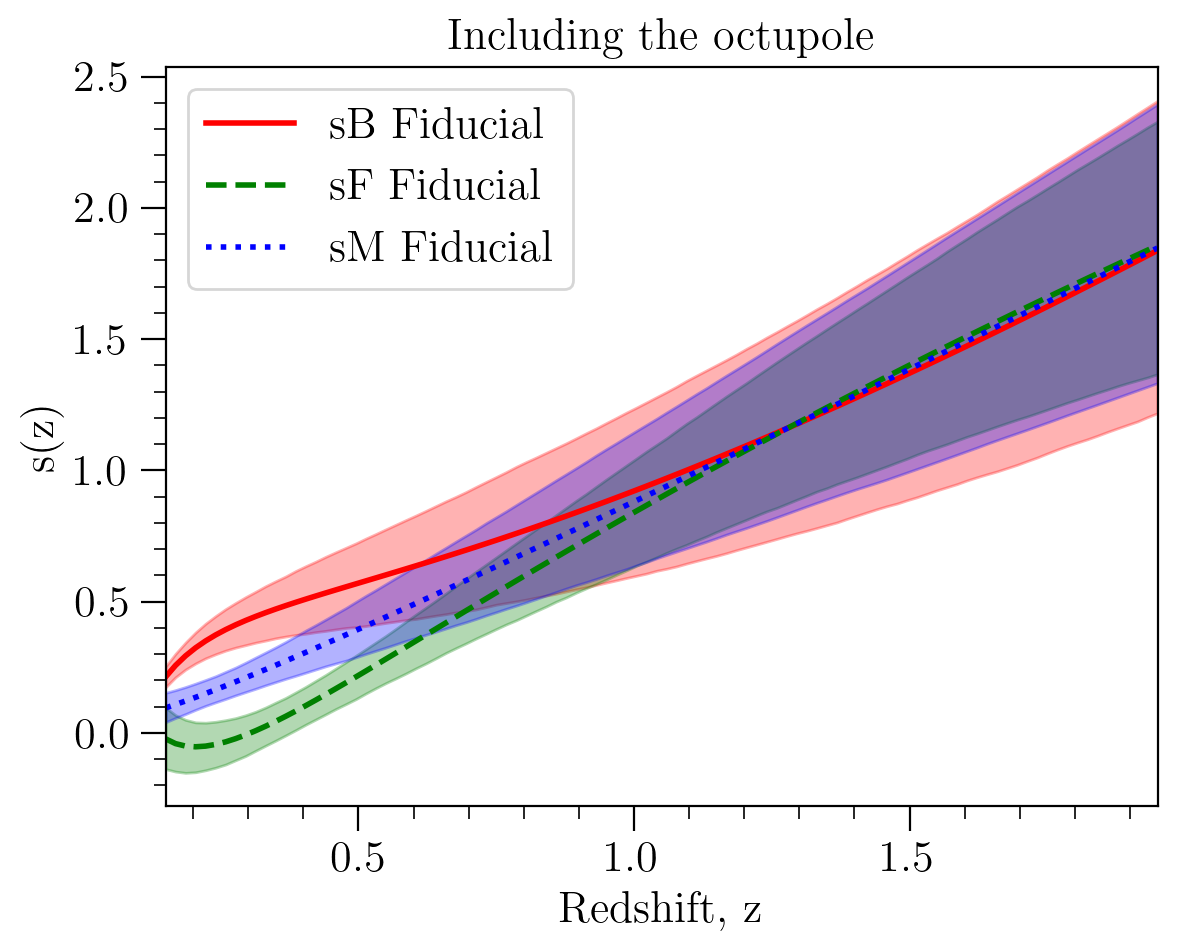

In [117]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='red')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')
plt.plot(z_lin, sM_fid, ':', label=r'sM Fiducial', lw = 2.0, color='blue')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='red', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='green', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='blue', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

Compare with priors

In [118]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_priors = Cov_all_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 2000
sbias_pars_samples_priors = np.random.multivariate_normal(sbias_fid, cov_sbias_priors, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_priors])
sM_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_priors])

# Compute the sF for each sample
sF_samples_priors = sM_samples_priors*m_split/(m_split-1) - sB_samples_priors/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_priors = np.percentile(sF_samples_priors, 16, axis=0)
sF_upper_bound_priors = np.percentile(sF_samples_priors, 84, axis=0)

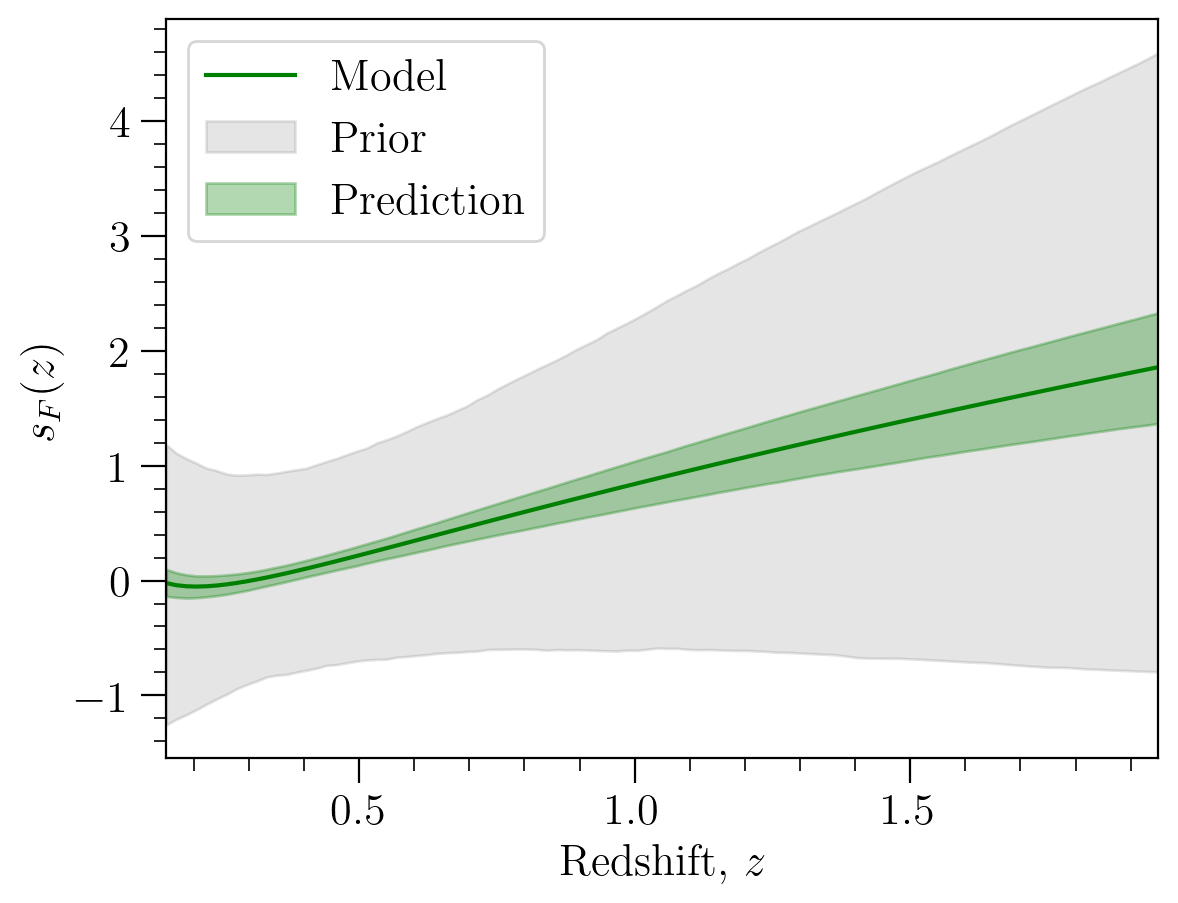

In [119]:
plt.plot(z_lin, sF_fid, '-', lw = 1.5, color='green', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='green', alpha=0.3, label='Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
#plt.title(r'Prediction vs Prior (with octupole)')
plt.legend(loc='upper left')

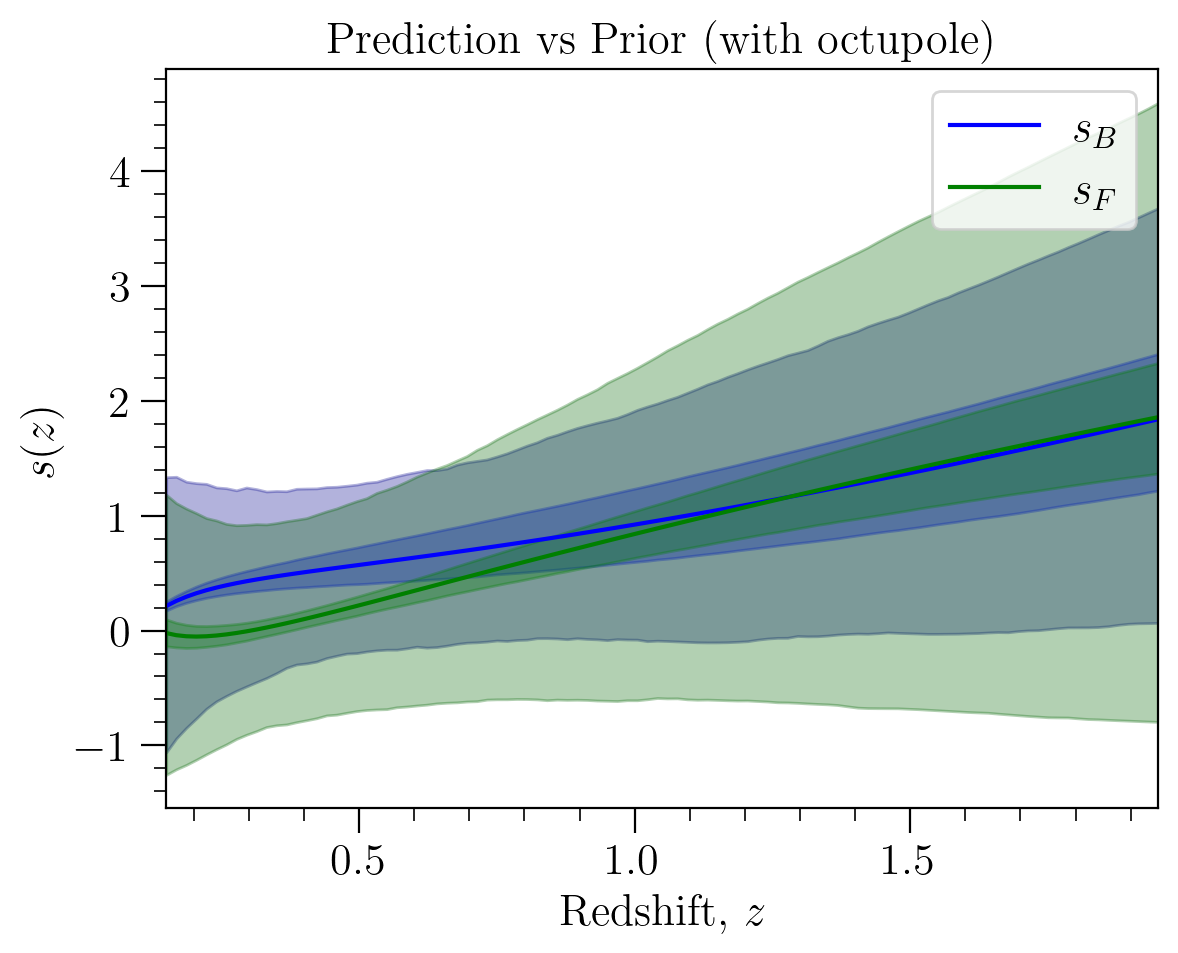

In [120]:
plt.plot(z_lin, sB_fid, '-', lw = 1.5, color='blue', label=r'$s_B$')
plt.plot(z_lin, sF_fid, '-', lw = 1.5, color='green', label=r'$s_F$')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='darkblue', alpha=0.3)
plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='darkgreen', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s(z)$');
plt.title(r'Prediction vs Prior (with octupole)');
plt.legend();

Compare with no octupole

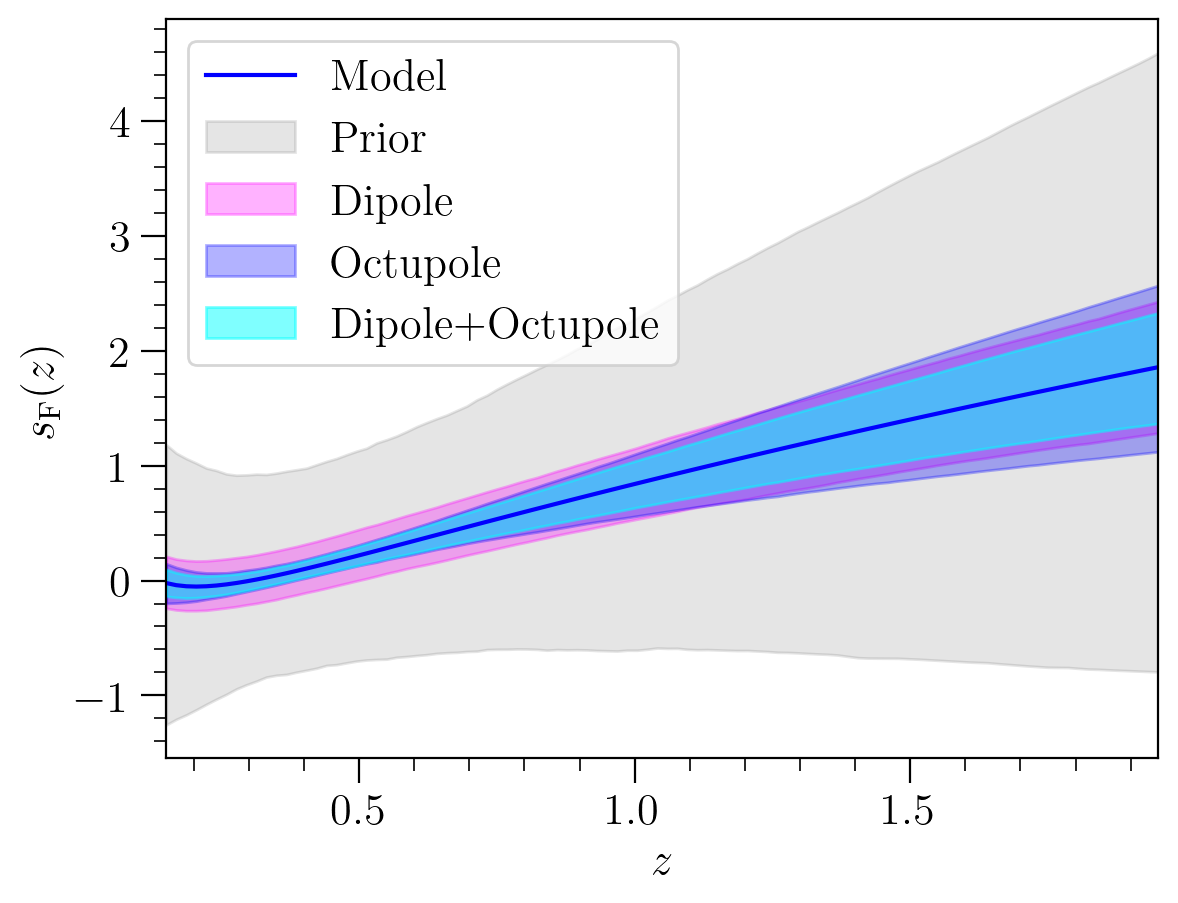

In [121]:
plt.plot(z_lin, sF_fid, '-', lw = 1.5, color='blue', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, sF_lower_bound, sF_upper_bound, color='magenta', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, sF_lower_bound_, sF_upper_bound_, color='blue', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='cyan', alpha=0.5, label='Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$');
plt.ylabel(r'$s_\mathrm{F}(z)$');
#plt.title(r'With and without octupole');
plt.legend(loc='upper left');

#plt.savefig("plots/sF_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

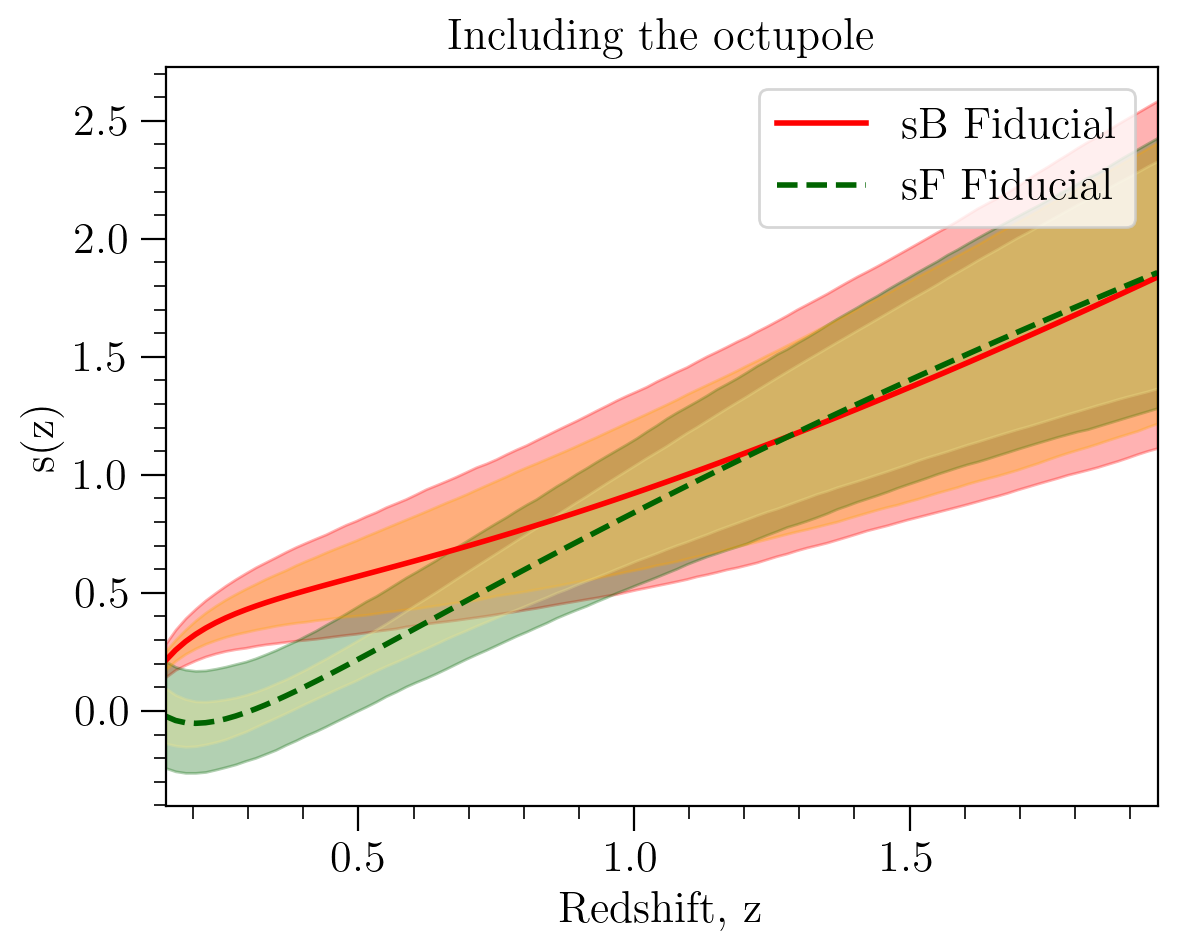

In [122]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='red')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='darkgreen')

# Shade the 68% confidence interval
plt.fill_between(z_lin, sB_lower_bound, sB_upper_bound, color='red', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound, sF_upper_bound, color='darkgreen', alpha=0.3)
plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='orange', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='khaki', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

##### Number evolution

In [123]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

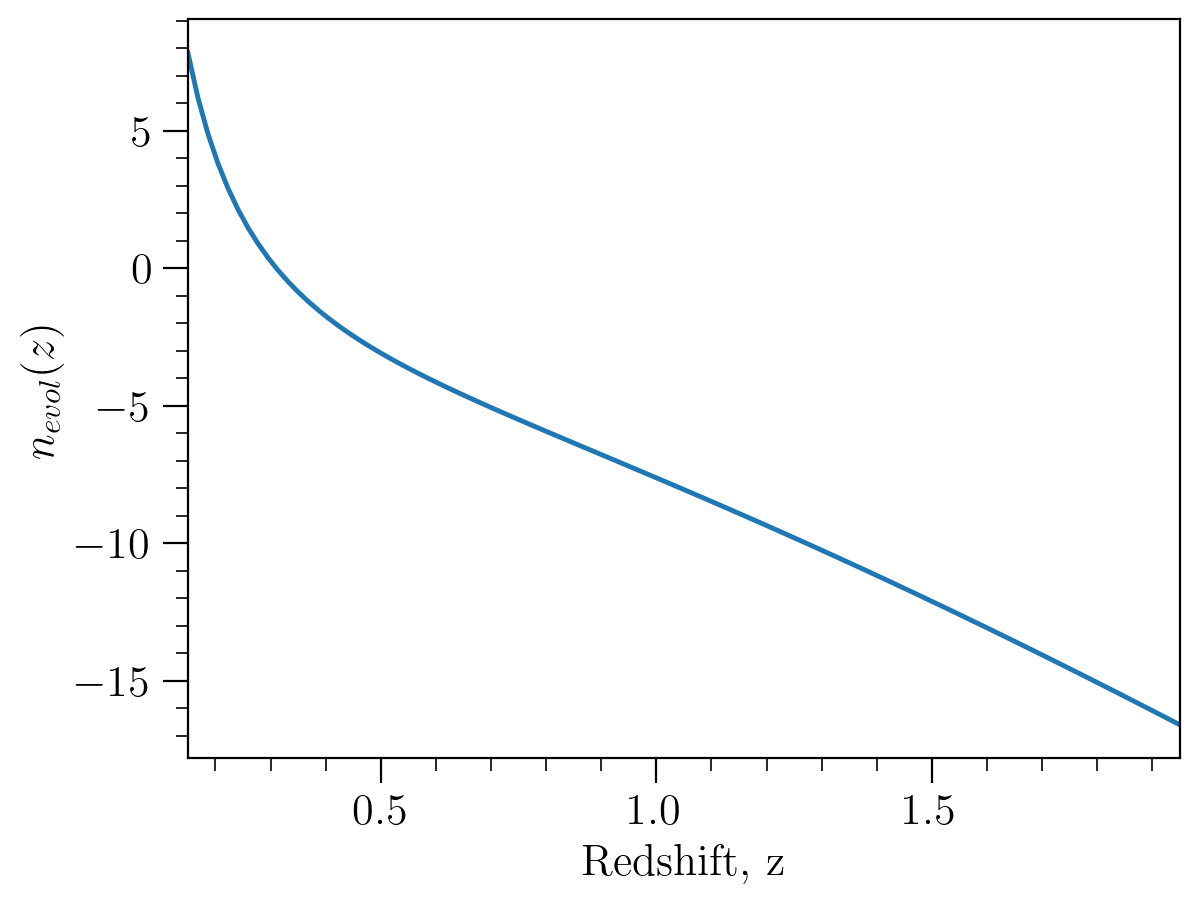

In [124]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(nevol_fid, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');

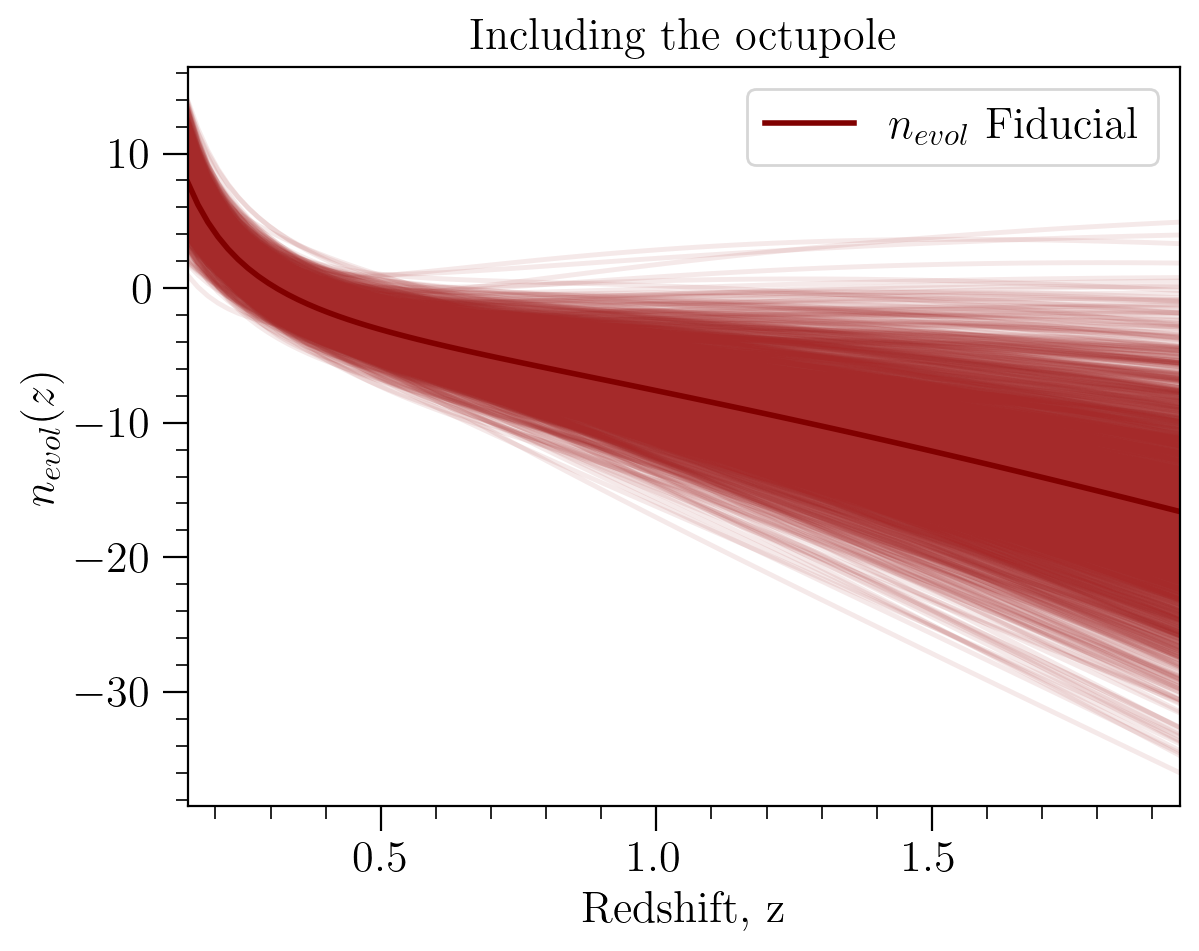

In [125]:
# Select the marginalized covariance matrix for the number evolution
cov_numevol_all = Sigma_Matrix_oct_all_19bins[8:12, 8:12]
cov_numevol_priors = Cov_all_19bins[8:12, 8:12]


# Generate parameter samples from multivariate normal distribution
num_samples = 2000
nevol_pars_samples_all = np.random.multivariate_normal(nevol_fid, cov_numevol_all, num_samples)
nevol_samples_priors = np.random.multivariate_normal(nevol_fid, cov_numevol_priors, num_samples)


# Evaluate fitting function for each parameter sample
nevol_samples_all = np.array([nevol_fit(pars, z_lin) for pars in nevol_pars_samples_all])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_lower_bound_all = np.percentile(nevol_samples_all, 16, axis=0)
nevol_upper_bound_all = np.percentile(nevol_samples_all, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

# Step 5: Plotting

# Plot the fitting function for each sample
for sample in nevol_samples_all:
    plt.plot(z_lin, sample, color='brown', alpha=0.1)
    
plt.plot(z_lin, num_evol_fid, '-', color='maroon', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.title('Including the octupole')
plt.legend();

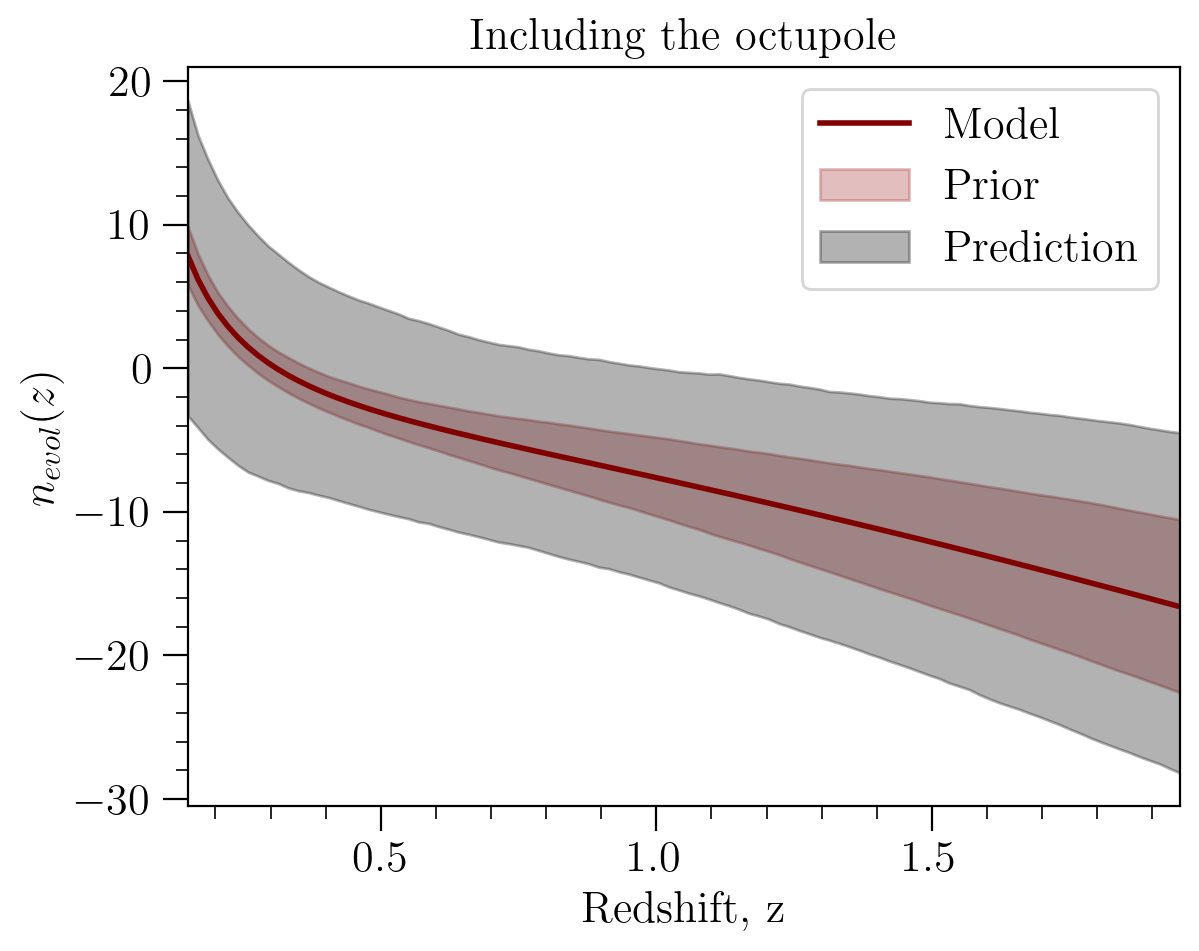

In [126]:
plt.plot(z_lin, num_evol_fid, '-', color='maroon', label=r'Model', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_all, nevol_upper_bound_all, color='brown', alpha=0.3, label=r'Prior')
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label=r'Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.title('Including the octupole')
plt.legend();

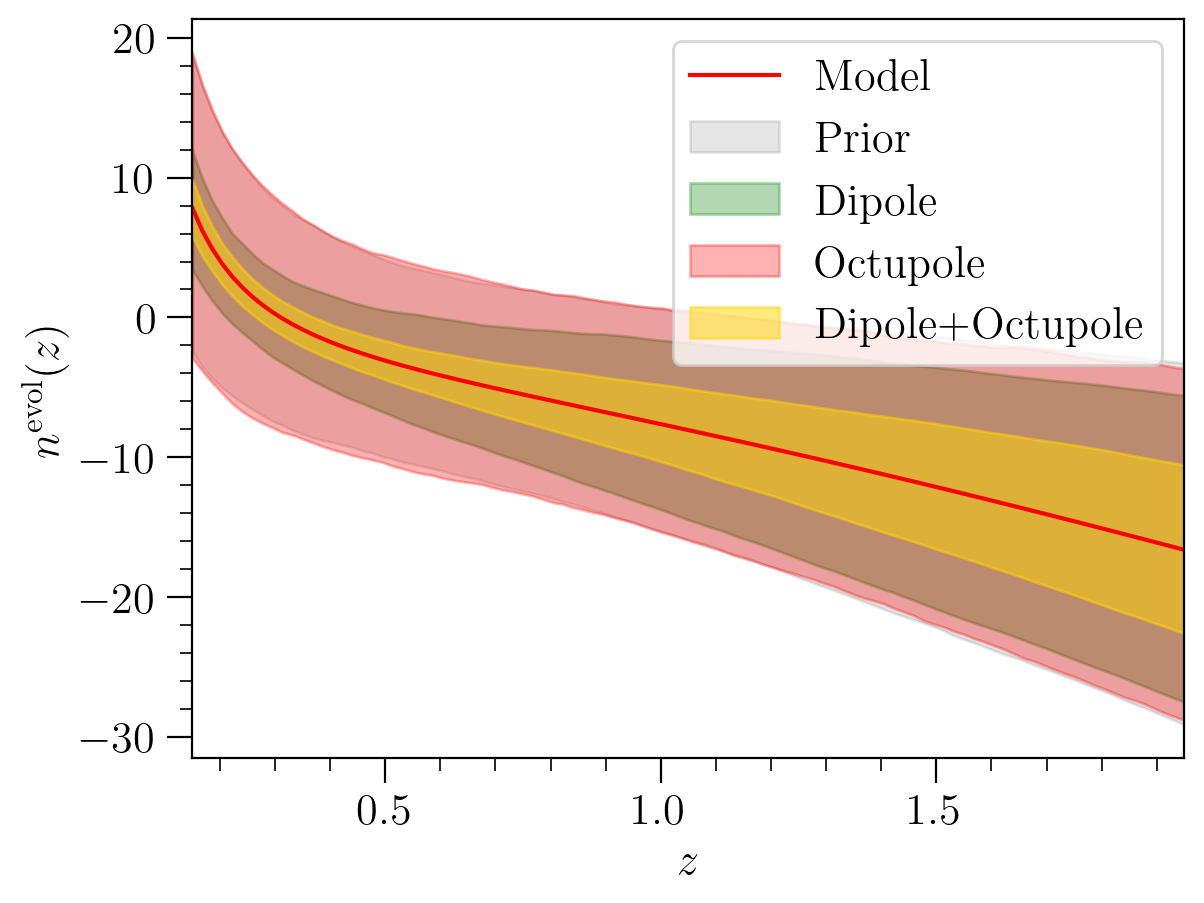

In [128]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'Model', lw = 1.5)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_priors_, nevol_upper_bound_priors_, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, nevol_lower_bound, nevol_upper_bound, color='green', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, nevol_lower_bound_, nevol_upper_bound_, color='red', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, nevol_lower_bound_all, nevol_upper_bound_all, color='gold', alpha=0.5, label='Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$')
plt.ylabel(r'$n^\mathrm{evol}(z)$')
#plt.title('With and without octupole')
plt.legend();

#plt.savefig("plots/nevol_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

##### Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [129]:
m_split = 2.

myEvolBias = EvolutionBias(n_split=m_split)

dlogH = myEvolBias.dlogH
rHterm = myEvolBias.rHterm
dFstar = myEvolBias.dLogFstar
dFcut = myEvolBias.dLogFcut

In [130]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

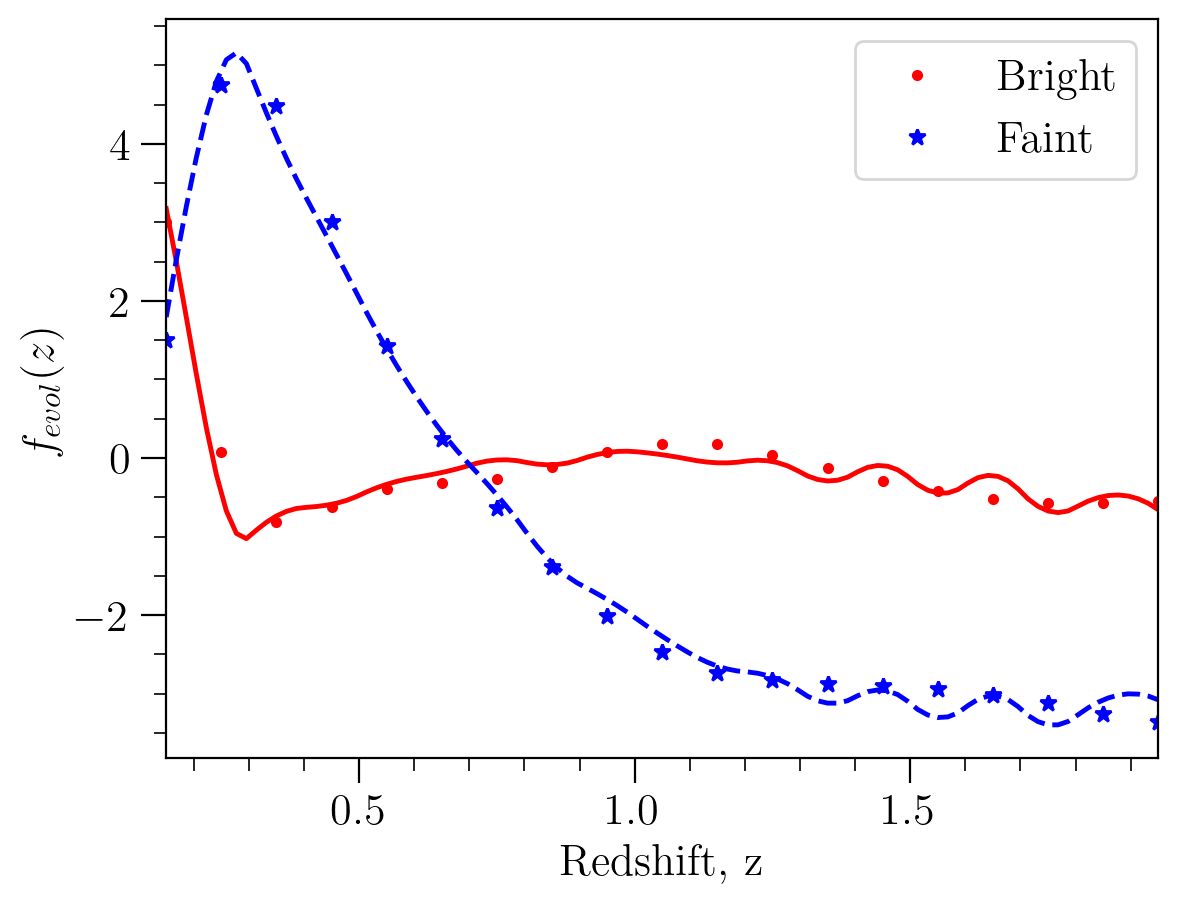

In [131]:
from scipy.interpolate import interp1d

z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_B_fid = fevol_bright(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)
fevol_F_fid = fevol_faint(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)

plt.plot(z_lin, fevol_B_fid, 'r-')
plt.plot(z_lin, fevol_F_fid, 'b--')

feB_ = myEvolBias.fevol_bright(z_lin)
feF_ = myEvolBias.fevol_faint(z_lin)

feBi = interp1d(z_lin, feB_, kind='cubic', fill_value='extrapolate')
feFi = interp1d(z_lin, feF_, kind='cubic', fill_value='extrapolate')

feB = feBi(z_bins)
feF = feFi(z_bins)

plt.plot(z_bins, feB, 'r.', label='Bright')
plt.plot(z_bins, feF, 'b*', label='Faint')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$f_{evol}(z)$');
plt.legend();

In [132]:
# Select the marginalized covariance matrix for the number evolution

cov_all_all = Sigma_Matrix_oct_all_19bins[:12, :12]
cov_all_priors = Cov_all_19bins[:12, :12]

all_fid = np.concatenate([sbias_fid, nevol_fid])

# Generate parameter samples from multivariate normal distribution

num_samples = 2000
all_pars_samples_all = np.random.multivariate_normal(all_fid, cov_all_all, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors, num_samples)

# Evaluate fitting function for each parameter sample

fevol_B_samples_all = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_all])
fevol_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])
fevol_F_samples_all = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_all])
fevol_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_lower_bound_all = np.percentile(fevol_B_samples_all, 16, axis=0)
fevol_B_upper_bound_all = np.percentile(fevol_B_samples_all, 84, axis=0)
fevol_B_lower_bound_priors = np.percentile(fevol_B_samples_priors, 16, axis=0)
fevol_B_upper_bound_priors = np.percentile(fevol_B_samples_priors, 84, axis=0)

fevol_F_lower_bound_all = np.percentile(fevol_F_samples_all, 16, axis=0)
fevol_F_upper_bound_all = np.percentile(fevol_F_samples_all, 84, axis=0)
fevol_F_lower_bound_priors = np.percentile(fevol_F_samples_priors, 16, axis=0)
fevol_F_upper_bound_priors = np.percentile(fevol_F_samples_priors, 84, axis=0)

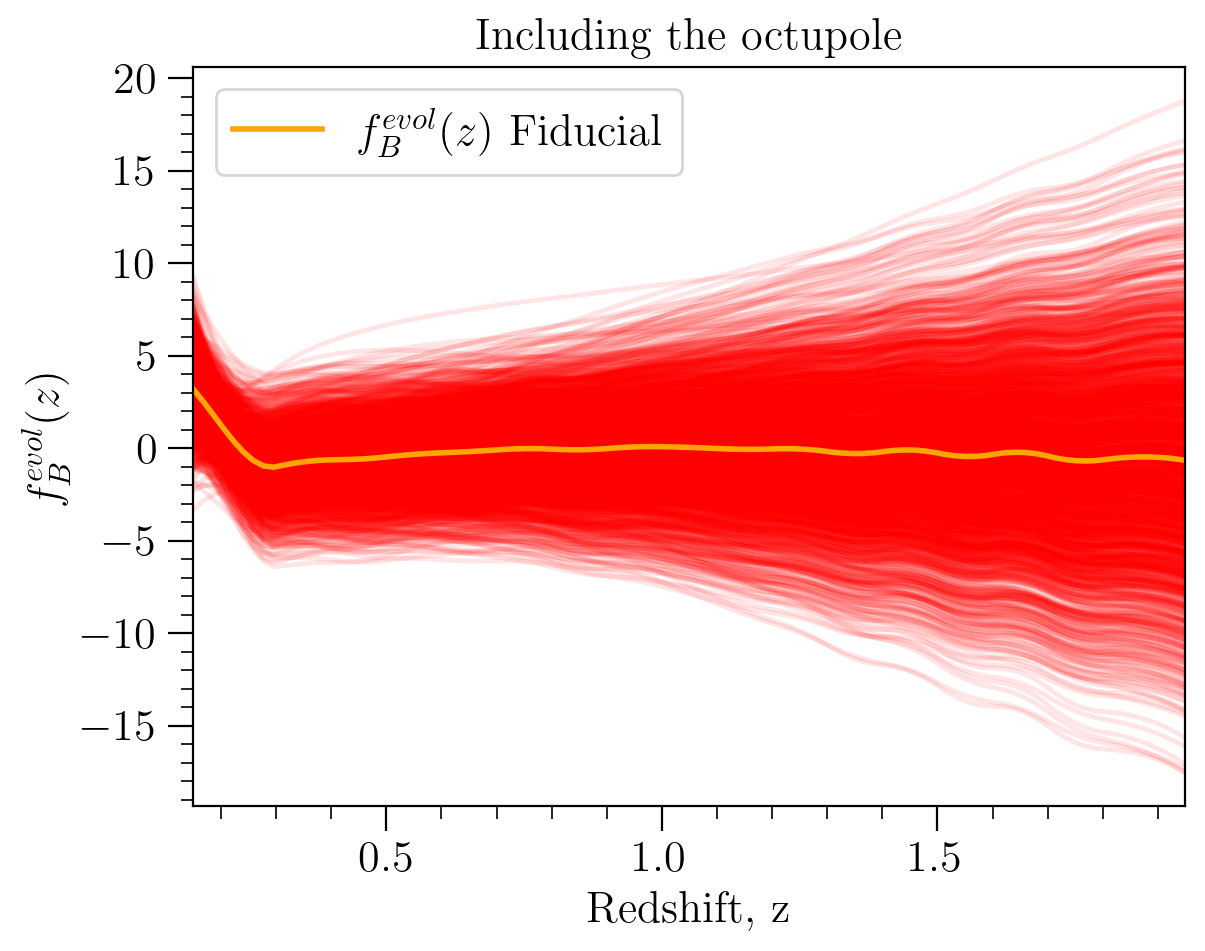

In [133]:
# Plot the fitting function for each sample
for sample in fevol_B_samples_all:
    plt.plot(z_lin, sample, color='red', alpha=0.1)
    
plt.plot(z_lin, fevol_B_fid, '-', color='orange', label=r'$f^{evol}_B(z)$'+' Fiducial', lw = 2.0)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')
plt.title('Including the octupole')
plt.legend();

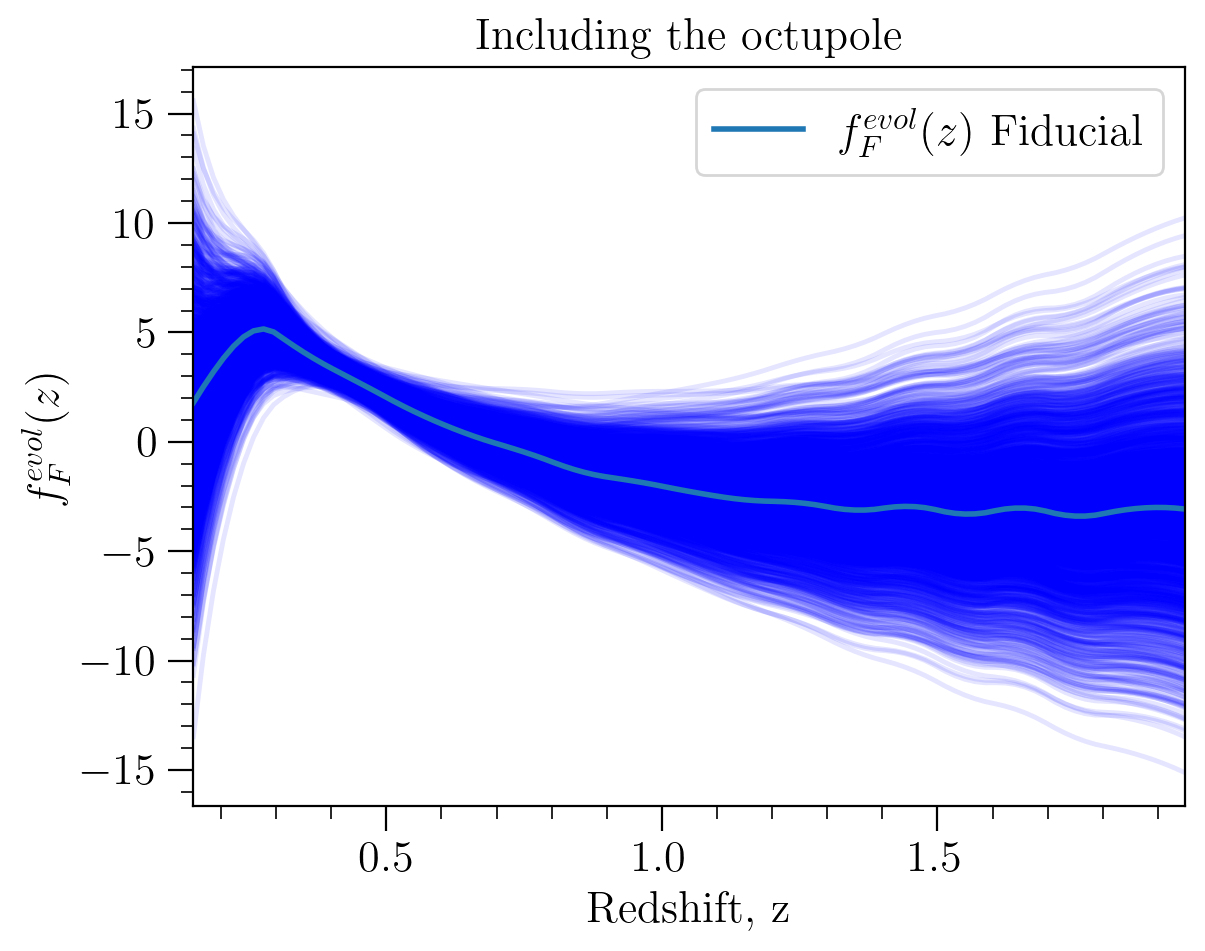

In [134]:
# Plot the fitting function for each sample
for sample in fevol_F_samples_all:
    plt.plot(z_lin, sample, color='blue', alpha=0.1)
    
plt.plot(z_lin, fevol_F_fid, '-', label=r'$f^{evol}_F(z)$'+' Fiducial', lw = 2.0)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_F(z)$')
plt.title('Including the octupole')
plt.legend();

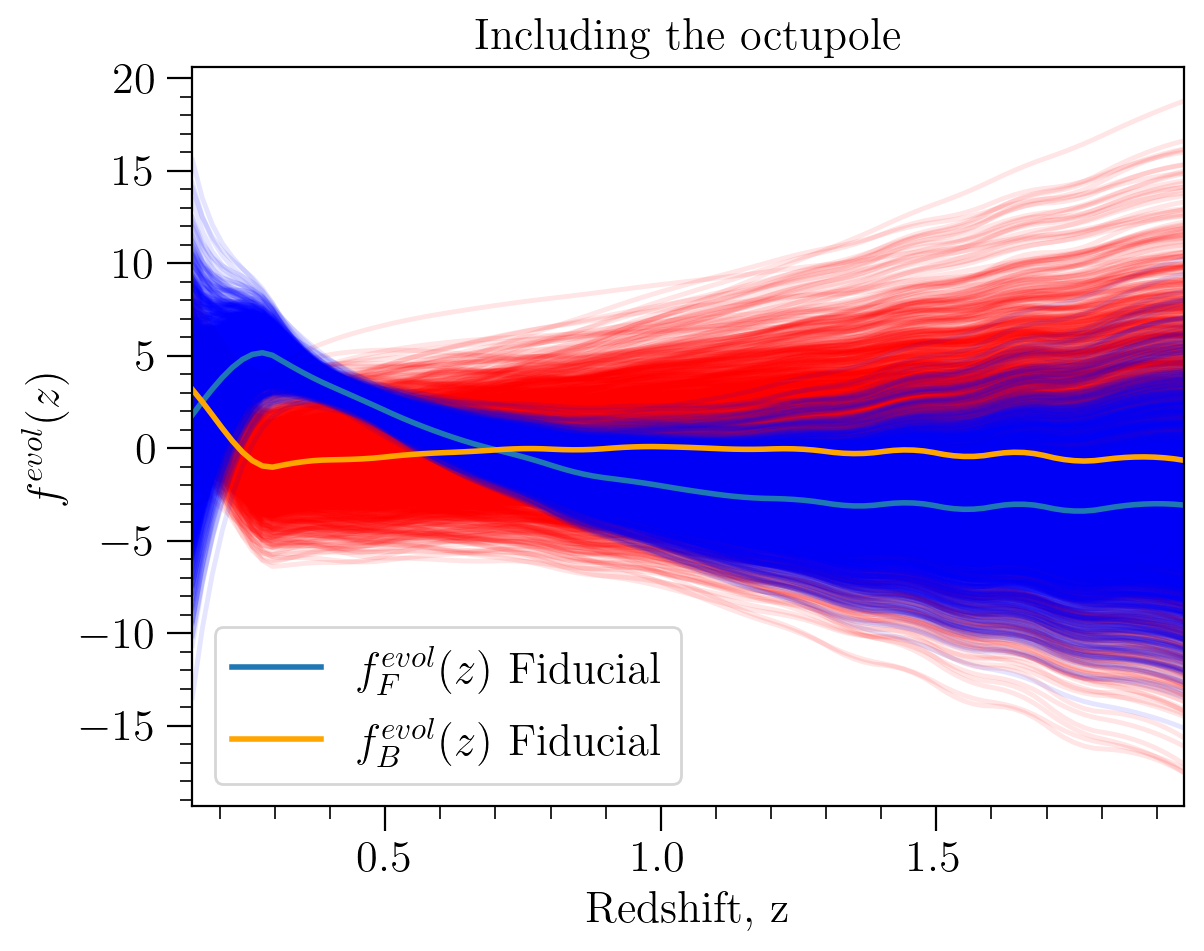

In [135]:
# Plot the fitting function for each sample
for sample in fevol_B_samples_all:
    plt.plot(z_lin, sample, color='red', alpha=0.1)

for sample in fevol_F_samples_all:
    plt.plot(z_lin, sample, color='blue', alpha=0.1)
    
plt.plot(z_lin, fevol_F_fid, '-', label=r'$f^{evol}_F(z)$'+' Fiducial', lw = 2.0)
plt.plot(z_lin, fevol_B_fid, '-', color='orange', label=r'$f^{evol}_B(z)$'+' Fiducial', lw = 2.0)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}(z)$')
plt.title('Including the octupole')
plt.legend();

Text(0.5, 1.0, 'Including the octupole')

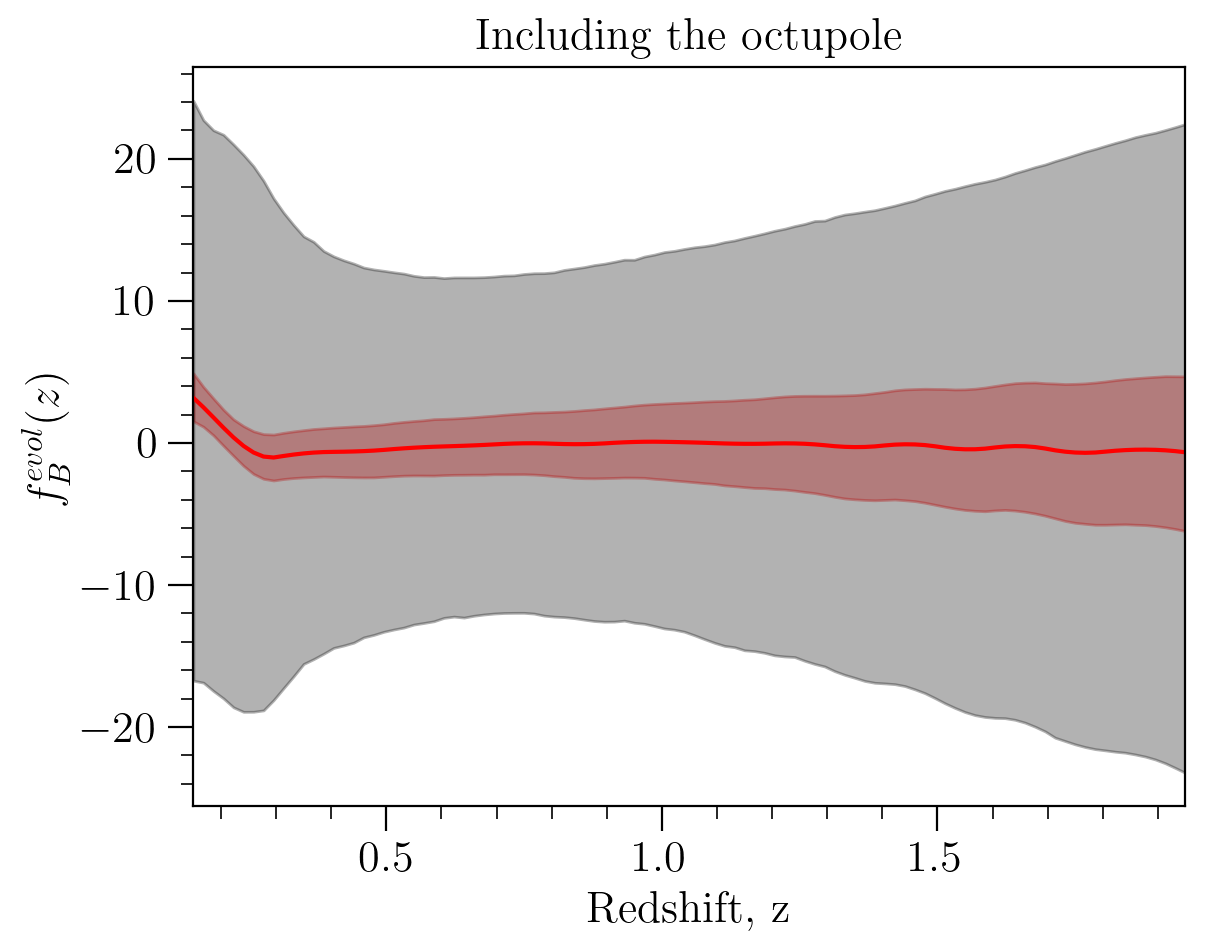

In [136]:
plt.plot(z_lin, fevol_B_fid, '-', color='red', lw = 1.5)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_all, fevol_B_upper_bound_all, color='red', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')
plt.title('Including the octupole')

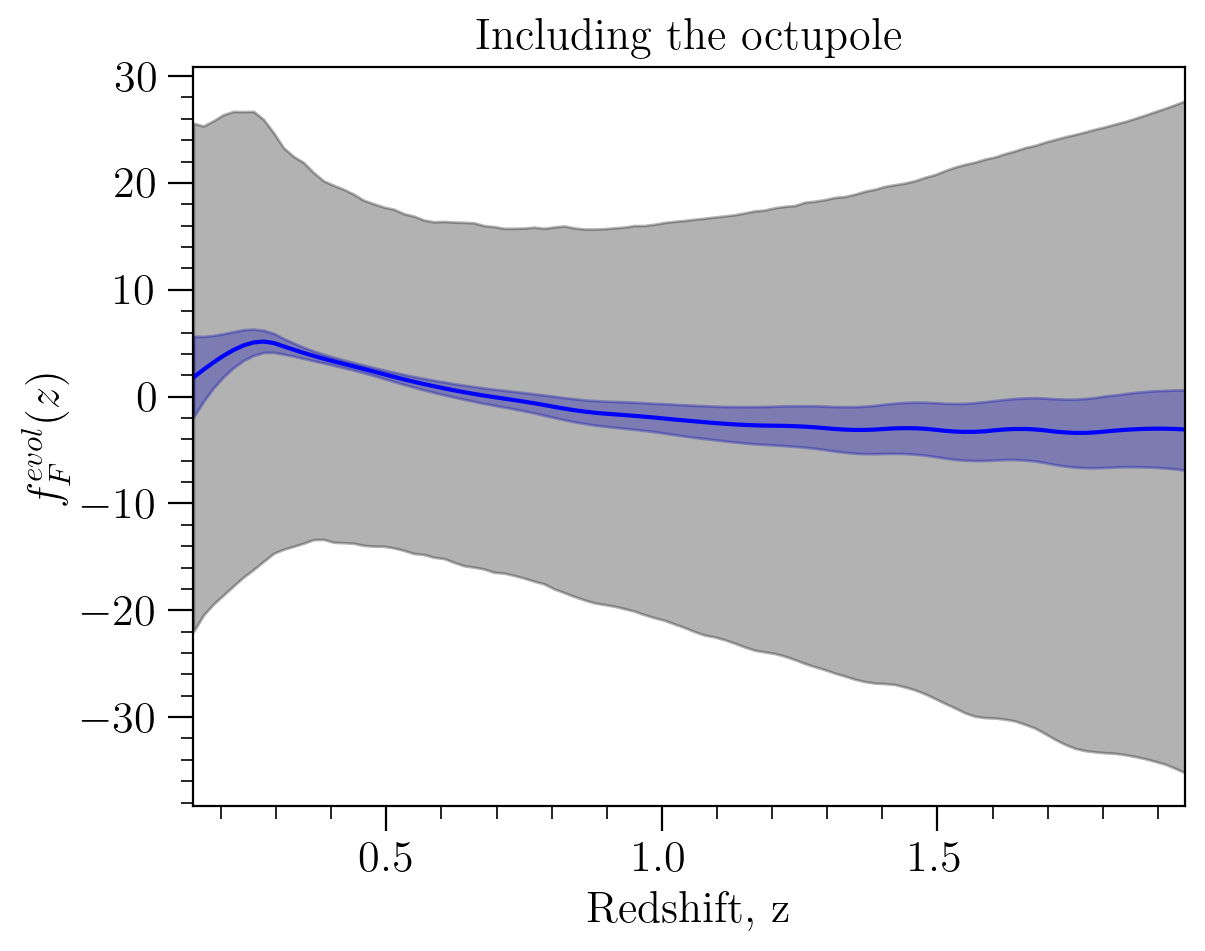

In [137]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 1.5)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_F_lower_bound_all, fevol_F_upper_bound_all, color='blue', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.3)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$f^{evol}_F(z)$');
plt.title('Including the octupole');

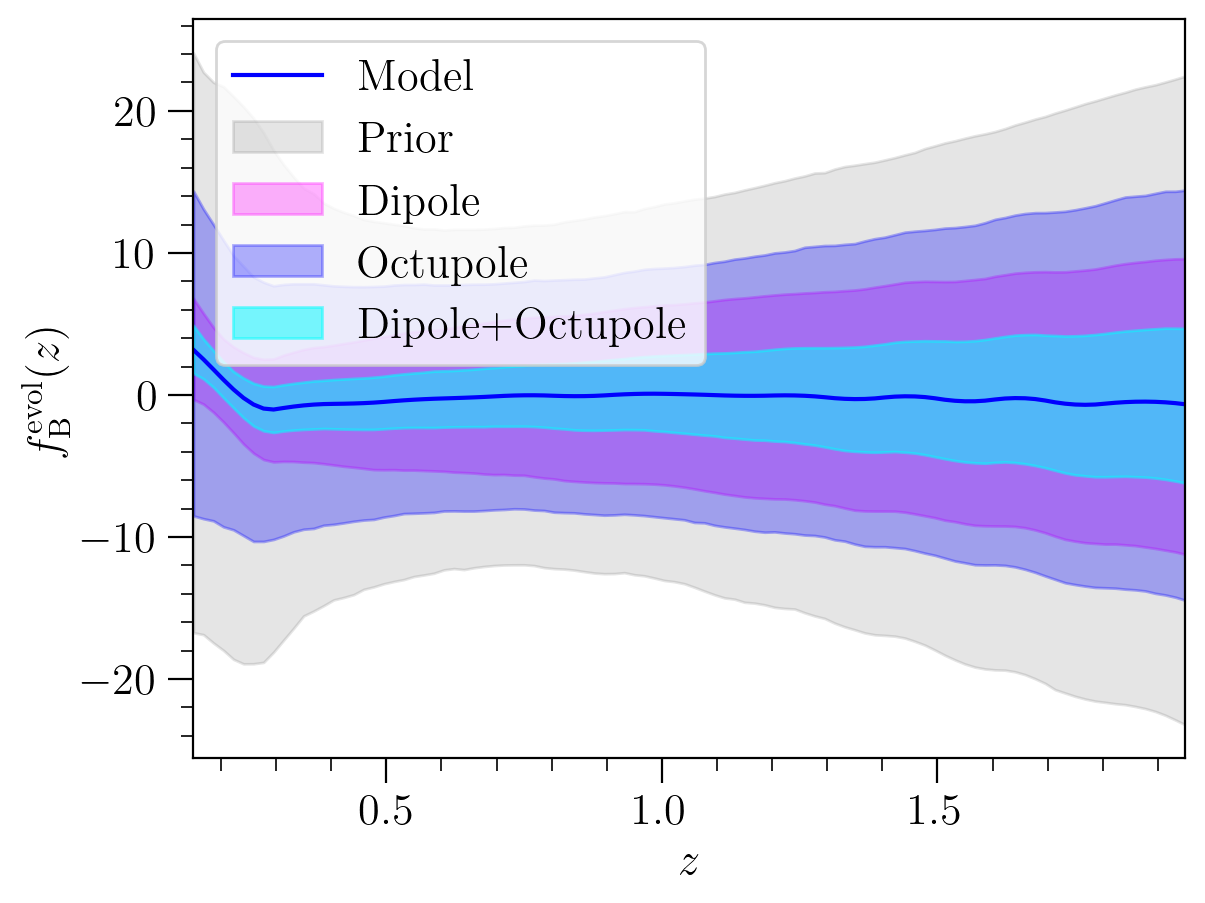

In [138]:
plt.plot(z_lin, fevol_B_fid, '-', color='blue', lw = 1.5, label = 'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, fevol_B_lower_bound, fevol_B_upper_bound, color='magenta', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, fevol_B_lower_bound_, fevol_B_upper_bound_, color='blue', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, fevol_B_lower_bound_all, fevol_B_upper_bound_all, color='cyan', alpha=0.5, label='Dipole+Octupole')

plt.xlim(0.15,1.95)

plt.xlabel(r'$z$')
plt.ylabel(r'$f^\mathrm{evol}_\mathrm{B}(z)$')
#plt.title('With and without the octupole');
plt.legend(loc='upper left')

#plt.savefig("plots/fevolB_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

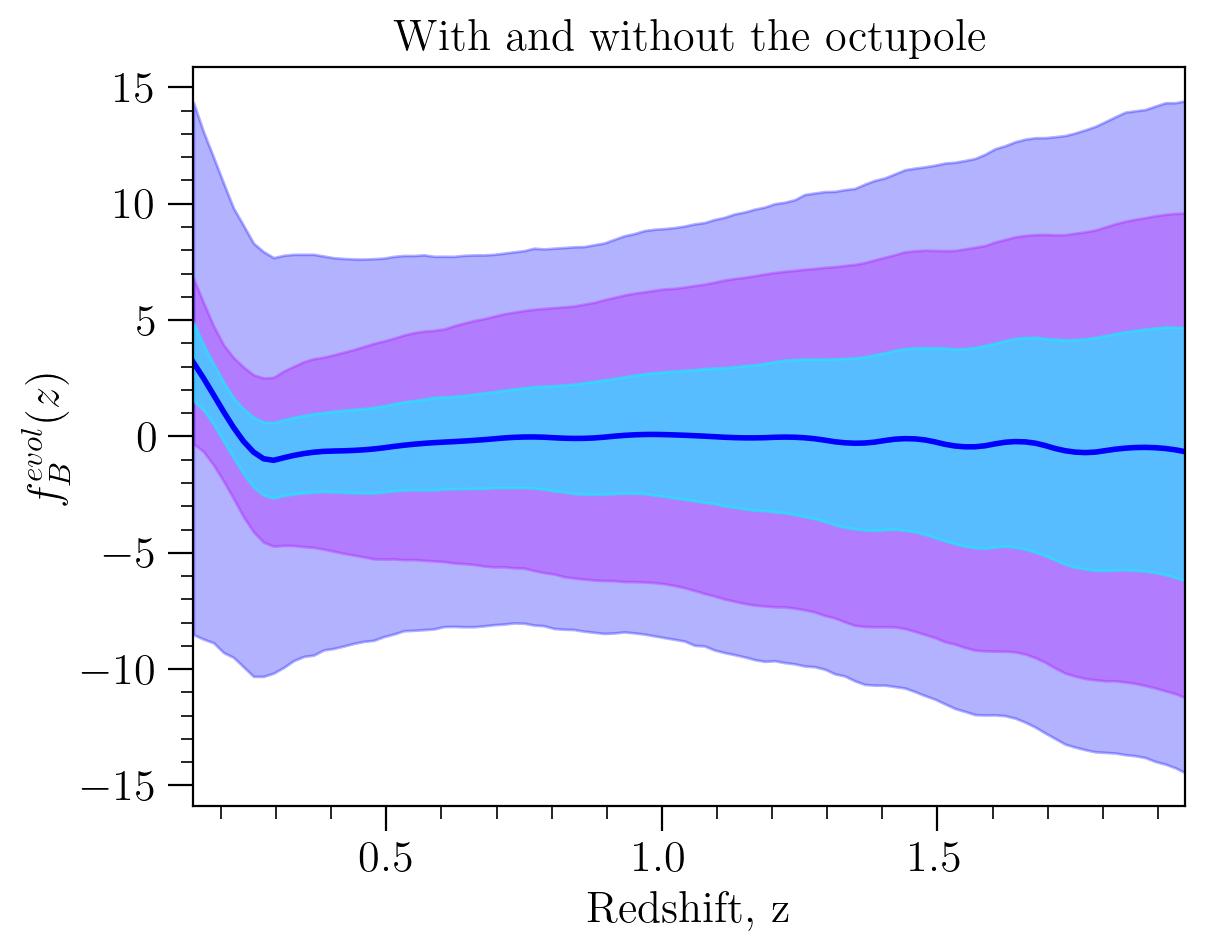

In [142]:
plt.plot(z_lin, fevol_B_fid, '-', color='blue', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound, fevol_B_upper_bound, color='magenta', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_, fevol_B_upper_bound_, color='blue', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_all, fevol_B_upper_bound_all, color='cyan', alpha=0.5)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')
plt.title('With and without the octupole');

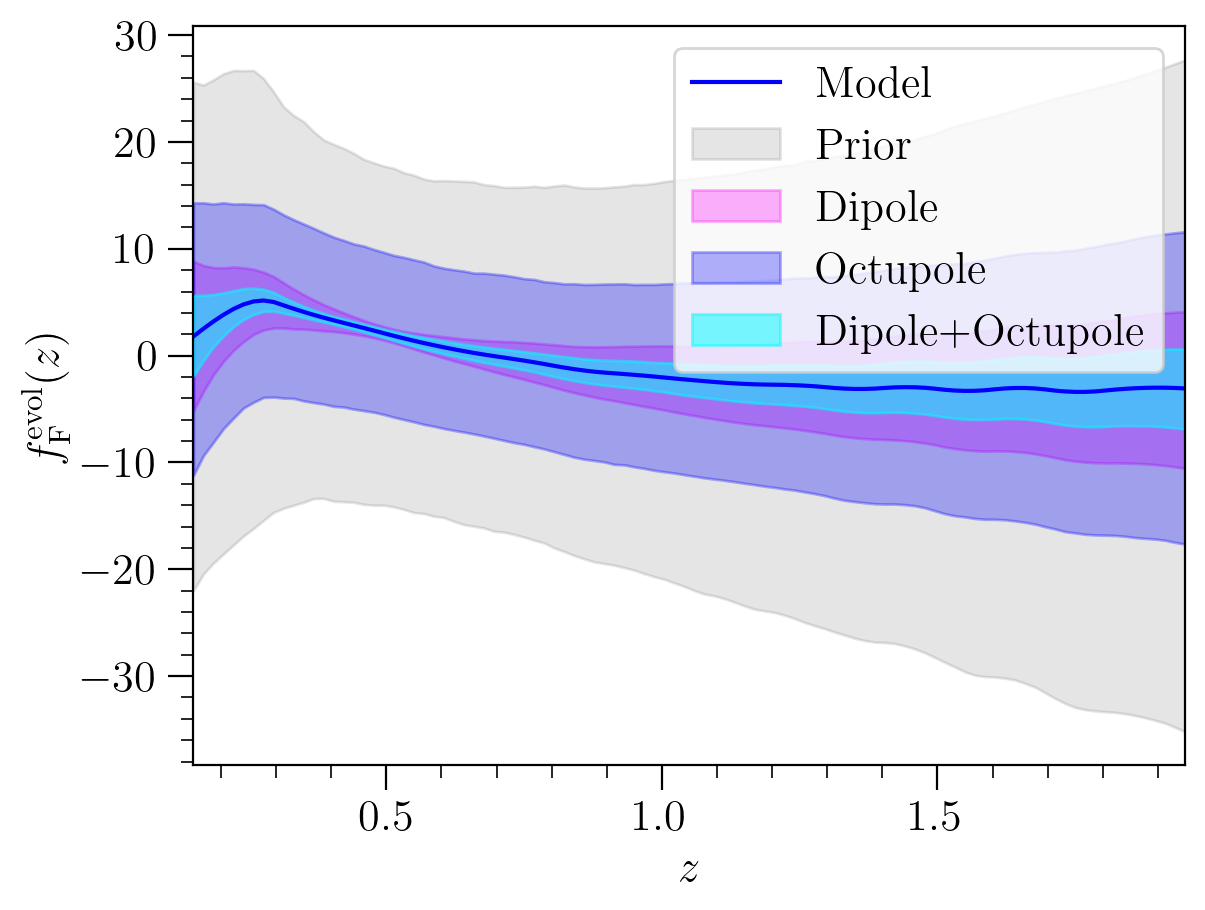

In [143]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 1.5, label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, fevol_F_lower_bound, fevol_F_upper_bound, color='magenta', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, fevol_F_lower_bound_, fevol_F_upper_bound_, color='blue', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, fevol_F_lower_bound_all, fevol_F_upper_bound_all, color='cyan', alpha=0.5, label='Dipole+Octupole')

plt.xlim(0.15,1.95)

plt.xlabel(r'$z$');
plt.ylabel(r'$f^\mathrm{evol}_\mathrm{F}(z)$');
#plt.title('With and without octupole');
plt.legend(loc='upper right')

#plt.savefig("plots/fevolF_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

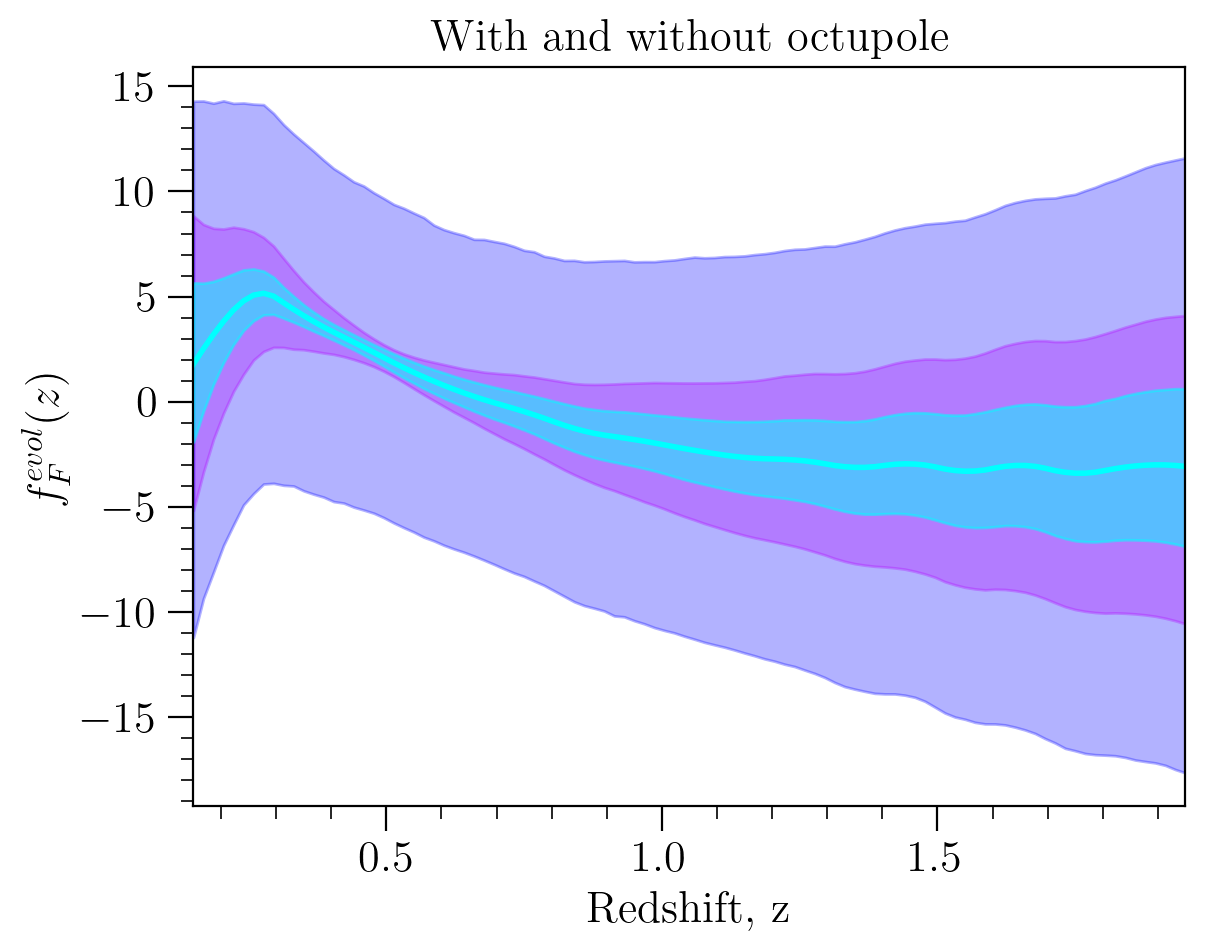

In [144]:
plt.plot(z_lin, fevol_F_fid, '-', color='cyan', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_F_lower_bound, fevol_F_upper_bound, color='magenta', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_, fevol_F_upper_bound_, color='blue', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_all, fevol_F_upper_bound_all, color='cyan', alpha=0.5)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$f^{evol}_F(z)$');
plt.title('With and without octupole');